# Import modules

In [2]:
import matplotlib as mpl
#mpl.use('TkAgg')
%matplotlib inline
mpl.matplotlib_fname()
mpl.rcParams['grid.linestyle']=':'
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['xtick.top']=True
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['ytick.right']=True
mpl.rcParams['axes.labelsize']=13
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['ytick.minor.visible']=True
#mpl.rcParams['font.size'] = 14

import os,sys
import h5py,emcee
import logging
import numpy as np
import pandas as pd
nperrset=np.seterr(all='warn')
from scipy import interpolate,optimize,stats as scistats
from scipy.optimize import curve_fit,fsolve
from scipy.signal import savgol_filter,find_peaks,find_peaks_cwt,argrelextrema
from scipy.special import wofz
import multiprocessing
from multiprocessing import Pool
from PyAstronomy import pyasl
from astropy.io import fits
from astropy.table import Table
from astropy.modeling import fitting, models as astmodels
from astropy import stats,time,coordinates as coord,units as u
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.collections as collections
from matplotlib import cm
from matplotlib.legend_handler import HandlerTuple
from matplotlib.backends.backend_pdf import PdfPages
plt.ion()
#plt.style.use('dark_background')

if(sys.version_info.major>=3):
    #===== only import for python3 kernel =======
    import phoebe
    from phoebe import u # units
    import corner,radvel
    from radvel.plot import orbit_plots, mcmc_plots
    import fourier_series_fit
    from fourier_series_fit.fit import best_fit, fourier_series_fct
    from supersmoother import SuperSmoother
    from sklearn.linear_model import HuberRegressor
    from sklearn.preprocessing import StandardScaler,RobustScaler
    import pwlf,emcee,psoap
    #--- iSpec directory -------
    ispec_dir = '/home/abiao/Downloads/iSpec_py3/'
    print(ispec_dir)
    sys.path.insert(0,os.path.abspath(ispec_dir))
    import ispec
    import isochrones.isochrones as isochrones
elif(sys.version_info.major<3):
    #===== only import for python2 kernel =======
    #--- iSpec directory -------
    ispec_dir = '/home/abiao/Downloads/iSpec_v20190302/'
    print(ispec_dir)
    sys.path.insert(0,os.path.abspath(ispec_dir))
    import ispec
    import isochrones
    ################################################################################
else:
    pass

/home/abiao/Downloads/iSpec_py3/


# Functions for RV Fitting
## P0=[e,w,r,P,T0,K1,K2]
### if unit=0, t is phase, if unit=1, t is time

In [2]:
#P,T0,e,w,r,K1,K2=[10,0,0,0,0,100,100]
unit=1
def fitRV(t,RV1,RV2=None,P0=[10,0,0,90,0,100,100],sigma1=None,sigma2=None,\
          bounds=([0.001,0,0,0,-50,1,1],[50,10,1,360,50,200,200])):
    # if unit=0, t is phase, if unit=1, t is time
    if((P0[-1]<=0)|np.sum(RV2==None)):
        P1=curve_fit(Vr,t,RV1,p0=P0[0:-1],sigma=sigma1,bounds=(bounds[0][:-1],bounds[1][:-1]))[0]
        Params=np.append(P1,P0[-1])
    else:
        RVs=RV1+RV2
        if(~np.sum(sigma1==None) & np.sum(sigma2==None)):
            sigma=sigma1
        elif(np.sum(sigma1==None) & ~np.sum(sigma2==None)):
            sigma=sigma2
        else:
            sigma=np.sqrt(sigma1**2+sigma2**2)
        Params=curve_fit(Vrs,t,RVs,p0=P0,sigma=sigma,bounds=bounds)[0]
    
    return Params

def Vrs(t,P=10,T0=0,e=0,w=90,r=0,K1=100,K2=None):
    # if unit=0, t is phase, if unit=1, t is time
    Vr1=Vr(t,P=P,T0=T0,e=e,w=w,r=r,K=K1)
    if((K2<=0)|(K2==None)):
        Vr2=np.zeros_like(t)
    else:
        Vr2=Vr(t,P=P,T0=T0,e=e,w=w+180,r=r,K=K2)
    Vrs=Vr1+Vr2
    return Vrs

def Vr(t,P=10,T0=0,e=0,w=90,r=0,K=100):
    # if unit=0, t is phase, if unit=1, t is time
    w=np.radians(w)    
    v=true_anomaly(t,P=P,T0=T0,e=e)
    Vr=K*(np.cos(w+v)+e*np.cos(w))+r
    return Vr

def true_anomaly(t,P=10,T0=0,e=0):
    # if unit=0, t is phase, if unit=1, t is time
    E_t=eccentric_anomaly(t=t,P=P,T0=T0,e=e)
    v=2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E_t/2))
    return v

def eccentric_anomaly(t,P=10,T0=0,e=0):
    # if unit=0, t is phase, if unit=1, t is time
    if(unit==0):
        phase=divmod(t,1)[1]
    else:
        phase=divmod(t-T0,P)[1]/P
    M_t=mean_anomaly(t=t,P=P,T0=T0)
    y_Et=np.linspace(0,2*np.pi,2000)
    x_Mt=y_Et-e*np.sin(y_Et)
    idx=np.argsort(x_Mt)
    x_Mt=x_Mt[idx]
    y_Et=y_Et[idx]
    func_Et_Mt=interpolate.InterpolatedUnivariateSpline(x_Mt,y_Et)
    E_t=func_Et_Mt(M_t)
    return E_t

def mean_anomaly(t,P=10,T0=0):
    # if unit=0, t is phase, if unit=1, t is time
    if(unit==0):
        phase=divmod(t,1)[1]
    else:
        phase=divmod(t-T0,P)[1]/P
    M_t=2*np.pi*phase
    return M_t




# Functions for peak/valley Fitting

In [3]:
def gauss(x,*p):
    #p=[A,mu,sigma], fwhm=2*np.sqrt(2*np.log(2))*sigma
    init_model=astmodels.Gaussian1D(*p)
    y=init_model(x)
    return y

def gauss2(x,*p):
    #p=[A1,mu1,sigma1,A2,mu2,sigma2]
    y=gauss(x,*p[0:3])+gauss(x,*p[3:])
    return y

def lorentz(x,*p):
    #p=[A,mu,fwhm]
    init_model=astmodels.Lorentz1D(*p)
    y=init_model(x)
    return y

def lorentz2(x,*p):
    #p=[A1,mu1,fwhm1,A2,mu2,fwhm2]
    y=lorentz(x,*p[0:3])+lorentz(x,*p[3:])
    return y

def voigt(x,*p):
    # p=[A_L,mu,fwhm_L,fwhm_G] --->  p0=[mu,A_L,fwhm_L,fwhm_G]
    # FWHM=0.5346*fwhmL+np.sqrt(0.2166*fwhmL**2+fwhmG**2)
    A_L,mu,fwhm_L,fwhm_G=p
    p0=[mu,A_L,fwhm_L,fwhm_G]
    init_model=astmodels.Voigt1D(*p0)
    y=init_model(x)
    return y

def voigt2(x,*p):
    #p=[A_L1,mu1,fwhm_L1,fwhm_G1,A_L2,mu2,fwhm_L2,fwhm_G2]
    #c0 = 2.0056,c1 = 1.0593,phi = fwhmL/fwhmG
    #fwhm = fwhmG*(1-c0*c1+np.sqrt(phi**2+2*c1*phi+c0**2*c1**2))
    y=voigt(x,*p[0:4])+voigt(x,*p[4:])
    return y
    
def moffat(x,*p):
    #p=[A,mu,gamma,alpha], fwhm=2*gamma
    init_model=astmodels.Moffat1D(*p)
    y=init_model(x)
    return y

def moffat2(x,*p):
    #p=[A1,mu1,gamma1,alpha1,A2,mu2,gamma2,alpha2]
    y=moffat(x,*p[0:4])+moffat(x,*p[4:])
    return y

# Functions for Radvel fit

In [4]:
def initialize_model1(P,Tp,e,w,K,gamma=0.0):
    #time_base = np.mean(t)
    Params_fit=radvel.model.Parameters(num_planets=1,basis='per tp e w k',planet_letters={1:'1'})
    Params_fit['per1']=radvel.Parameter(value = P,vary=False)
    Params_fit['tp1']=radvel.Parameter(value = Tp)
    Params_fit['e1']=radvel.Parameter(value = e)
    Params_fit['w1']=radvel.Parameter(value = np.deg2rad(w))
    Params_fit['k1']=radvel.Parameter(value = K)
    mod = radvel.RVModel(Params_fit)
    mod.params['gamma'] = radvel.Parameter(value=gamma,vary=False,linear=False)
    mod.params['jit']= radvel.Parameter(value=0.0,vary=False,linear=False)
    mod.params['dvdt'] = radvel.Parameter(value=0.0,vary=False)
    mod.params['curv'] = radvel.Parameter(value=0.0,vary=False)
    return mod


def initialize_model2(P,Tp,e,w,K1,K2,gamma=0.0):
    #time_base = np.mean(t)
    Params_fit=radvel.model.Parameters(num_planets=2,basis='per tp e w k',planet_letters={1:'1',2:'2'})
    Params_fit['per1']=radvel.Parameter(value = P,vary=False)
    Params_fit['per2']=radvel.Parameter(value = P,vary=False)
    Params_fit['tp1']=radvel.Parameter(value = Tp)
    Params_fit['tp2']=radvel.Parameter(value = Tp)
    Params_fit['e1']=radvel.Parameter(value = e)
    Params_fit['e2']=radvel.Parameter(value = e)
    Params_fit['w1']=radvel.Parameter(value = np.deg2rad(w))
    Params_fit['w2']=radvel.Parameter(value = np.deg2rad(w)+np.pi)
    Params_fit['k1']=radvel.Parameter(value = K1)
    Params_fit['k2']=radvel.Parameter(value = K2)
    mod = radvel.RVModel(Params_fit)
    mod.params['gamma'] = radvel.Parameter(value=gamma,vary=False,linear=False)
    mod.params['jit']= radvel.Parameter(value=0.0,vary=False,linear=False)
    mod.params['dvdt'] = radvel.Parameter(value=0.0,vary=False)
    mod.params['curv'] = radvel.Parameter(value=0.0,vary=False)
    return mod


def plot_results(like):
    fig = plt.gcf()
    fig.clf()
    fig.set_size_inches(12,5)
    fig.set_tight_layout(True)
    plt.errorbar(
        like.x-2450000, like.model(t)+like.residuals(),
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti-2450000, like.model(ti))
    plt.xlabel('BJD - 2450000 [day]'.format(2450000))
    plt.ylabel('RV [km/s]')
    plt.draw()
    

# Radvel fit

In [449]:
rvfile=dirname+'fd3_RVs_sum.txt'
rvsum = pd.read_csv(rvfile,sep=' ')

t = np.array(rvsum.BJD)
ti = np.linspace(rvsum.BJD.iloc[0]-1,rvsum.BJD.iloc[-1]+1,10000)
rv = np.array(rvsum.RV)
rverr = rvsum.RVerr

mod = initialize_model2()
like = radvel.likelihood.RVLikelihood(mod, t, rv, rverr)
like.params['gamma'] = radvel.Parameter(value=0.0,vary=False,linear=False)
like.params['jit']= radvel.Parameter(value=0.0,vary=False,linear=False)
like.params['per1'].vary = False
like.params['per2'].vary = False
plot_results(like)

fig=plt.gcf()
fig.savefig(dirname+'radvel_like_raw.pdf')

In [450]:
post = radvel.posterior.Posterior(like)
post.priors +=[radvel.prior.EccentricityPrior(2,0.1)]
post.priors +=[radvel.prior.HardBounds('k1',10,120)]
post.priors +=[radvel.prior.HardBounds('k2',10,120)]
post.priors +=[radvel.prior.HardBounds('tc1',Tconj0-0.1,Tconj0+0.1)]
#post.priors +=[radvel.prior.SecondaryEclipsePrior(1,Tconj0+sep*P,0.1)]

res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',      # Nelder-Mead, Powell also works
    )
plot_results(like)             # plot best fit model
fig=plt.gcf()
fig.savefig(dirname+'radvel_like_opt.pdf')
print(post)

parameter                     value      vary
per1                        4.30592      False
tc1                     2.45496e+06       True
e1                       0.00370163       True
w1                          4.32552       True
k1                          80.5413       True
per2                        4.30592      False
tc2                     2.45496e+06       True
e2                       0.00302737       True
w2                         0.714292       True
k2                          98.7141       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False
tp1                     2.45496e+06           
tp2                     2.45496e+06           

Priors
------
e1 constrained to be < 0.1
e2 constrained to be < 0.1
Bounded prior on k1, min=10, max=120
Bounded prior on k2, min=10, max=120
Bounded prior on tc1, min=2454956.637583, max=2454956.83758

In [451]:
df = radvel.mcmc(post,nwalkers=30,nrun=10000,savename=dirname+'radvel_chains.h5')

120000/2400000 (5.0%) steps complete; Running 3919.09 steps/s; Mean acceptance rate = 22.9%; Min Auto Factor =  20; Max Auto Relative-Change =   inf; Min Tz = 1971.4; Max G-R = 1.014
Discarding burn-in now that the chains are marginally well-mixed

2448000/2400000 (102.0%) steps complete; Running 3601.59 steps/s; Mean acceptance rate = 3.6%; Min Auto Factor =  23; Max Auto Relative-Change = 0.00559; Min Tz = 3094.3; Max G-R = 1.009

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [452]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()
fig=plt.gcf()
fig.set_size_inches(15,15)
fig.savefig(dirname+'radvel_corner.pdf')
plt.close()

In [447]:
RVPlot = orbit_plots.MultipanelPlot(post, legend=False)
rvplt=RVPlot.plot_multipanel()
fig=plt.gcf()
#fig.set_size_inches(8,12)
fig.align_ylabels()
rvplt[1][0].set_ylabel(' RV [km/s]')
rvplt[1][1].set_ylabel('Residual ')
rvplt[1][2].set_ylabel(' RV [km/s]')
rvplt[1][3].set_ylabel(' RV [km/s]')
rvplt[1][2].errorbar(phase_RV0,RVs_mean[:,0],yerr=RVs_std[:,0],fmt='ro',label='primary',fillstyle='none')
rvplt[1][3].errorbar(phase_RV0,RVs_mean[:,1],yerr=RVs_std[:,1],fmt='bo',label='secondary',fillstyle='none')
fig.savefig(dirname+'radvel_multipanel.pdf')

In [111]:

    unit=1  
    t=np.arange(Tconj0,Tconj0+P,P/200.0)
    phase_t0=divmod(t-Tconj0,P)[1]/P
    phase_t1=divmod(t-Tconj1,P)[1]/P
    phase_t=divmod(t-Tp,P)[1]/P
    
    idx_phase=np.argsort(phase_t0)
    RV1_sim=Vr(t,P,Tp,e,w,r,K1)
    RV2_sim=Vr(t,P,Tp,e,w+180,r,K2)
    RV1_model=Vr(BJD_RV,P,Tp,e,w,r,K1)
    RV2_model=Vr(BJD_RV,P,Tp,e,w+180,r,K2)
    Residual=RV_step*RVs_mean-np.c_[RV1_model,RV2_model]
    
    fig=plt.gcf()
    fig.set_size_inches(10,7)
    fig.clf()
    fig.subplots_adjust(hspace=0.0,wspace=0.0)
    gs1=GridSpec(3,1,left=0.09,right=0.98,bottom=0.07,top=0.98,wspace=0)
    ax1=fig.add_subplot(gs1[0:2,:])
    ax2=fig.add_subplot(gs1[2,:],sharex=ax1)
    ax1.grid()
    ax2.grid()
    ax1.tick_params(labelbottom=False)
    ax1.minorticks_on()
    ax2.minorticks_on()
    fig.align_ylabels()
    ax2.set_xlabel('Phase')
    ax1.set_ylabel('RV [km/s]')
    ax2.set_ylabel('Residual [km/s]')
    
    axplt=ax1.plot(phase_t0,RV1_sim,'ro',ms=0.5)
    axplt=ax1.plot(phase_t0,RV2_sim,'bo',ms=0.5)
    axplt=ax1.errorbar(phase_RV0,RVs_mean[:,0],yerr=RVs_std[:,0],fmt='ro',label='primary',fillstyle='none')
    axplt=ax1.errorbar(phase_RV0,RVs_mean[:,1],yerr=RVs_std[:,1],fmt='bo',label='secondary',fillstyle='none')
    axplt=ax2.errorbar(phase_RV0,Residual[:,0],yerr=RVs_std[:,0],fmt='ro',fillstyle='none')
    axplt=ax2.errorbar(phase_RV0,Residual[:,1],yerr=RVs_std[:,1],fmt='bo',fillstyle='none')
    axplt=ax1.legend()
    fig.savefig(dirname+'fd3_RVs_mean.pdf')
    
    fig.clf()
    gs1=GridSpec(3,1,left=0.09,right=0.98,bottom=0.07,top=0.98,wspace=0)
    ax1=fig.add_subplot(gs1[0:3,:])
    ax1.grid()
    ax1.minorticks_on()
    ax1.set_xlabel('Phase')
    ax1.set_ylabel('RV [km/s]')
    axplt=ax1.plot(phase_t0,RV1_sim,'ro',ms=0.5)
    axplt=ax1.plot(phase_t0,RV2_sim,'bo',ms=0.5)
    Residual_all=[]
    for ii in range(len(RVs)):
        #Residual_ii=RV_step*RVs[ii]-np.c_[RV1_model,RV2_model]
        axplt=ax1.errorbar(phase_RV0,RVs[ii][:,0],yerr=RVs_std[:,0],fmt='ro',fillstyle='none')
        axplt=ax1.errorbar(phase_RV0,RVs[ii][:,1],yerr=RVs_std[:,1],fmt='bo',fillstyle='none')
        #axplt=ax2.errorbar(phase_RV0,Residual_ii[:,0],yerr=RV_step*RVs_std[:,0],fmt='ro',fillstyle='none')
        #axplt=ax2.errorbar(phase_RV0,Residual_ii[:,1],yerr=RV_step*RVs_std[:,1],fmt='bo',fillstyle='none')
    fig.savefig(dirname+'fd3_RVs_all.pdf')

# Read, Normalize and Plot LAMOST Spectra (Time is BJD or HJD)

In [354]:
method=2  ## 0:polynomial fit 1:make_lsq_spline 2:LSQspline fit 3:Uvariate 4:savgol_filter 5:supersmooth
maxpnts=True   ## if select maximum points for smoothing
fitslist='/home/abiao/Downloads/BinaryTools/ELCcode/lzx/gzfits.list'
speclines_file='/home/abiao/Downloads/BinaryTools/ELCcode/KIC8098300/spectralines.txt' ## Known strong absorption and emission lines
speclines=np.genfromtxt(speclines_file,delimiter=":",dtype=str)
idxsplit=np.where(speclines=='ArIII')
emiss_lines=speclines[:idxsplit[0][0]+1,:]
absorp_lines=speclines[idxsplit[0][0]+1:,:]
#site=coord.EarthLocation.of_site("Beijing XingLong Observatory") ## requires internet
longitude = 155.478333
latitude = 40.395833
altitude = 900
site=coord.EarthLocation.from_geodetic(lon=longitude*u.deg,lat=latitude*u.deg,height=altitude*u.m) # xinglong
waveB=[4920,5370] ## B band wavelength range for resample
waveR=[6320,6820] ## R band wavelength range for resample
usewaveB=[4920,5370] ## B band wavelength range used for desentangling
usewaveR=[6320,6820] ## B band wavelength range used for desentangling
A = 1
B = 1
C = 0
## Initial parameters for 'A--B' system :
# P0=[P,T0,e,w,KA,KB,dw] +/- det_P0
#P0=[4.3059177,2454956.737583,0.1,180,100,100,0] # for KIC8098300
#P0=[1.3,2458956.5,0.1,180,100,100,0] #pan
P0=[ 0.047,2458956.5,0.1,180,10,10,0] #lzx

det_P0=[0,P0[0]/2.0,0.1,180,50,50,0]
Params=list(zip(P0,det_P0))
Params=sum(Params,())
P,Tconj=P0[0:2]
upthread=3
lowthread=2.5
k=2
    
if(method==4):
    Nseg=4
else:
    Nseg=8
cutL=0
cutR=0

### ======================== above parameters need to modify by user ===============================
    
    
lamostfile = np.loadtxt(fitslist, dtype = str).reshape(-1)
specpath=os.path.dirname(fitslist)+'/'
tablef=specpath+'lamosttable.txt'
plotfile=specpath+'spectra.pdf'
hdf5B=specpath+'HDF5_B.hdf5'
hdf5R=specpath+'HDF5_R.hdf5'
fd3spec_B_file=specpath+'fd3_specB.master.obs'
fd3spec_B_err_file=specpath+'fd3_specB.master.err'
fd3in_B_file=specpath+'fd3_specB.in'
fd3spec_R_file=specpath+'fd3_specR.master.obs'
fd3spec_R_err_file=specpath+'fd3_specR.master.err'
fd3in_R_file=specpath+'fd3_specR.in'

    
NAXIS2=4136 ## number of pixels
maskB=[]
maskR=[]
HELIO_RV=np.empty([0])
wlB=np.empty([0,1,NAXIS2])
flB=np.empty([0,1,NAXIS2])
sigmaB=np.empty([0,1,NAXIS2])
wlR=np.empty([0,1,NAXIS2])
flR=np.empty([0,1,NAXIS2])
sigmaR=np.empty([0,1,NAXIS2])
fd3spec_B=[]
fd3spec_R=[]
fd3spec_B_err=[]
fd3spec_R_err=[]
fd3in_B=[]
fd3in_R=[]
idxB=[]
idxR=[]
subtable=np.empty([0,6])

pdf=PdfPages(plotfile)
fig=plt.gcf()
fig.set_size_inches(9,6)
fig.clf()
fig.subplots_adjust(hspace=0.0,wspace=0.0)
gs=GridSpec(2,1,left=0.08,right=0.99,bottom=0.08,top=0.98,wspace=0.0)
ax=fig.add_subplot(gs[0,:])
ax.tick_params(labelbottom=False)
ax1=fig.add_subplot(gs[1,:],sharex=ax)
firstNB=-1
firstNR=-1
lowN=0
for fitsi in lamostfile:
    hdul=fits.open(specpath+fitsi)
    #hdul.info()
    hdr=hdul[0].header
    Ra=hdr['RA']
    Dec=hdr['DEC']
    Nspec=hdr['N_EXTEN']
    specfilename=hdr['FILENAME']
    if('med' in specfilename):
        spectype='medium'
    else:
        spectype='low'
    print(spectype,':',hdr['date-obs'],'  Number of spectra:',Nspec)
    if((spectype=='low')*(maxpnts==True)):
        upthread=5
        degree=5
    elif((spectype=='low')*(maxpnts==False)):
        upthread=5
        degree=9
    elif((spectype=='medium')*(maxpnts==True)):
        degree=8
    elif((spectype=='medium')*(maxpnts==False)):
        degree=10
        
    for i in range(Nspec):
        #if((spectype=='medium')&(i>0)&(i<=2)):
        #specheadi=hdul[i].header
        #specdatai=hdul[i].data
        #specdatai=np.array(specdatai.tolist())
        #extname=specheadi['EXTNAME']
        #lmjmlist0=np.array(specheadi['LMJMLIS0'].split('-'))
        #lmjmlist1=np.array(specheadi['LMJMLIS1'])
        #lmjmlist0=lmjmlist0.astype(float)
        #lmjmlist1=lmjmlist1.astype(float)
        #lmjd0=np.sum(lmjmlist0)/3/60/24
        #lmjd1=lmjmlist1/60/24
        #exptime=1200*3
        #print('{0:.6f}   {1:.0f}   {2:.2f} {3:s}'.format(lmjd0,exptime,specheadi['SNR'],extname))
        #print('{0:.6f}   {1:.0f}   {2:.2f} {3:s}'.format(lmjd1,exptime,specheadi['SNR'],extname))
        if((i>2)|(spectype=='low')):
            specheadi=hdul[i].header.copy()
            specheadi.remove('COMMENT',ignore_missing=True,remove_all=True)
            specdatai=np.array(hdul[i].data.tolist())
            if(spectype=='low'):
                specdatai=specdatai.T
            idxsort=np.argsort(specdatai[:,2])
            specdatai=specdatai[idxsort]
            flux=specdatai[:,0]
            fluxerr=np.sqrt(1/specdatai[:,1])            
            if(spectype=='medium'):
                obsdate=specheadi['DATE-OBS']
                extname=specheadi['EXTNAME']
                exptime=specheadi['EXPTIME']
                #utcmjd=float(specheadi['LMJM'])/60.0/24.0+exptime/2.0/3600.0/24.0-8/24.0                
                SNR=specheadi['SNR']
                wavelen=10**specdatai[:,2]
            if(spectype=='low'):
                obsdate=hdr['DATE-OBS']
                extname=specheadi['FILENAME'][0:10]
                exptime=specheadi['EXPTIME']
                #lmjmlist=np.array(specheadi['LMJMLIST'].split('-')).astype(float)
                #utcmjd=lmjmlist.mean()/60.0/24.0+exptime/2.0/3600.0/24.0-8/24.0                
                SNRs=np.array([specheadi['SNRU'],specheadi['SNRG'],specheadi['SNRR'],specheadi['SNRI'],specheadi['SNRZ']])
                SNR=np.mean(SNRs[SNRs>0])
                wavelen=specdatai[:,2]
                lowN=lowN+1
            utcmjd=time.Time(obsdate,scale='utc',format='fits')
            hdr['EXTNAME']=extname
            specheadi['EXTNAME']=extname
            specheadi.append(('FILENAME',hdr['FILENAME']))
            specheadi.append(('RA',hdr['RA']))
            specheadi.append(('DEC',hdr['DEC']))


            #--- Calculate barycentric/heliocentric velocity correction toward star
            if((':' in str(hdr['RA']))|(':' in str(hdr['DEC']))|(' ' in str(hdr['RA']))|(' ' in str(hdr['DEC']))):
                objcoord=coord.SkyCoord(hdr['RA'],hdr['DEC'],frame='icrs',unit=(u.hourangle, u.deg),equinox=time.Time(2000.0,scale='utc',format='jyear'))
            else:
                objcoord=coord.SkyCoord(hdr['RA'],hdr['DEC'],frame='icrs',unit=u.deg,equinox=time.Time(2000.0,scale='utc',format='jyear'))
            ltt_bary=utcmjd.light_travel_time(objcoord,kind='barycentric',location=site,\
                      ephemeris='file:///home/abiao/Downloads/BinaryTools/JPLephemerides/de435.bsp')
            BJD_TDB=utcmjd.tdb+ltt_bary
            BJD_TDB=BJD_TDB.jd
            # ltt_helio=utcmjd.light_travel_time(objcoord,kind='heliocentric',location=site,\
            #            ephemeris='file:///home/abiao/Downloads/BinaryTools/JPLephemerides/de435.bsp')
            # HJD_UTC=utcmjd.utc+ltt_helio
            # HJD_UTC=HJD_UTC.jd
            phase=divmod(BJD_TDB-Tconj,P)[1]/P   
            newline=np.array([[obsdate,'{0:.5f}'.format(BJD_TDB),'{0:.5f}'.format(phase),exptime,'{0:.1f}'.format(SNR),extname]])
            subtable=np.concatenate([subtable,newline],axis=0)
            
            bv3,hjd = pyasl.helcorr(site.lon.deg,site.lat.deg,site.height.value,\
                            objcoord.ra.deg,objcoord.dec.deg,utcmjd.jd,debug=False)
            #HJD_UTC=time.Time(hjd,scale='utc',format='jd')
            ### --- LAMOST fits header
            try:
                hv_lamost=-hdr['HELIO_RV']
                detv=bv3-hv_lamost
                HV_corrected=True
            except:
                hv_lamost=np.nan
                detv=0
                HV_corrected=False
          
            #--- Convert wavelengths from vacuum to air ---------------------------------
            star_spectrum = ispec.create_spectrum_structure(wavelen,flux=flux,err=fluxerr)
            star_spectrum = ispec.vacuum_to_air(star_spectrum)
        
            #--- Barycentric/heliocentric velocity correction ------------------------------
            if(HV_corrected==False):
                star_spectrum = ispec.correct_velocity(star_spectrum,-bv3)
            else:
                star_spectrum = ispec.correct_velocity(star_spectrum,-detv) 
            HELIO_RV=np.append(HELIO_RV,-bv3) 
            wavelen=star_spectrum['waveobs']
            flux=star_spectrum['flux']
            fluxerr=star_spectrum['err']
            lnwavelen=np.log(wavelen)           
            
            Ha=float(absorp_lines[np.where(absorp_lines=='Halpha')[0]][0,0])
            idxlines=(wavelen>Ha-20)*(wavelen<Ha+20)
            if(method!=3):
                for line_i in absorp_lines[:,0]:
                    idxlines=idxlines|((wavelen>float(line_i)-5)*(wavelen<float(line_i)+5))  
            idxout=idxlines.copy()
            smoothflux=flux.copy()
            Nout_diff=100
            loopi=0
            while(Nout_diff!=0):
                loopi=loopi+1
                if((loopi>=2)*(loopi<=3)*(maxpnts==True)):
                    idxpeak=argrelextrema(flux[~idxout],comparator=np.greater,order=1)[0] ## max points1
                    idxnum_out=np.arange(len(idxout))
                    item_out=idxnum_out[~idxout][idxpeak]
                    idxorigin1=np.in1d(idxnum_out,item_out,assume_unique=True)                    
                    idxpeak=argrelextrema(flux[~(idxout|idxorigin1)],comparator=np.greater,order=1)[0] ## max points2
                    idxnum_out=np.arange(len(idxout))
                    item_out=idxnum_out[~(idxout|idxorigin1)][idxpeak]
                    idxorigin2=np.in1d(idxnum_out,item_out,assume_unique=True)
#                     idxpeak=argrelextrema(flux[~(idxout|idxorigin1|idxorigin2)],comparator=np.greater,order=1)[0] ## max points2
#                     idxnum_out=np.arange(len(idxout))
#                     item_out=idxnum_out[~(idxout|idxorigin1|idxorigin2)][idxpeak]
#                     idxorigin3=np.in1d(idxnum_out,item_out,assume_unique=True)                    
                    idxout=~(idxorigin1|idxorigin2)     
                Nout1=np.sum(idxout)
                N_wave=len(flux[~idxout])
                win_len=int(N_wave/Nseg)
                if(np.mod(win_len,2)==0):
                    win_len=win_len-1
                t=wavelen[~idxout][10*k:-10*k:win_len]
                if(method==0):
                    ### polynomial fit
                    P=np.polyfit(wavelen[~idxout],flux[~idxout],deg=degree)
                    smoothflux=np.polyval(P,wavelen)
                elif(method==1):
                    ### make_lsq_spline
                    t=np.r_[(wavelen[~idxout][0],)*(k+1),t,(wavelen[~idxout][-1],)*(k+1)]
                    spl=interpolate.make_lsq_spline(wavelen[~idxout],flux[~idxout],t,k=k)
                    smoothflux=spl(wavelen)
                elif(method==2):
                    ### LSQUnivariateSpline
                    spl=interpolate.LSQUnivariateSpline(wavelen[~idxout],flux[~idxout],t,k=k)
                    smoothflux=spl(wavelen)
                elif(method==3):
                    ### UnivariateSpline interp 
                    spl=interpolate.UnivariateSpline(wavelen[~idxout],flux[~idxout],w=1/fluxerr[~idxout],s=len(fluxerr[~idxout]),k=k)
                    smoothflux=spl(wavelen)
                elif(method==4):
                    ### smoothing filter savgol_filter
                    smoothflux[~idxout]=savgol_filter(flux[~idxout],window_length=win_len, polyorder=k)
                    f=interpolate.interp1d(wavelen[~idxout],smoothflux[~idxout],kind='cubic')
                    minwave_interp=wavelen[~idxout].min()
                    maxwave_interp=wavelen[~idxout].max()
                    idxinterp=(wavelen>=minwave_interp)*(wavelen<=maxwave_interp)
                    smoothflux[idxout*idxinterp]=f(wavelen[idxout*idxinterp])
                    subflux=flux[idxout*(~idxinterp)]
                    subwave=wavelen[idxout*(~idxinterp)]
#                     smoothflux[wavelen<minwave_interp]=np.median(smoothflux[(~idxout)*idxinterp][0:k])
#                     smoothflux[wavelen>maxwave_interp]=np.median(smoothflux[(~idxout)*idxinterp][-k:])
                    subwin_len=int(len(subwave)/Nseg)
                    if(len(subflux)>10):
                        t=subwave[k:-k:subwin_len]
                        spl=interpolate.LSQUnivariateSpline(subwave,subflux,t,k=3)
                        smoothflux[idxout*(~idxinterp)]=spl(subwave)
                elif(method==5):
                    fspan=0.05
                    model=SuperSmoother(primary_spans=(fspan, 0.2, 0.5), middle_span=0.2, final_span=fspan)
                    model=model.fit(wavelen[~idxout],flux[~idxout],dy=fluxerr[~idxout])
                    smoothflux=model.predict(wavelen)
                else:
                    raise ValueError('Wrong method !!!')
                residual=(flux-smoothflux)
                res_mean,res_med,res_std=stats.sigma_clipped_stats(residual[~idxout],mask=np.isnan(residual[~idxout]))
                idxout=idxout|((residual-res_med)<-lowthread*res_std)|((residual-res_med)>upthread*res_std)|idxlines
                Nout2=np.sum(idxout)
                Nout_diff=Nout2-Nout1
                
            idxout=((residual-res_med)<-lowthread*res_std)|((residual-res_med)>upthread*res_std)    
            norm_flux=flux/smoothflux
            norm_fluxerr=fluxerr/smoothflux
            res_mean1,res_med1,res_std1=stats.sigma_clipped_stats(norm_flux,mask=np.isnan(norm_flux))
            idxbad=((residual-res_med)>2*upthread*res_std)| \
                   (((residual-res_med)<-10*lowthread*res_std)&(flux<0))
            idxbad[0:10]=True
            idxbad[-30:]=True
            flux[idxbad]=smoothflux[idxbad]
            norm_flux[idxbad]=res_med1           
            if('B' in extname):
                ### save to hdf5 data for PSOAP
                wlB=np.concatenate((wlB,wavelen[None,None,:]),axis=0)
                flB=np.concatenate((flB,norm_flux[None,None,:]),axis=0)
                sigmaB=np.concatenate((sigmaB,norm_fluxerr[None,None,:]),axis=0)
                
                ### save to data array for fd3
                firstNB=firstNB+1
                idxB.append(firstNB+firstNR+lowN+1)
                if(firstNB==0):
                    idxwave=(wavelen>=waveB[0])*(wavelen<=waveB[1])
                    Nresample=int(np.sum(idxwave))
                    lnwave_resampleB=np.linspace(np.log(waveB[0]),np.log(waveB[1]),Nresample)
                    fd3spec_B.append(lnwave_resampleB)
                    fd3spec_B_err.append(lnwave_resampleB)
                f=interpolate.interp1d(lnwavelen,norm_flux,kind='linear',fill_value='extrapolate')
                norm_flux_resample=f(lnwave_resampleB)
                f=interpolate.interp1d(lnwavelen,norm_fluxerr,kind='linear',fill_value='extrapolate')
                norm_fluxerr_resample=f(lnwave_resampleB)
                med_norm_fluxerr_resample=np.nanmedian(norm_fluxerr_resample)
                fd3spec_B.append(norm_flux_resample)
                fd3spec_B_err.append(norm_fluxerr_resample)
                fd3in_B.append([BJD_TDB,0,med_norm_fluxerr_resample,0.6,0.4])
            elif('R' in extname):
                ### save to hdf5 data for PSOAP
                wlR=np.concatenate((wlR,wavelen[None,None,:]),axis=0)
                flR=np.concatenate((flR,norm_flux[None,None,:]),axis=0)
                sigmaR=np.concatenate((sigmaR,norm_fluxerr[None,None,:]),axis=0)
                
                ### save to data array for fd3
                firstNR=firstNR+1
                idxR.append(firstNB+firstNR+lowN+1)
                if(firstNR==0):
                    idxwave=(wavelen>=waveR[0])*(wavelen<=waveR[1])
                    Nresample=int(np.sum(idxwave))
                    lnwave_resampleR=np.linspace(np.log(waveR[0]),np.log(waveR[1]),Nresample)
                    fd3spec_R.append(lnwave_resampleR)
                    fd3spec_R_err.append(lnwave_resampleR)
                f=interpolate.interp1d(lnwavelen,norm_flux,kind='linear',fill_value='extrapolate')
                norm_flux_resample=f(lnwave_resampleR)
                f=interpolate.interp1d(lnwavelen,norm_fluxerr,kind='linear',fill_value='extrapolate')
                norm_fluxerr_resample=f(lnwave_resampleR)
                med_norm_fluxerr_resample=np.nanmedian(norm_fluxerr_resample)
                fd3spec_R.append(norm_flux_resample)
                fd3spec_R_err.append(norm_fluxerr_resample)
                fd3in_R.append([BJD_TDB,0,med_norm_fluxerr_resample,0.6,0.4]) 
            ### convert to the format for processing with iSpec 
            #=== ASCII text file
            spec_file=specpath+'ispec_'+extname[0:10]+'.txt'
            np.savetxt(spec_file,np.c_[wavelen[cutL:NAXIS2-cutR]/10.0,flux[cutL:NAXIS2-cutR],fluxerr[cutL:NAXIS2-cutR]],'%.8f',header='waveobs  flux  err')
            spec_file=specpath+'ispec_'+extname[0:10]+'_norm.txt'
            np.savetxt(spec_file,np.c_[wavelen[cutL:NAXIS2-cutR]/10.0,norm_flux[cutL:NAXIS2-cutR],norm_fluxerr[cutL:NAXIS2-cutR]],'%.8f',header='waveobs  norm_flux  err')
            
            #=== Muti-extension fits file
            spec_file=specpath+'ispec_'+extname[0:10]+'.fits'
            spec_head=specpath+'ispec_'+extname[0:10]+'.head'
            colname=['AWAV','FLUX','SIGMA' ]
            colunit=['NM','COUNT','COUNT']
            coldata=np.c_[wavelen[cutL:NAXIS2-cutR]/10.0,flux[cutL:NAXIS2-cutR],fluxerr[cutL:NAXIS2-cutR]]
            primhdu=fits.PrimaryHDU(header=hdr.copy(strip=True))
            image_hdu=fits.ImageHDU(coldata.T)
            image_hdu.header.extend(specheadi,strip=True,unique=True,useblanks=False,bottom=True)
            image_hdu.header.totextfile(spec_head,overwrite=True)
            bintabcols=[fits.Column(name=colname[i],format='E',unit=colunit[i],array=coldata[:,i]) for i in range(len(colname))]
            bintabhdu=fits.BinTableHDU.from_columns(bintabcols)
            bintabhdu.header.extend(specheadi,strip=True,unique=True,useblanks=False,bottom=True)
            newhdul=fits.HDUList([primhdu,image_hdu,bintabhdu])
            newhdul.writeto(spec_file,overwrite=True)
            
            spec_file=specpath+'ispec_'+extname[0:10]+'_norm.fits'
            coldata=np.c_[wavelen[cutL:NAXIS2-cutR]/10.0,norm_flux[cutL:NAXIS2-cutR],norm_fluxerr[cutL:NAXIS2-cutR]]
            image_hdu.data=coldata.T
            bintabcols=[fits.Column(name=colname[i],format='E',unit=colunit[i],array=coldata[:,i]) for i in range(len(colname))]
            bintabhdu=fits.BinTableHDU.from_columns(bintabcols)
            bintabhdu.header.extend(specheadi,strip=True,unique=True,useblanks=False,bottom=True)
            newhdul=fits.HDUList([primhdu,image_hdu,bintabhdu])
            newhdul.writeto(spec_file,overwrite=True)
            
            ### convert to the format for processing with CRES 
            spec_file=specpath+'CRES_'+extname[0:10]+'.txt'
            np.savetxt(spec_file,np.c_[wavelen[cutL:NAXIS2-cutR],norm_flux[cutL:NAXIS2-cutR],norm_fluxerr[cutL:NAXIS2-cutR]],'%.8f')
            ### convert to the format for processing with KOREL 
            spec_file=specpath+'KOREL_'+extname[0:10]+'.txt'

            
            ax.cla()
            ax1.cla()
            xmin,xmax=[np.nanmin(wavelen),np.nanmax(wavelen)]
            ymin,ymax=[np.nanmin(smoothflux-8*lowthread*res_std),np.nanmax( smoothflux+4*upthread*res_std)]
            ymin=np.max([ymin,np.nanmin(flux)])-lowthread*res_std
            #ymax=np.min([ymax,np.nanmax(flux)])+upthread*res_std
            detx=xmax-xmin
            dety=ymax-ymin
            axplt=ax.plot(wavelen,flux,'k-',lw=1,label=extname[0:10])
            if('B' in extname):
                axplt=ax.axvspan(usewaveB[0],usewaveB[1],facecolor='aqua', alpha=0.3)
            elif('R' in extname):
                axplt=ax.axvspan(usewaveR[0],usewaveR[1],facecolor='magenta', alpha=0.3)
            axplt=ax.plot(wavelen,smoothflux,'r-',lw=1.5,label='Smoothed',zorder=7)
            #axplt=ax.plot(wavelen[idxbad],smoothflux[idxbad],'+',ms=10,color='lime',lw=1,label='outliers',zorder=8)
            axplt=ax.plot(wavelen,smoothflux+upthread*res_std,color='r',lw=1.5,linestyle='--',zorder=9)
            axplt=ax.plot(wavelen,smoothflux-lowthread*res_std,color='r',lw=1.5,linestyle='--',zorder=10)
            axplt=ax.legend()

            xlines=emiss_lines[:,0].astype(float)
            idx=(xlines>xmin)*(xlines<xmax)
            xlines=xlines[idx]
            axplt=ax.vlines(xlines,ymin,ymax,lw=1,color='r',linestyle='-')
            axplt=[ax.text(xlines[i]+3,ymax-0.05*dety,emiss_lines[idx][i,1],color='r',fontsize=8,rotation=90,verticalalignment='top') for i in range(len(xlines))]
            xlines=absorp_lines[:,0].astype(float)
            idx=(xlines>xmin)*(xlines<xmax)
            xlines=xlines[idx]
            axplt=ax.vlines(xlines,ymin,ymax,lw=1,color='b',linestyle='--')
            #axplt=[ax.text(xlines[i]+3,ymin+0.05*dety,absorp_lines[idx][i,1],color='b',fontsize=8,rotation=-90,verticalalignment='bottom') for i in range(len(xlines))]
            axplt=ax.set_ylabel('Flux')
            axplt=ax.set_ylim(ymin,ymax)
            axplt=ax.minorticks_on()
            
            
            ymin,ymax=[np.nanmin(res_med1-8*lowthread*res_std1),np.nanmax(res_med1+2*upthread*res_std1)]
            ymin=np.max([ymin,np.nanmin(norm_flux)])-lowthread*res_std1
            #ymax=np.min([ymax,np.nanmax(norm_flux)])+upthread*res_std1
            dety=ymax-ymin
            axplt=ax1.plot(wavelen,norm_flux,'k-',lw=1,label='Normalized',zorder=0)
            #axplt=ax1.plot(wavelen[idxbad],np.repeat(res_med1,len(wavelen))[idxbad],'+',ms=10,color='lime',lw=1,label='outliers')
            if('B' in extname):
                axplt=ax1.plot(np.e**lnwave_resampleB,norm_flux_resample,'-',color='blue',lw=1,label='Resampled',alpha=0.5)
                axplt=ax1.axvspan(usewaveB[0],usewaveB[1],facecolor='aqua', alpha=0.3)
            elif('R' in extname):
                axplt=ax1.plot(np.e**lnwave_resampleR,norm_flux_resample,'-',color='red',lw=1,label='Resampled',alpha=0.5)
                axplt=ax1.axvspan(usewaveR[0],usewaveR[1],facecolor='magenta', alpha=0.3)
            axplt=ax1.hlines(res_med1,xmin,xmax,color='r',lw=1.5,zorder=1)
            axplt=ax1.hlines(res_med1+upthread*res_std1,xmin,xmax,color='r',lw=1.5,linestyle='--',zorder=2)
            axplt=ax1.hlines(res_med1-lowthread*res_std1,xmin,xmax,color='r',lw=1.5,linestyle='--',zorder=3)
            
            xlines=emiss_lines[:,0].astype(float)
            idx=(xlines>xmin)*(xlines<xmax)
            xlines=xlines[idx]
            axplt=ax1.vlines(xlines,ymin,ymax,lw=1,color='r',linestyle='-')
            #axplt=[ax1.text(xlines[i]+3,ymax-0.05*dety,emiss_lines[idx][i,1],color='r',fontsize=8,rotation=-90,verticalalignment='top') for i in range(len(xlines))]
            xlines=absorp_lines[:,0].astype(float)
            idx=(xlines>xmin)*(xlines<xmax)
            xlines=xlines[idx]
            axplt=ax1.vlines(xlines,ymin,ymax,lw=1,color='b',linestyle='--')
            axplt=[ax1.text(xlines[i]+3,ymin+0.05*dety,absorp_lines[idx][i,1],color='b',fontsize=8,rotation=90,verticalalignment='bottom') for i in range(len(xlines))]
            axplt=ax1.legend()
            axplt=ax1.set_xlabel('$\mathrm{Wavelength}\ [\AA]$')
            axplt=ax1.set_ylabel('Normalized  Flux')
            axplt=ax1.set_ylim(ymin,ymax)
            axplt=ax1.set_xlim(xmin-0.01*detx,xmax+0.01*detx)
            axplt=ax1.minorticks_on()
            fig.align_ylabels()
            #plt.tight_layout()
            fig.canvas.draw_idle()
            fig.canvas.start_event_loop(2)
            pdf.savefig(fig)
    hdul.close()
pdf.close()
print(subtable.shape)




        
        
        

# ## Transform MJD to BJD/HJD
# print('Transforming MJD to BJD/HJD ... ... ... ...')
# Objcoord=coord.SkyCoord(objcoord[:,0],objcoord[:,1],frame='icrs',unit=u.deg,equinox=time.Time(2000.0,scale='utc',format='jyear'))
# MJD=subtable[:,3].astype('float')
# t=time.Time(MJD,format='mjd', scale='utc')
# # Convert to Altitude-Azimuth system
# # AltAz_frame = coord.AltAz(obstime=t, location=site)
# # Objcoord_AltAz = Objcoord.transform_to(AltAz_frame)
# ltt_bary=t.light_travel_time(Objcoord,kind='barycentric',location=site,\
#                              ephemeris='file:///home/abiao/Downloads/BinaryTools/JPLephemerides/de435.bsp')
# BJD=t.tdb+ltt_bary
# BJD=BJD.jd-2400000
# # ltt_helio=t.light_travel_time(Objcoord,kind='heliocentric',location=site,\
# #                               ephemeris='file:///home/abiao/Downloads/BinaryTools/JPLephemerides/de435.bsp')
# # HJD=t.utc+ltt_helio
# # HJD=HJD.jd-2400000


# subtable[:,3]=np.round(BJD,6)
head=np.array([['  Date_Obs','  BJD','  Phase','  ExpTime',' Mean_SNR','  Specname']])
subtable=np.concatenate([head,subtable],axis=0)
print('Complete !!!')
np.savetxt(tablef,subtable,fmt='%s', delimiter='  ')
    
idxB=np.array(idxB,dtype=int)
idxR=np.array(idxR,dtype=int)
### convert to the format for processing with fd3
if(len(idxB)>0):
    fd3spec_B=np.array(fd3spec_B)
    fd3spec_B_err=np.array(fd3spec_B_err)
    fd3in_B=np.array(fd3in_B)
    np.savetxt(fd3spec_B_file,fd3spec_B.T,'%.8f',header=str(fd3spec_B.shape[0])+' X '+str(fd3spec_B.shape[1]))
    np.savetxt(fd3spec_B_err_file,fd3spec_B_err.T,'%.8f',header=str(fd3spec_B_err.shape[0])+' X '+str(fd3spec_B_err.shape[1]))
    strhead=['fd3_specB.master.obs  '+str(np.log(usewaveB[0]))+' '+str(np.log(usewaveB[1]))+ \
             ' fd3_specB  '+str(A)+' '+str(B)+' '+str(C)]
    np.savetxt(fd3in_B_file,strhead,'%s')
    with open(fd3in_B_file,'at') as f:
        np.savetxt(f,fd3in_B,fmt='%f',newline='\n',delimiter='  ')
        np.savetxt(f,['1 0   0 0   0 0   0 0   0 0   0 0'],fmt='%s')
        np.savetxt(f,Params,'%s',newline=' ')
        f.write('\n')
        np.savetxt(f,['100  1000  0.00001'],fmt='%s',newline='\n')
if(len(idxR)>0):
    fd3spec_R=np.array(fd3spec_R)
    fd3spec_R_err=np.array(fd3spec_R_err)
    fd3in_R=np.array(fd3in_R)
    np.savetxt(fd3spec_R_file,fd3spec_R.T,'%.8f',header=str(fd3spec_R.shape[0])+' X '+str(fd3spec_R.shape[1]))
    np.savetxt(fd3spec_R_err_file,fd3spec_R_err.T,'%.8f',header=str(fd3spec_R_err.shape[0])+' X '+str(fd3spec_R_err.shape[1]))
    strhead=['fd3_specR.master.obs  '+str(np.log(usewaveR[0]))+' '+str(np.log(usewaveR[1]))+ \
             ' fd3_specR  '+str(A)+' '+str(B)+' '+str(C)]
    np.savetxt(fd3in_R_file,strhead,'%s')
    with open(fd3in_R_file,'at') as f:
        np.savetxt(f,fd3in_R,fmt='%f', newline='\n',delimiter='  ')
        np.savetxt(f,['1 0   0 0   0 0   0 0   0 0   0 0'],fmt='%s')
        np.savetxt(f,Params,'%s',newline=' ')
        f.write('\n')
        np.savetxt(f,['100  1000  0.00001'],fmt='%s',newline='\n')
        
        
if(len(idxB)>0):        
    ## Convert to the HDF5 file
    fB=h5py.File(hdf5B,'w')
    fB['BCV']=-HELIO_RV[idxB]
    fB['JD']=subtable[1:,1][idxB].astype(float)
    fB['wl']=wlB[:,:,cutL:NAXIS2-cutR]
    fB['fl']=flB[:,:,cutL:NAXIS2-cutR]
    fB['sigma']=sigmaB[:,:,cutL:NAXIS2-cutR]
    fB.close()
    
if(len(idxR)>0):
    ## Convert to the HDF5 file
    fR=h5py.File(hdf5R,'w')
    fR['BCV']=-HELIO_RV[idxR]
    fR['JD']=subtable[1:,1][idxR].astype(float)
    fR['wl']=wlR[:,:,cutL:NAXIS2-cutR]
    fR['fl']=flR[:,:,cutL:NAXIS2-cutR]
    fR['sigma']=sigmaR[:,:,cutL:NAXIS2-cutR]
    fR.close()

medium : 2017-09-29T19:07:00   Number of spectra: 21
medium : 2017-11-05T17:20:00   Number of spectra: 11
medium : 2017-11-07T17:21:00   Number of spectra: 19
medium : 2017-11-26T16:05:00   Number of spectra: 9
medium : 2017-11-28T15:03:00   Number of spectra: 7
medium : 2018-01-03T14:03:00   Number of spectra: 9
medium : 2018-02-03T11:49:00   Number of spectra: 11
(66, 6)
Complete !!!


# Check Masks of LAMOST Spectra

In [ ]:
c = 299800
print(norm_flux_resample.shape)
spec_bins=len(lnwave_resampleR)
step_lnwavelen=np.diff(lnwave_resampleR)
step_wavelen=np.diff(np.e**lnwave_resampleR)

x=c*lnwave_resampleR
diff_x=np.diff(x)
RV_step1=c*step_wavelen/np.e**lnwave_resampleR[0:-1]

print('step_lnwavelen:\n',step_lnwavelen)
print('diff_x:\n',diff_x)
print('RV_step1:\n ',RV_step1)

lamostfile = np.loadtxt(fitslist, dtype = str).reshape(-1)
for fitsi in lamostfile:
    hdul=fits.open(specpath+fitsi)
    print('======== ',fitsi,' ==========')
    for i in range(len(hdul)):
        if(i==0):
            specheadi=hdul[i].header
            value=np.binary_repr(specheadi['FIBERMAS'], width=9)
            print('FIBERMAS: ',value)
        if(i>0):
            specdatai=hdul[i].data
            specdatai=np.array(specdatai.tolist())
            specheadi=hdul[i].header
        if((i>=1) & (i<=2)):
            idx=specdatai[:,3]>0
            value=specdatai[idx,3]
            print(specheadi['EXTNAME'],'    mask pixel: ',np.sum(idx),'  ',value)
            #print(value)
        if(i>2):
            idx=specdatai[:,3]>0
            value=specdatai[idx,3]
            print(specheadi['EXTNAME'],'    mask pixel: ',np.sum(idx),'  ',value)
            #print(value)
    hdul.close()

#print(repr(specheadi))

# fig=plt.gcf()
# fig.set_size_inches(12,7.5)
# fig.clf()
# fig.subplots_adjust(hspace=0.1,wspace=0.0)
# gs=GridSpec(2,1,left=0.07,right=0.98,bottom=0.08,top=0.98,wspace=0.0)
# ax=fig.add_subplot(gs[0,:])

# ax1=fig.add_subplot(gs[1,:])
# axplt=ax.plot(cent_wavelen,step_wavelen,'.')
# axplt=ax1.plot(cent_lnwavelen,step_lnwavelen,'.')


# Process spectra using iSpec

In [358]:
filelist='../../iSpec_py3/lzx/bandB/fitsB.list'
headlist='../../iSpec_py3/KIC8098300/test_head_haha.list'

Ncomp=1 # Number of components of the star system, should be 1, 2, or 3
from_resolution = 42000 # ELODIE: ~42000, Narval: ~70000-90000, HARPS: ~115000
#Params=[4.3059177,2454956.737583,0.0,90,-11.688,78.151,93.835] ## KIC 8098300
#Params=[6.23061,2454966.123235,0.0,90,-30.147565,69.562398,82.813827] #jiaxin
#Params=[1.341169,2458956.31863,0,90,-40,90,100] ## pan
Params=[ 0.047,2458956.31863,0,90,0,10,10] #lzx
P,Tconj,e,w,r,K1,K2=Params
pri_width=0.07 #KIC8098300:0.0434,jiaxin: 0.0302,pan:0.07 
sec_width=0.07 #KIC8098300:0.0462,jiaxin: 0.0291,pan:0.07 
seperation=0.5 #KIC8098300:0.5034,jiaxin: 0.5 
ratio=1/50


#--- Change LOG level ----------------------------------------------------------
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.WARN)

c = 299792.4580 # light speed (km/s)
longitude = 155.478333
latitude = 40.395833
altitude = 900
site=coord.EarthLocation.from_geodetic(lon=longitude*u.deg,lat=latitude*u.deg,height=altitude*u.m) # xinglong


# - Read atomic data
#mask_file = ispec_dir + "/input/linelists/CCF/Narval.Sun.370_1048nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/Atlas.Arcturus.372_926nm/mask.lst""
#mask_file = ispec_dir + "/input/linelists/CCF/Atlas.Sun.372_926nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst"
mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.F0.360_698nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.G2.375_679nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.K0.378_679nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.K5.378_680nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.M5.400_687nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/Synthetic.Sun.350_1100nm/mask.lst"
#mask_file = ispec_dir + "/input/linelists/CCF/VALD.Sun.300_1100nm/mask.lst"
ccf_mask = ispec.read_cross_correlation_mask(mask_file)

#--- Convert wavelengths from air to vacuum ---------------------------------
# if(VacuumOrAir=='air'):
#     logging.info("Converting wavelengths from air to vacuum ...")
#     for maskwave in ['wave_peak','wave_base','wave_top']:
#         ccf_mask_spec = ispec.create_spectrum_structure(ccf_mask[maskwave],flux=ccf_mask['depth'])
#         ccf_mask_spec = ispec.air_to_vacuum(ccf_mask_spec)
#         ccf_mask[maskwave]=ccf_mask_spec['waveobs'].copy()

    



# - Read synthetic template
#template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Arcturus.372_926nm/template.txt.gz")
template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Sun.372_926nm/template.txt.gz")
#template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/NARVAL.Sun.370_1048nm/template.txt.gz")
#template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Synth.Sun.300_1100nm/template.txt.gz")

#--- Convert wavelengths from air to vacuum ---------------------------------
# if(VacuumOrAir=='air'):
#     logging.info("Converting wavelengths from air to vacuum ...")
#     template = ispec.air_to_vacuum(template)
    
     


pdf1=PdfPages(os.path.dirname(filelist)+'/ispec_raw.pdf')
pdf2=PdfPages(os.path.dirname(filelist)+'/ispec_norm.pdf')
pdf3=PdfPages(os.path.dirname(filelist)+'/ispec_CCF_atomiclines.pdf')
pdf4=PdfPages(os.path.dirname(filelist)+'/ispec_CCF_atomiclines_fit.pdf')
pdf5=PdfPages(os.path.dirname(filelist)+'/ispec_CCF_template.pdf')
pdf6=PdfPages(os.path.dirname(filelist)+'/ispec_CCF_template_fit.pdf')
pdf7=PdfPages(os.path.dirname(filelist)+'/ispec_CCF_telluriclines.pdf')
#pdf8=PdfPages(os.path.dirname(filelist)+'/ispec_isochrone.pdf')
pdf9=PdfPages(os.path.dirname(filelist)+'/ispec_RVs.pdf')

outname1=os.path.dirname(filelist)+'/'+'ispec_RVs_linemask.txt'
outname2=os.path.dirname(filelist)+'/'+'ispec_RVs_linemask_fit.txt'
outname3=os.path.dirname(filelist)+'/'+'ispec_RVs_template.txt'
outname4=os.path.dirname(filelist)+'/'+'ispec_RVs_template_fit.txt'
outname5=os.path.dirname(filelist)+'/'+'ispec_RVs_mean.txt'
outname6=os.path.dirname(filelist)+'/'+'ispec_RVs_residual.txt'

head_out=np.array([['#filename','       BJD','      Phase','  BV','   HV',\
                    'A1','FWHM1','RV1','RV1_err',\
                    'A2','FWHM2','RV2','RV2_err',\
                    'A3','FWHM3','RV3','RV3_err']])

RVs_out1=head_out.copy()
RVs_out2=head_out.copy()
RVs_out3=head_out.copy()
RVs_out4=head_out.copy()
RVs_out5=head_out.copy()



    

datafiles=np.loadtxt(filelist,dtype='str').reshape(-1)
headfiles=[]
if(os.path.isfile(headlist)):
    headfiles=np.loadtxt(headlist,dtype='str').reshape(-1)
RV_telluric=RV_telluric_err=np.array([])
Skewness=np.zeros([len(datafiles),2])+np.nan
nperrset=np.seterr(all='warn')
for i in range(len(datafiles)):
    filename=os.path.dirname(filelist)+'/'+datafiles[i]
    if(len(headfiles)==0):
        hdul=fits.open(filename)
        hdr=hdul[0].header
        specheadi=hdul[1].header.copy()
        specdatai=np.array(hdul[1].data.tolist())
        hdul.close()
    else:
        headname=os.path.dirname(headlist)+'/'+headfiles[i]
        hdr=fits.Header.fromtextfile(headname)
        specheadi=hdr
        specdatai=np.loadtxt(filename)
    
    try:
        specfilename=specheadi['FILENAME']
    except:
        specfilename=os.path.basename(filename)[0:16]
        specheadi.append(('EXTNAME',specfilename))
        
    if('med' in specfilename):
        from_resolution = 7500
    elif(specfilename!=os.path.basename(filename)[0:16]):
        from_resolution = 1800
    else:
        print('Resolution is ',from_resolution,'!!!')

    print('\n===== Processing: '+filename)
    
    #--- Calculate barycentric/heliocentric velocity correction toward star
    logging.info("Calculating bcv/hcv correction...")
    obsdate=time.Time(specheadi['DATE-OBS'],scale='utc',format='fits')
    if((':' in str(hdr['RA']))|(':' in str(hdr['DEC']))|(' ' in str(hdr['RA']))|(' ' in str(hdr['DEC']))):
        objcoord=coord.SkyCoord(hdr['RA'],hdr['DEC'],frame='icrs',unit=(u.hourangle, u.deg),equinox=time.Time(2000.0,scale='utc',format='jyear'))
    else:
        objcoord=coord.SkyCoord(hdr['RA'],hdr['DEC'],frame='icrs',unit=u.deg,equinox=time.Time(2000.0,scale='utc',format='jyear'))
    
    ltt_bary=obsdate.light_travel_time(objcoord,kind='barycentric',location=site,\
                                       ephemeris='file:///home/abiao/Downloads/BinaryTools/JPLephemerides/de435.bsp')
    BJD_TDB=obsdate.tdb+ltt_bary
    BJD_TDB=BJD_TDB.jd
    # ltt_helio=obsdate.light_travel_time(objcoord,kind='heliocentric',location=site,\
    #                                    ephemeris='file:///home/abiao/Downloads/BinaryTools/JPLephemerides/de435.bsp')
    # HJD_UTC=obsdate.utc+ltt_helio
    # HJD_UTC=HJD_UTC.jd
    phase=divmod(BJD_TDB-Tconj,P)[1]/P
    year,month,day,hours,minutes,seconds = obsdate.datetime.year,obsdate.datetime.month,obsdate.datetime.day,\
                                           obsdate.datetime.hour,obsdate.datetime.minute,obsdate.datetime.second
    ra_hours,ra_minutes,ra_seconds = objcoord.ra.hms
    dec_degrees,dec_minutes,dec_seconds = objcoord.dec.dms
    

    #--- iSpec
#     bv0 = -ispec.calculate_barycentric_velocity_correction(\
#                             (year, month, day, hours, minutes, seconds), \
#                             (ra_hours, ra_minutes, ra_seconds, dec_degrees, dec_minutes, dec_seconds))
    #--- Astropy
#     bv1= objcoord.radial_velocity_correction(kind='barycentric',obstime=obsdate,location=site)
#     bv1=bv1.to(u.km/u.s).value
#     hv1= objcoord.radial_velocity_correction(kind='heliocentric',obstime=obsdate,location=site)
#     hv1=hv1.to(u.km/u.s).value
    #--- PyAstronomy.AstroLib
    #--- correction only for the helio- and barycentric motion of the Earth
#     hv2,bv2=pyasl.baryCorr(obsdate.jd,objcoord.ra.deg,objcoord.dec.deg,deq=2000.0)
    #---correction for rotation of earth, 
    #   rotation of earth center about the earth-moon barycenter,
    #   earth-moon barycenter about the center of the Sun.
    bv3,hjd = pyasl.helcorr(site.lon.deg,site.lat.deg,site.height.value,\
                            objcoord.ra.deg,objcoord.dec.deg,obsdate.jd,debug=False)
    #HJD_UTC=time.Time(hjd,scale='utc',format='jd')
    
    # #--- LAMOST fits header
    try:
        hv_lamost=-hdr['HELIO_RV']
        detv=bv3-hv_lamost
    except:
        hv_lamost=np.nan
        detv=0
        
    #--- Compare different velocities corrections
#     print('LAMOST     bv_lamost: ','    ----       '  ,' hv_lamost: ',hv_lamost)
#     print('iSpec      bv0: ',bv0,'         ',' hv:     ----  ')
#     print('Astropy    bv1: ',bv1,' hcv1: ',hv1)
#     print('AstroLib   bv2: ',bv2,' hcv2: ',hv2)
#     print('AstroLib   bv3: ',bv3,' hcv3:     ----  ')

    
    ######## for KIC8098300-B #############################
#     maxdepth=0.986 #KIC8098300:0.986(B) #jiaxin:0.98
#     det_maxdepth=0.003 #KIC8098300:0.003(B),jiain:0.006
#     lowlimit_RV=-280 ##KIC8098300:-280
#     uplimit_RV=280 #KIC8098300:280
#     prob1=0.5 ## for atomic lines, KIC8098300:0.5,jiaxin:0.35
#     prob2=0.1 ## for template, KIC8098300:0.1,jiaxin:0.25
#     phase_blend=0.1
#     ratio1=0.32
#     ratio2=0.45
#     if(abs(phase-0)<phase_blend)|(abs(phase-seperation)<phase_blend)|(abs(phase-1)<phase_blend):
#         lowlimit_RV=-200
#         uplimit_RV=200
#     if((abs(phase-0)<ratio1*phase_blend)|(abs(phase-seperation)<ratio1*phase_blend)|(abs(phase-1)<ratio1*phase_blend)):   
#         maxdepth=0.96
#         prob1=0.5 
#     if('B-84454719' in filename):     
#         prob1=0.5 
#     if('B-84964439.fits' in filename):
#         maxdepth=0.995
#         det_maxdepth=0.000
#     if('B-84964486' in filename)|('B-84981666' in filename):
#         maxdepth=0.99
#         det_maxdepth=0.000
#     if('B-84450349.fits' in filename):
#         maxdepth=0.993
#         det_maxdepth=0.0
#         lowlimit_RV=-250
#         uplimit_RV=250

      

    ###### for KIC8098300-R #################
#     maxdepth=0.984
#     det_maxdepth=0.003
#     lowlimit_RV=-350 ##KIC8098300:-280
#     uplimit_RV=350 #KIC8098300:280
#     prob1=0.6 ## for atomic lines, KIC8098300:0.5,jiaxin:0.35
#     prob2=0.6 ## for template, KIC8098300:0.1,jiaxin:0.25
#     if(abs(phase-0)<phase_blend)|(abs(phase-seperation)<phase_blend)|(abs(phase-1)<phase_blend):
#         lowlimit_RV=-250
#         uplimit_RV=250  
#     if('R-83908969' in filename):
#         maxdepth=0.975


    ######## for pan #############################
    lowlimit_RV=-200 
    uplimit_RV=200 
    prob1=0.9 ## for atomic lines
    prob2=0.9 ## for template
    phase_blend=0.1
    ratio1=1.0
    ratio2=0.45


#     if('B-84320859' in filename):
#         prob1=0.8
#         prob2=0.8
#         lowlimit_RV=-380 
#         uplimit_RV=380 
#     if('B-84320924' in filename):
#         prob1=0.8
#         prob2=0.8
#         lowlimit_RV=-330 
#         uplimit_RV=360 
#     if('B-84320942' in filename):
#         prob1=0.9
#         prob2=0.9
#         lowlimit_RV=-400 
#         uplimit_RV=450 
#     if('B-84320878' in filename)|('B-84320961' in filename):
#         prob1=0.01
#         prob2=0.01
#         lowlimit_RV=-360 
#         uplimit_RV=420 
        

#     if('B-84336748' in filename)|('B-84336766' in filename)|('B-84336785' in filename)|\
#       ('B-84338163' in filename)|('B-84338181' in filename)|('B-84338199' in filename)|\
#       ('B-84339537' in filename)|('B-84339556' in filename)|('B-84339574' in filename)|\
#       ('B-84339606' in filename)|('B-84339624' in filename)|('B-84339642' in filename)|\
#       ('B-84339661' in filename)|('B-84964270' in filename)|('B-84964294' in filename)|\
#       ('B-84964317' in filename)|('B-84964340' in filename):
#         prob1=0.95
#         prob2=0.95
#     if('B-84338218' in filename)|('B-84339519' in filename):
#         prob1=0.01
#         prob2=0.01
#         lowlimit_RV=-300
#         uplimit_RV=280
#     if('B-84339501' in filename):
#         prob1=0.01
#         prob2=0.01
#         lowlimit_RV=-300
#         uplimit_RV=200
#     if('B-84408553' in filename):
#         prob1=0.001
#         prob2=0.001
#         lowlimit_RV=-350
#         uplimit_RV=320
#     if('B-84408577' in filename):
#         prob1=0.95
#         prob2=0.95
#         lowlimit_RV=-350
#         uplimit_RV=350
        
#     if('B-84408600' in filename):
#         prob1=0.1
#         prob2=0.1
#         lowlimit_RV=-450
#         uplimit_RV=350
#     if('B-84420026' in filename):
#         prob1=0.001
#         prob2=0.001
#         lowlimit_RV=-280
#         uplimit_RV=300
#     if('B-84420049' in filename):
#         prob1=0.01
#         prob2=0.01
#         lowlimit_RV=-600
#         uplimit_RV=600
#     if('B-84420072' in filename):
#         prob1=0.01
#         prob2=0.01
#         lowlimit_RV=-250
#         uplimit_RV=300   
#     if('B-84420096' in filename):
#         prob1=0.01
#         prob2=0.01
#         lowlimit_RV=-250
#         uplimit_RV=250
        
#     if('B-84964247' in filename):
#         prob1=0.95
#         prob2=0.95
#         lowlimit_RV=-350
#         uplimit_RV=350
        
        
    #--- Reading spectra -----------------------------------------------------------
    logging.info("Reading spectra...")
    star_spectrum = ispec.read_spectrum(filename)
    
    #--- Estimate SNR from errors --------------------------------------------------
    logging.info("Estimating SNR from errors...")
    efilter = star_spectrum['err'] > 0
    filtered_star_spectrum = star_spectrum[efilter]
    if len(filtered_star_spectrum) > 1:
        snr = np.median(filtered_star_spectrum['flux'] / filtered_star_spectrum['err'])
    else:
        # All the errors are set to zero and we cannot calculate SNR using them
        snr = 0
        
              
        
    #--- Barycentric/heliocentric velocity correction ------------------------------
#     if(BV_corrected==False):
#         logging.info("Barycentric velocity correction... %.2f" % (-bv3))
#         star_spectrum = ispec.correct_velocity(star_spectrum,-bv3)
#     else:
#         logging.info("LAMOST bv-hv correction... %.2f" % (-detv))
#         star_spectrum = ispec.correct_velocity(star_spectrum,-detv)
              
 

    #--- Plotting (requires graphical interface) -----------------------------------
    logging.info("Plotting...")
    ispec.plotting.plot_spectra([star_spectrum])
    plt.gcf().set_size_inches(8,4, forward=True)
    plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.98)
    plt.legend([specheadi['EXTNAME']],markerscale=0,handlelength=1,frameon=True)
    pdf1.savefig(plt.gcf())

    #--- Continuum normalization using the whole spectrum but ignoring some strong lines, strategy 'median+max'
    #--- Continuum fit -------------------------------------------------------------
    model = "Splines" # "Polynomy"
    degree = 2
    nknots = 8 # Automatic: 1 spline every 5 nm
    
    # Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
    order='median+max'
    median_wave_range=0.01
    max_wave_range=0.1
    
    strong_lines = ispec.read_line_regions(ispec_dir + "/input/regions/strong_lines/absorption_lines.txt")
    star_continuum_model = ispec.fit_continuum(star_spectrum, from_resolution=from_resolution, \
                                               ignore=strong_lines, \
                                               nknots=nknots, degree=degree, \
                                               median_wave_range=median_wave_range, \
                                               max_wave_range=max_wave_range, \
                                               model=model, order=order, \
                                               automatic_strong_line_detection=True, \
                                               strong_line_probability=0.5, \
                                               use_errors_for_fitting=True)
    
    
    #--- Normalize ---------------------------------------------------
    logging.info("Continuum normalization...")
    star_spectrum = ispec.normalize_spectrum(star_spectrum, star_continuum_model, consider_continuum_errors=False)
    # Use a fixed value because the spectrum is already normalized
    star_continuum_model = ispec.fit_continuum(star_spectrum, fixed_value=1.0, model="Fixed value")
    
    
    #--- Plotting normalized spectrum ----------------------
    plt.close(plt.gcf())
    ispec.plotting.plot_spectra([star_spectrum])
    plt.gcf().set_size_inches(8,4, forward=True)
    plt.subplots_adjust(left=0.07, right=0.99, bottom=0.1, top=0.98)
    plt.legend([specheadi['EXTNAME']],markerscale=0,handlelength=1,frameon=True)
    pdf2.savefig(plt.gcf())
    
  


        
    #--- Radial Velocity determination with linelist mask --------------------------
    print("--- RV determination with linemasks ---------------")
    nperrset=np.seterr(all='warn')    
    # Number of models represent the number of components
    if(from_resolution>2000):
        logging.info('Resolution:'+str(from_resolution))
        if((abs(phase-0)<ratio2*phase_blend)|(abs(phase-seperation)<ratio2*phase_blend)|(abs(phase-1)<ratio2*phase_blend)):
        #if('B-84454650' in filename)|('B-84968816' in filename): #for KIC8098300-B
            models, ccf = ispec.cross_correlate_with_mask(star_spectrum, ccf_mask, \
                                    lower_velocity_limit=lowlimit_RV, upper_velocity_limit=uplimit_RV, \
                                    velocity_step=1, mask_depth=0.01,\
                                    fourier=False,peak_probability=prob1,\
                                    model='2nd order polynomial + auto fit') 
        else:
            models, ccf = ispec.cross_correlate_with_mask(star_spectrum, ccf_mask, \
                                    lower_velocity_limit=lowlimit_RV, upper_velocity_limit=uplimit_RV, \
                                    velocity_step=1, mask_depth=0.01,\
                                    fourier=False,peak_probability=prob1,\
                                    model='2nd order polynomial + auto fit') 
    else:
        logging.info('Resolution:'+str(from_resolution))
        models, ccf = ispec.cross_correlate_with_mask(star_spectrum, ccf_mask, \
                                    lower_velocity_limit=lowlimit_RV, upper_velocity_limit=uplimit_RV, \
                                    velocity_step=3,mask_depth=0.01,\
                                    fourier=False,peak_probability=0.7,\
                                    model='2nd order polynomial + auto fit') 

    med_ccf=np.nanmedian(ccf['y']) 
    min_ccf=np.nanmin(ccf['y'])
    maxdepth=med_ccf-1/8.0*(med_ccf-min_ccf)
    det_maxdepth=0
    print('===== maxdepth: ',maxdepth)
    mu=np.array([models[ii].mu() for ii in range(len(models))])  
    if(len(mu)>Ncomp)&(abs(phase-0)>phase_blend)&(abs(phase-seperation)>phase_blend)&(abs(phase-1)>phase_blend):
        A=np.array([1-models[ii](mu[ii]) for ii in range(len(models))])
        idx_sort=np.argsort(mu)
        mu=mu[idx_sort]
        A=A[idx_sort]
        models=models[idx_sort]  
        diffmu=np.ediff1d(mu,to_end=0)
        idx=np.argmax(abs(diffmu))
        A_tmp=A.copy()
        A_tmp[idx+1:]=np.nan
        idxmax=np.nanargmax(A_tmp)
        model_i=models[idxmax]
        models=np.delete(models,idxmax)
        models=np.insert(models,0,model_i)
        A_tmp=A.copy()
        A_tmp[0:idx+1]=np.nan
        idxmax=np.nanargmax(A_tmp)
        model_i=models[idxmax]
        models=np.delete(models,idxmax)
        models=np.insert(models,1,model_i)
        A=np.array([1-models[ii](models[ii].mu()) for ii in range(len(models))])
        if(A[1]>A[0]):
            model_i=models[0]
            models[0]=models[1]
            models[1]=model_i

    mu=np.array([models[ii].mu() for ii in range(len(models))])
    diffmu=np.ediff1d(mu,to_end=0)
    if(len(diffmu)>1):
        diffmu[-1]=-diffmu[-2]
    fwhm=np.array([models[ii].fwhm()[0] for ii in range(len(models))])
    sigma=fwhm/2.3548
    
    # RVs of each component:
    A=np.zeros(3)+np.nan
    FWHM=np.zeros(3)+np.nan
    RV=np.zeros(3)+np.nan
    RV_err=np.zeros(3)+np.nan
    for jj in range(min(3,len(models))):
        RV[jj]=models[jj].mu()
        RV_err[jj]=models[jj].emu()
        A[jj]=models[jj](RV[jj])-1
        FWHM[jj]=models[jj].fwhm()[0]
    if(len(models)>=3):
        print('Peaks number >=3 !!! (linemask)')
        
    ziplist=np.array(list(zip(A,FWHM,RV,RV_err)))
    newline=np.append([specheadi['EXTNAME'],BJD_TDB,phase,bv3,hv_lamost],ziplist).reshape(1,-1)
    newline[0,1:3]=np.round([BJD_TDB,phase],6)
    newline[0,3:]=np.round(newline[0,3:].astype('float'),2)
    RVs_out1=np.concatenate([RVs_out1,newline])
    
    #--- Plot fitted model ----------------------
    plt.gcf().set_size_inches(8,6, forward=True)
    plt.clf()
    plt.subplots_adjust(left=0.1,right=0.98,bottom=0.07,top=0.98, wspace=0, hspace=0)
    plt.axhline(1,ls='--',color='k')
    plt.plot(ccf['x'],ccf['y'],'b-',label=specheadi['EXTNAME']+' ['+str(round(phase,3))+']')
    #plt.fill_between(ccf['x'],ccf['y']-ccf['err'],ccf['y']+ccf['err'],color='gray',alpha=0.2)
    for ii in range(len(models)):
        if(ii>=3):
            break
        plt.plot(models[ii].x,models[ii](models[ii].x),'r-')
        plt.axvline(models[ii].mu(),ls='--',lw=1,color='r',\
            label="$RV_{0:d}={1:.1f}\pm{2:.1f}$".format(ii+1,models[ii].mu(),models[ii].emu()))
    plt.legend(markerscale=0,handlelength=0,frameon=True)
    plt.grid()
    plt.xlabel('Velocity [km/s]')
    plt.ylabel('CCF') 
    pdf3.savefig(plt.gcf())
    


    #--- Fit peaks by the best models --------------------
    velocity_step=ccf['x'][1]-ccf['x'][0] # km/s
    np.seterr(all='ignore')
    # number of elements to go from wave_base to wave_top in increments of velocity_step
    wave_base=np.min(star_spectrum['waveobs'])
    wave_top=np.max(star_spectrum['waveobs'])
    k= int(np.ceil( c * (wave_top-wave_base) / (wave_base*velocity_step)))
    wgrid = wave_base * np.power(1+velocity_step/c, np.arange(k)+1)
    # Ensure wavelength limits since the "number of elements i" tends to be overestimated
    wfilter = wgrid <= wave_top
    wgrid = wgrid[wfilter]
    nbins=len(wgrid)
    #--- fit baseline -----
    idx=np.ones_like(ccf['x'],dtype=bool)
    for ii in range(len(models)):
        if fwhm[ii]>150:
            fwhm[ii]=150
        idxii=(ccf['x']>mu[ii]-1.5*fwhm[ii])*(ccf['x']<mu[ii]+1.5*fwhm[ii])
        idx[idxii]=False 
    idx[0:5]=True
    idx[-5:]=True
    
    x=ccf['x'][idx]
    y=ccf['y'][idx]
    yerr=ccf['err'][idx]
    p=np.polyfit(x,y,deg=2,w=1/yerr)
    xfit=ccf['x']
    yfit=np.polyval(p,xfit)
    baseline=yfit-yfit+1


    fig=plt.gcf()
    fig.clf()
    #fig.set_size_inches(8,6, forward=True)
    plt.subplots_adjust(left=0.1,right=0.98,bottom=0.07,top=0.98, wspace=0, hspace=0)
    ax=[fig.subplots(1,1,sharex=True,sharey=True)]
    for jj in range(len(ax)):
        axplt=ax[jj].plot(ccf['x'],ccf['y'],'b-',label=specheadi['EXTNAME']+' ['+str(round(phase,3))+']')
        axplt=ax[jj].plot(x,y,'b.',lw=3)
        axplt=ax[jj].plot(xfit,baseline,'k--')
        #axplt=ax[jj].fill_between(ccf['x'],ccf['y']-ccf['err'],ccf['y']+ccf['err'],color='gray',alpha=0.2)
        axplt=ax[jj].grid()
        if(jj==0):
            axplt=ax[jj].set_xlabel('Velocity (km/s)')
        if(np.mod(jj,1)==0):
            axplt=ax[jj].set_ylabel('CCF')

            
    #--- fit peaks -----    
    #mu=np.array([models[ii].mu() for ii in range(len(models))])
    #diffmu=np.ediff1d(mu,to_end=0)
    idx_closed=np.where((abs(diffmu[0:2])>0)&(abs(diffmu[0:2])<=20))[0]
    idx_closed1=(abs(diffmu[0])>0)&(abs(diffmu[0])<=70)
    peaks_sum=np.zeros_like(ccf['y'])
    colors=['g','m','c','gold']
    A=np.zeros(3)+np.nan
    FWHM=np.zeros(3)+np.nan
    RV=np.zeros(3)+np.nan
    RV_err=np.zeros(3)+np.nan
    for ii in range(len(models)):
        if ii>=Ncomp:
            break
#         if(ii in idx_closed+1)&(len(models)>Ncomp):
#             continue
        if fwhm[ii]>130:
            fwhm[ii]=130
            sigma[ii]=fwhm[ii]/2.3548
        if from_resolution<2000:
            detmu=90
            maxsigma=110
            maxgamma=125
            maxfwhm=250
        else:
            detmu=60
            maxsigma=50
            maxgamma=50
            maxfwhm=100 
            
#         if(len(models)>=Ncomp)&(ii==0):
#             idx_cross=np.where(ccf['y']<maxdepth-0.01)[0]
#         else:
#             idx_cross=np.where(ccf['y']<maxdepth)[0] 
            
#         if(~np.isin(0,idx_cross)):
#             idx_cross=np.insert(idx_cross,0,0)
#         if(~np.isin(len(ccf)-1,idx_cross)):
#             idx_cross=np.append(idx_cross,len(ccf)-1)
#         idx_diff=np.diff(idx_cross)
#         idx_break=np.where(idx_diff>1)[0]
#         pnt_len=[sum(idx_diff[idx_break[jj]+1:idx_break[jj+1]]) for jj in range(len(idx_break)-1)]
#         idxmax1=np.argmax(pnt_len)
#         pnt_len[idxmax1]=0
#         idxmax2=np.argmax(pnt_len)
#         idx_bound=np.concatenate([idx_break[[idxmax1,idxmax2]]+1,idx_break[[idxmax1+1,idxmax2+1]]])
#         cross_pnt=ccf['x'][idx_cross][idx_bound]
#         cross_pnt=np.sort(cross_pnt)
#         idx_peak=np.searchsorted(cross_pnt,mu[ii])
#         idx1=(ccf['x']>=cross_pnt[idx_peak-1])*(ccf['x']<=cross_pnt[idx_peak])
        idx1=abs(ccf['x']-mu[ii])<50
        idx=idx1

        if((len(models)<Ncomp)|(fwhm[ii]>=130))& \
        ((abs(phase-0)<phase_blend)|(abs(phase-seperation)<phase_blend)|(abs(phase-1)<phase_blend)):
            print('Merged peaks !!!')
            if(abs(phase-0)<0.03)|(abs(phase-seperation)<0.03)|(abs(phase-1)<0.03):
                idx=(ccf['x']>mu[ii]-1.2*fwhm[ii])*(ccf['x']<mu[ii]+1.2*fwhm[ii])
            else:
                idx=(ccf['x']>mu[ii]-1.35*fwhm[ii])*(ccf['x']<mu[ii]+1.35*fwhm[ii])
        elif(idx_closed1)&(len(models)>1):
            if(diffmu[0]<0):
                print('Blend to pre-peaks !!!')
                idxblend=np.where((ccf['x']>mu[1])*(ccf['x']<mu[0]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii]+1*fwhm[ii])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
                elif(ii==1):
                    #idx=(ccf['x']>=mu[ii+1]-1*fwhm[ii+1])*(ccf['x']<=ccf['x'][idxmax])
                    idx=(ccf['x']<ccf['x'][idxmax-1])
            elif(diffmu[0]>0):
                print('Blend to post-peaks !!!')
                idxblend=np.where((ccf['x']>mu[0])*(ccf['x']<mu[1]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    #idx=(ccf['x']>=mu[ii]-1*fwhm[ii])*(ccf['x']<=ccf['x'][idxmax])
                    idx=(ccf['x']<ccf['x'][idxmax-1])
                elif(ii==1):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii+1]+1*fwhm[ii+1])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
        else:
            print('Isolated peaks !!!')
            if(diffmu[0]<0):
                print('Blend to pre-peaks !!!')
                idxblend=np.where((ccf['x']>mu[1])*(ccf['x']<mu[0]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii]+1*fwhm[ii])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
                elif(ii==1):
                    #idx=(ccf['x']>=mu[ii+1]-1*fwhm[ii+1])*(ccf['x']<=ccf['x'][idxmax])
                    idx=(ccf['x']<ccf['x'][idxmax-1])
                    if('B-84454650' in filename):
                        idx=(ccf['x']<ccf['x'][idxmax+1])
            elif(diffmu[0]>0):
                print('Blend to post-peaks !!!')
                idxblend=np.where((ccf['x']>mu[0])*(ccf['x']<mu[1]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    idx=(ccf['x']<ccf['x'][idxmax-1])
                elif(ii==1):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii+1]+1*fwhm[ii+1])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
            #idx=np.in1d(ccf['x'],models[ii].x)
            idx2=(ccf['x']>=mu[ii]-20*fwhm[ii])*(ccf['x']<=mu[ii]+20*fwhm[ii]) #KIC 1.3
#             if('B-84450349' in filename):
#                 idx2=(ccf['x']>=mu[ii]-1.5*fwhm[ii])*(ccf['x']<=mu[ii]+1.5*fwhm[ii])
            idx=idx*idx2
        idx=idx*idx1
            
        x_peak=ccf['x'][idx]
        y_peak=(ccf['y']-baseline)[idx]
        if((len(models)<Ncomp)|(fwhm[ii]>=130))& \
        ((abs(phase-0)<phase_blend)|(abs(phase-seperation)<phase_blend)|(abs(phase-1)<phase_blend)):
            Skewness[i,0]=scistats.skew(-y_peak)
            print('Phase:',phase,'Skewness:',Skewness[i,0])
        # More weight to the deeper fluxes
        min_flux = np.min(y_peak)
        if min_flux < 0:
            weights = y_peak-1*(min_flux) + 0.01 # Above zero
            weights = np.min(weights) / weights
        else:
            weights = min_flux/y_peak
        weights = weights-np.nanmin(weights)
        weights = weights/np.nanmax(weights)
        weights[weights==0]=np.nan
        weights[np.isnan(weights)]=np.nanmin(weights)
        yerr_peak=1/weights
        yerr_peak=yerr_peak-np.nanmin(yerr_peak)
        yerr_peak=yerr_peak/np.nanmax(yerr_peak)
        yerr_peak[yerr_peak==0]=np.nan
        yerr_peak[np.isnan(yerr_peak)]=np.nanmin(yerr_peak)
        #if(len(models)<Ncomp)&((abs(phase-0)<ratio1*phase_blend)|(abs(phase-seperation)<ratio1*phase_blend)|(abs(phase-1)<ratio1*phase_blend)):
        #if('B-84964393' not in filename): #for KIC8098300
        yerr_peak=ccf['err'][idx]
        p1=[-0.05,mu[ii],sigma[ii]] #for gauss, p=[A,mu,sigma]
        p11=np.append(p1,p1)
        bounds1=([-1,mu[ii]-detmu,2],[-0.001,mu[ii]+detmu,maxsigma])
        bounds11=tuple(np.append(bounds1,bounds1,axis=1))

        p2=[-0.05,mu[ii],fwhm[ii]] #for lorentz, p=[A,mu,fwhm]
        p22=np.append(p2,p2)
        bounds2=([-1,mu[ii]-detmu,5],[-0.001,mu[ii]+detmu,maxfwhm])
        bounds22=tuple(np.append(bounds2,bounds2,axis=1))

        p3=[-0.05,mu[ii],fwhm[ii],fwhm[ii]] #for voigt, p=[A_L,mu,fwhm_L,fwhm_G] --->  p0=[mu,A_L,fwhm_L,fwhm_G]
        p33=np.append(p3,p3)
        bounds3=([-1,mu[ii]-detmu,5,5],[-0.001,mu[ii]+detmu,maxfwhm,maxfwhm])
        bounds33=tuple(np.append(bounds3,bounds3,axis=1))

        p4=[-0.05,mu[ii],fwhm[ii]/2.0,1] #for moffat p=[A,mu,gamma,alpha]
        p44=np.append(p4,p4)
        bounds4=([-1,mu[ii]-detmu,2,0.05],[-0.001,mu[ii]+detmu,maxgamma,5])
        bounds44=tuple(np.append(bounds4,bounds4,axis=1))

        
        fitparams=[{'gauss':[gauss,p1,p1,bounds1,np.nan]},{'lorentz':[lorentz,p2,p2,bounds2,np.nan]},\
                   {'voigt':[voigt,p3,p3,bounds3,np.nan]},{'moffat':[moffat,p4,p4,bounds4,np.nan]},\
                   {'gauss2':[gauss2,p11,p11,bounds11,np.nan]},{'lorentz2':[lorentz2,p22,p22,bounds22,np.nan]},\
                   {'voigt2':[voigt2,p33,p33,bounds33,np.nan]},{'moffat2':[moffat2,p44,p44,bounds44,np.nan]}]
        print('===== Choose the best model to fit peak[{0:d}] ==='.format(ii))
        keys_all=np.array([[jj,list(fitparams[jj].keys())[0]] for jj in range(0,len(fitparams))])

            
        #if (ii in idx_closed)|(len(models)<Ncomp):
        if ((len(models)<Ncomp)|(fwhm[ii]>=130))& \
        ((abs(phase-0)<phase_blend)&(abs(phase-seperation)<phase_blend)&(abs(phase-1)<phase_blend))& \
        ((abs(phase-0)>ratio1*phase_blend)&(abs(phase-seperation)>ratio1*phase_blend)&(abs(phase-1)>ratio1*phase_blend)):
            keys=[[jj,list(fitparams[jj].keys())[0]] for jj in range(int(len(fitparams)/2.0),len(fitparams))]
        else:
            keys=[[jj,list(fitparams[jj].keys())[0]] for jj in range(0,int(len(fitparams)/2.0))]
            
        for jj,funcname in keys:
            logging.info('=== Test model:',funcname)
            idxsub=int(np.mod(jj,len(keys)))
            fitmodel=fitparams[jj][funcname][0]
            p0=fitparams[jj][funcname][1]
            bounds=fitparams[jj][funcname][3]
            popt,pcov=curve_fit(fitmodel,x_peak,y_peak,sigma=yerr_peak,p0=p0,bounds=bounds,max_nfev=1e5)
            perr=np.sqrt(np.diag(pcov))
            inverted_fluxes =baseline-ccf['y']
            first_derivative = np.gradient(inverted_fluxes, velocity_step)
            second_derivative = np.gradient(first_derivative, velocity_step)            
            model1d=funcname.split('2')[0]
            idxmodel=np.where(model1d==keys_all)[0][0]
            model1d=fitparams[idxmodel][model1d][0]
            if ((funcname=='gauss2')|(funcname=='lorentz2')):
                ## Using the exact velocity, the resulting error are less coherents (i.e. sometimes you can get lower errors when using bigger steps):
                inverted_fluxes_peak = np.interp([popt[1],popt[4]],ccf['x'],inverted_fluxes)
                second_derivative_peak = np.interp([popt[1],popt[4]],ccf['x'],second_derivative)
                #inverted_fluxes_peak=np.array([-model1d(popt[1],*popt[0:3]),-model1d(popt[4],*popt[3:])]).flatten()
                #second_derivative1=np.gradient(np.gradient(-model1d(x_peak,*popt[0:3]),velocity_step),velocity_step)
                #second_derivative2=np.gradient(np.gradient(-model1d(x_peak,*popt[3:]),velocity_step),velocity_step)
                #second_derivative_peak=np.array([np.interp(popt[1],x_peak,second_derivative1),np.interp(popt[4],x_peak,second_derivative2)])               
                ## More coherent results:
                #peak=ccf['x'].searchsorted([popt[1],popt[4]])
                
            elif (('voigt2' in funcname)|('moffat2' in funcname)):
                ## Using the exact velocity, the resulting error are less coherents (i.e. sometimes you can get lower errors when using bigger steps):
                inverted_fluxes_peak = np.interp([popt[1],popt[5]],ccf['x'],inverted_fluxes)
                second_derivative_peak = np.interp([popt[1],popt[5]],ccf['x'],second_derivative)
                #inverted_fluxes_peak=np.array([-model1d(popt[1],*popt[0:4]),-model1d(popt[5],*popt[4:])]).flatten()
                #second_derivative1=np.gradient(np.gradient(-model1d(x_peak,*popt[0:4]),velocity_step),velocity_step)
                #second_derivative2=np.gradient(np.gradient(-model1d(x_peak,*popt[4:]),velocity_step),velocity_step)
                #second_derivative_peak=np.array([np.interp(popt[1],x_peak,second_derivative1),np.interp(popt[5],x_peak,second_derivative2)])
                ## More coherent results:
                #peak=ccf['x'].searchsorted([popt[1],popt[5]])
                
            else:
                ## Using the exact velocity, the resulting error are less coherents (i.e. sometimes you can get lower errors when using bigger steps):
                inverted_fluxes_peak = np.array(np.interp(popt[1],ccf['x'],inverted_fluxes))
                second_derivative_peak = np.array(np.interp(popt[1],ccf['x'],second_derivative))
                #inverted_fluxes_peak=np.array(-model1d(popt[1],*popt))
                #second_derivative1=np.gradient(np.gradient(-model1d(x_peak,*popt),velocity_step),velocity_step)
                #second_derivative_peak=np.array(np.interp(popt[1],x_peak,second_derivative1))
                ## More coherent results:
                #peak=ccf['x'].searchsorted(popt[1])
            #inverted_fluxes_peak = inverted_fluxes[peak]
            #second_derivative_peak = second_derivative[peak]
            if(type(inverted_fluxes_peak)==np.float64):
                inverted_fluxes_peak=np.array(inverted_fluxes_peak)
                second_derivative_peak=np.array(second_derivative_peak)
            idxzero=(inverted_fluxes_peak == 0)
            inverted_fluxes_peak[idxzero]= 1e-10
            idxzero=(second_derivative_peak == 0)
            second_derivative_peak[idxzero]= 1e-10
            sharpness = second_derivative_peak / inverted_fluxes_peak
            line_snr = inverted_fluxes_peak**2/ (1 - inverted_fluxes_peak**2)
            if((funcname=='gauss2')|(funcname=='lorentz2')):
                perr[1],perr[4] = np.sqrt(np.abs(1 / (nbins * sharpness * line_snr)))
            elif(('voigt2' in funcname)|('moffat2' in funcname)):
                perr[1],perr[5] = np.sqrt(np.abs(1 / (nbins * sharpness * line_snr)))
            else:                
                perr[1] = np.sqrt(np.abs(1 / (nbins * sharpness * line_snr)))
            logging.info('popt:',list(np.round(popt,3)))
            logging.info('perr:',list(np.round(perr,3)))
            res_fit=y_peak-fitmodel(x_peak,*popt)
            rms_fit=np.sum(res_fit**2)/len(res_fit)
            chisq_fit=np.sum((res_fit/yerr_peak)**2)
            logging.info('rms_fit:',rms_fit,'chisq_fit:',chisq_fit)
            fitparams[jj][funcname][1]=popt
            fitparams[jj][funcname][2]=perr
            fitparams[jj][funcname][-1]=rms_fit
#             axplt=ax[idxsub].plot(x_peak,baseline[idx]+fitmodel(x_peak,*popt),'r-',label=funcname)
#             axplt=ax[idxsub].axvline(popt[1],ls='--',lw=1,color='r',\
#                           label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+1,popt[1],perr[1]))
#             if((funcname=='gauss2')|(funcname=='lorentz2')):
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:3]),'--',c=colors[ii])
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[3:]),'--',c=colors[ii+1])
#                 axplt=ax[idxsub].axvline(popt[4],ls='--',lw=1,color='r',\
#                               label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[4],perr[4]))
#             elif(('voigt2' in funcname)|('moffat2' in funcname)):
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:4]),'--',color=colors[ii])
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[4:]),'--',color=colors[ii+1])
#                 axplt=ax[idxsub].axvline(popt[5],ls='--',lw=1,color='r',\
#                                      label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[5],perr[5]))
        jj=np.nanargmin([list(fitparams[jj].values())[0][-1] for jj in range(len(fitparams))])
        fitmodel=list(fitparams[jj].values())[0][0]
        print('Best model: ',fitmodel.__name__,'   rms_peak:',list(fitparams[jj].values())[0][-1])
        popt,perr=list(fitparams[jj].values())[0][1],list(fitparams[jj].values())[0][2]
        if(fitmodel.__name__=='gauss'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*np.sqrt(2*np.log(2))*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='gauss2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*np.sqrt(2*np.log(2))*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[3]
                FWHM[ii+1]=2*np.sqrt(2*np.log(2))*popt[5]
                RV[ii+1]=popt[4]
                RV_err[ii+1]=perr[4]
        elif(fitmodel.__name__=='lorentz'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='lorentz2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[3]
                FWHM[ii+1]=popt[5]
                RV[ii+1]=popt[4]
                RV_err[ii+1]=perr[4]
        elif(fitmodel.__name__=='voigt'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=0.5346*popt[2]+np.sqrt(0.2166*popt[2]**2+popt[3]**2)
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='voigt2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=0.5346*popt[2]+np.sqrt(0.2166*popt[2]**2+popt[3]**2)
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[4]
                FWHM[ii+1]=0.5346*popt[6]+np.sqrt(0.2166*popt[6]**2+popt[7]**2)
                RV[ii+1]=popt[5]
                RV_err[ii+1]=perr[5]            
        elif(fitmodel.__name__=='moffat'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='moffat2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[4]
                FWHM[ii+1]=2*popt[6]
                RV[ii+1]=popt[5]
                RV_err[ii+1]=perr[5]              
        model1d=fitmodel.__name__.split('2')[0]
        idxmodel=np.where(model1d==keys_all)[0][0]
        model1d=fitparams[idxmodel][model1d][0]
        axplt=ax[-1].plot(x_peak,baseline[idx]+y_peak,'--.',c=colors[ii])
        axplt=ax[-1].plot(x_peak,baseline[idx]+fitmodel(x_peak,*popt),'r-')
        axplt=ax[-1].axvline(popt[1],ls='--',lw=1,color='r',\
                          label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+1,popt[1],perr[1]))
        if((fitmodel.__name__=='gauss2')|(fitmodel.__name__=='lorentz2')):
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:3]),'--',c=colors[0])
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[3:]),'--',c=colors[1])
            axplt=ax[-1].axvline(popt[4],ls='--',lw=1,color='r',\
                              label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[4],perr[4]))
        elif(('voigt2' in fitmodel.__name__)|('moffat2' in fitmodel.__name__)):
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:4]),'--',color=colors[0])
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[4:]),'--',color=colors[1])
            axplt=ax[-1].axvline(popt[5],ls='--',lw=1,color='r',\
                              label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[5],perr[5]))
        axplt=ax[-1].legend(markerscale=0,handlelength=0,frameon=True)
    pdf4.savefig(plt.gcf())
    
    ziplist=np.array(list(zip(A,FWHM,RV,RV_err)))
    newline=np.append([specheadi['EXTNAME'],BJD_TDB,phase,bv3,hv_lamost],ziplist).reshape(1,-1)
    newline[0,1:3]=np.round([BJD_TDB,phase],6)
    newline[0,3:]=np.round(newline[0,3:].astype('float'),2)
    RVs_out2=np.concatenate([RVs_out2,newline])
    
    
    
    
#     if('B-84408553' in filename):
#         prob1=0.01
#         prob2=0.001
#         lowlimit_RV=-260
#         uplimit_RV=330
#     if('B-84408577' in filename):
#         prob1=0.95
#         prob2=0.95
#         lowlimit_RV=-400
#         uplimit_RV=400 
        
        

    #--- Radial Velocity determination with template -------------------------------
    print("--- RV determination with template -----------------")
    nperrset=np.seterr(all='warn')
    # Number of models represent the number of components
    if(from_resolution>2000):
        if((abs(phase-0)<ratio2*phase_blend)|(abs(phase-seperation)<ratio2*phase_blend)|(abs(phase-1)<ratio2*phase_blend)):
            models, ccf = ispec.cross_correlate_with_template(star_spectrum, template, \
                                                      lower_velocity_limit=lowlimit_RV, upper_velocity_limit=uplimit_RV, \
                                                      velocity_step=0.5,fourier=False,peak_probability=prob2,\
                                                      model='2nd order polynomial + auto fit')
        else:
            models, ccf = ispec.cross_correlate_with_template(star_spectrum, template, \
                                                      lower_velocity_limit=lowlimit_RV, upper_velocity_limit=uplimit_RV, \
                                                      velocity_step=0.5,fourier=False,peak_probability=prob2,\
                                                      model='2nd order polynomial + auto fit')
    else:
        models, ccf = ispec.cross_correlate_with_template(star_spectrum, template, \
                                                      lower_velocity_limit=lowlimit_RV, upper_velocity_limit=uplimit_RV, \
                                                      velocity_step=3,fourier=False,peak_probability=0.5,\
                                                      model='2nd order polynomial + auto fit') 
    med_ccf=np.nanmedian(ccf['y']) 
    min_ccf=np.nanmin(ccf['y'])
    maxdepth=med_ccf-1/10.0*(med_ccf-min_ccf)
    det_maxdepth=0
    print('===== maxdepth: ',maxdepth)
    mu=np.array([models[ii].mu() for ii in range(len(models))])
    if(len(mu)>Ncomp)&(abs(phase-0)>phase_blend)&(abs(phase-seperation)>phase_blend)&(abs(phase-1)>phase_blend):
        A=np.array([1-models[ii](mu[ii]) for ii in range(len(models))])
        idx_sort=np.argsort(mu)
        mu=mu[idx_sort]
        A=A[idx_sort]
        models=models[idx_sort]  
        diffmu=np.ediff1d(mu,to_end=0)
        idx=np.argmax(abs(diffmu))
        A_tmp=A.copy()
        A_tmp[idx+1:]=np.nan
        idxmax=np.nanargmax(A_tmp)
        model_i=models[idxmax]
        models=np.delete(models,idxmax)
        models=np.insert(models,0,model_i)
        A_tmp=A.copy()
        A_tmp[0:idx+1]=np.nan
        idxmax=np.nanargmax(A_tmp)
        model_i=models[idxmax]
        models=np.delete(models,idxmax)
        models=np.insert(models,1,model_i)
        A=np.array([1-models[ii](models[ii].mu()) for ii in range(len(models))])
        if(A[1]>A[0]):
            model_i=models[0]
            models[0]=models[1]
            models[1]=model_i
    mu=np.array([models[ii].mu() for ii in range(len(models))])
    diffmu=np.ediff1d(mu,to_end=0)
    if(len(diffmu)>1):
        diffmu[-1]=-diffmu[-2]
    fwhm=np.array([models[ii].fwhm()[0] for ii in range(len(models))])
    sigma=fwhm/2.3548

    # RVs of each component:
    A=np.zeros(3)+np.nan
    FWHM=np.zeros(3)+np.nan
    RV=np.zeros(3)+np.nan
    RV_err=np.zeros(3)+np.nan
    for jj in range(min(3,len(models))):
        RV[jj]=models[jj].mu()
        RV_err[jj]=models[jj].emu()
        A[jj]=models[jj](RV[jj])-1
        FWHM[jj]=models[jj].fwhm()[0]
    if(len(models)>=3):
        print('Peaks number >=3 !!! (template)')
        
    ziplist=np.array(list(zip(A,FWHM,RV,RV_err)))
    newline=np.append([specheadi['EXTNAME'],BJD_TDB,phase,bv3,hv_lamost],ziplist).reshape(1,-1)
    newline[0,1:3]=np.round([BJD_TDB,phase],6)
    newline[0,3:]=np.round(newline[0,3:].astype('float'),2)
    RVs_out3=np.concatenate([RVs_out3,newline])
    
    #--- Plot fitted model ----------------------
    plt.gcf()
    plt.clf()
    plt.subplots_adjust(left=0.1,right=0.98,bottom=0.07,top=0.98, wspace=0, hspace=0)
    plt.axhline(1,ls='--',color='k')
    plt.plot(ccf['x'],ccf['y'],'b-',label=specheadi['EXTNAME']+' ['+str(round(phase,3))+']')
    #plt.fill_between(ccf['x'],ccf['y']-ccf['err'],ccf['y']+ccf['err'],color='gray',alpha=0.2)
    for ii in range(len(models)):
        if(ii>=3):
            break
        plt.plot(models[ii].x,models[ii](models[ii].x),'r-')
        plt.axvline(models[ii].mu(),ls='--',lw=1,color='r',\
            label="$RV_{0:d}={1:.1f}\pm{2:.1f}$".format(ii+1,models[ii].mu(),models[ii].emu()))
    plt.legend(markerscale=0,handlelength=0,frameon=True)
    plt.grid()
    plt.xlabel('Velocity [km/s]')
    plt.ylabel('CCF')
    pdf5.savefig(plt.gcf())    
    


    #--- Fit peaks by the best models --------------------
    velocity_step=ccf['x'][1]-ccf['x'][0] # km/s
    np.seterr(all='ignore')
    # number of elements to go from wave_base to wave_top in increments of velocity_step
    wave_base=np.min(star_spectrum['waveobs'])
    wave_top=np.max(star_spectrum['waveobs'])
    k= int(np.ceil( c * (wave_top-wave_base) / (wave_base*velocity_step)))
    wgrid = wave_base * np.power(1+velocity_step/c, np.arange(k)+1)
    # Ensure wavelength limits since the "number of elements i" tends to be overestimated
    wfilter = wgrid <= wave_top
    wgrid = wgrid[wfilter]
    nbins=len(wgrid)
    nbins_tmp=nbins
    #--- fit baseline -----
    idx=np.ones_like(ccf['x'],dtype=bool)
    for ii in range(len(models)):
        if fwhm[ii]>150:
            fwhm[ii]=150
        idxii=(ccf['x']>mu[ii]-1.5*fwhm[ii])*(ccf['x']<mu[ii]+1.5*fwhm[ii])
        idx[idxii]=False 
    idx[0:5]=True
    idx[-5:]=True
    
    x=ccf['x'][idx]
    y=ccf['y'][idx]
    yerr=ccf['err'][idx]
    p=np.polyfit(x,y,deg=2,w=1/yerr)
    xfit=ccf['x']
    yfit=np.polyval(p,xfit)
    baseline=yfit-yfit+1


    fig=plt.gcf()
    fig.clf()
    #fig.set_size_inches(8,6, forward=True)
    plt.subplots_adjust(left=0.1,right=0.98,bottom=0.07,top=0.98, wspace=0, hspace=0)
    ax=[fig.subplots(1,1,sharex=True,sharey=True)]
    for jj in range(len(ax)):
        axplt=ax[jj].plot(ccf['x'],ccf['y'],'b-',label=specheadi['EXTNAME']+' ['+str(round(phase,3))+']')
        axplt=ax[jj].plot(x,y,'b.',lw=3)
        axplt=ax[jj].plot(xfit,baseline,'k--')
        #axplt=ax[jj].fill_between(ccf['x'],ccf['y']-ccf['err'],ccf['y']+ccf['err'],color='gray',alpha=0.2)
        axplt=ax[jj].grid()
        if(jj==0):
            axplt=ax[jj].set_xlabel('Velocity (km/s)')
        if(np.mod(jj,1)==0):
            axplt=ax[jj].set_ylabel('CCF')

    #--- fit peaks -----  
    idx_closed=np.where((abs(diffmu[0:2])>0)&(abs(diffmu[0:2])<=20))[0]
    idx_closed1=(abs(diffmu[0])>0)&(abs(diffmu[0])<70)
    peaks_sum=np.zeros_like(ccf['y'])
    colors=['g','m','c','gold']
    A=np.zeros(3)+np.nan
    FWHM=np.zeros(3)+np.nan
    RV=np.zeros(3)+np.nan
    RV_err=np.zeros(3)+np.nan
    for ii in range(len(models)):
        if ii>=Ncomp:
            break
#         if(ii in idx_closed+1)&(len(models)>Ncomp):
#             continue
        if fwhm[ii]>130:
            fwhm[ii]=130
            sigma[ii]=fwhm[ii]/2.3548
        if from_resolution<2000:
            detmu=90
            maxsigma=110
            maxgamma=125
            maxfwhm=250
        else:
            detmu=60
            maxsigma=50
            maxgamma=50
            maxfwhm=100
            
#         if(len(models)>=Ncomp)&(ii==0):
#             idx_cross=np.where(ccf['y']<maxdepth+det_maxdepth-0.01)[0] 
#         else:
#             idx_cross=np.where(ccf['y']<maxdepth+det_maxdepth)[0]

#         if(~np.isin(0,idx_cross)):
#             idx_cross=np.insert(idx_cross,0,0)
#         if(~np.isin(len(ccf)-1,idx_cross)):
#             idx_cross=np.append(idx_cross,len(ccf)-1)
#         idx_diff=np.diff(idx_cross)
#         idx_break=np.where(idx_diff>1)[0]
#         pnt_len=[sum(idx_diff[idx_break[jj]+1:idx_break[jj+1]]) for jj in range(len(idx_break)-1)]
#         idxmax1=np.argmax(pnt_len)
#         pnt_len[idxmax1]=0
#         idxmax2=np.argmax(pnt_len)
#         idx_bound=np.concatenate([idx_break[[idxmax1,idxmax2]]+1,idx_break[[idxmax1+1,idxmax2+1]]])
#         cross_pnt=ccf['x'][idx_cross][idx_bound]
#         cross_pnt=np.sort(cross_pnt)
#         idx_peak=np.searchsorted(cross_pnt,mu[ii])
#         idx1=(ccf['x']>=cross_pnt[idx_peak-1])*(ccf['x']<=cross_pnt[idx_peak])
        idx1=abs(ccf['x']-mu[ii])<50
        idx=idx1

        if((len(models)<Ncomp)|(fwhm[ii]>=130))& \
        ((abs(phase-0)<phase_blend)|(abs(phase-seperation)<phase_blend)|(abs(phase-1)<phase_blend)):
            print('Merged peaks !!!')
            if(abs(phase-0)<0.03)|(abs(phase-0.5)<0.03)|(abs(phase-1)<0.03):
                idx=(ccf['x']>mu[ii]-1.1*fwhm[ii])*(ccf['x']<mu[ii]+1.1*fwhm[ii])
            else:
                idx=(ccf['x']>mu[ii]-1.35*fwhm[ii])*(ccf['x']<mu[ii]+1.35*fwhm[ii])
        elif(idx_closed1)&(len(models)>1):
            if(diffmu[0]<0):
                print('Blend to pre-peaks !!!')
                idxblend=np.where((ccf['x']>mu[1])*(ccf['x']<mu[0]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii]+1*fwhm[ii])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
                elif(ii==1):
                    #idx=(ccf['x']>=mu[ii+1]-1*fwhm[ii+1])*(ccf['x']<=ccf['x'][idxmax])
                    idx=(ccf['x']<ccf['x'][idxmax-1])
            elif(diffmu[0]>0):
                print('Blend to post-peaks !!!')
                idxblend=np.where((ccf['x']>mu[0])*(ccf['x']<mu[1]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    #idx=(ccf['x']>=mu[ii]-1*fwhm[ii])*(ccf['x']<=ccf['x'][idxmax])
                    idx=(ccf['x']<ccf['x'][idxmax-1])
                elif(ii==1):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii+1]+1*fwhm[ii+1])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
        else:
            print('Isolated peaks !!!')
            if(diffmu[0]<0):
                print('Blend to pre-peaks !!!')
                idxblend=np.where((ccf['x']>mu[1])*(ccf['x']<mu[0]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii]+1*fwhm[ii])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
                elif(ii==1):
                    #idx=(ccf['x']>=mu[ii+1]-1*fwhm[ii+1])*(ccf['x']<=ccf['x'][idxmax])
                    idx=(ccf['x']<ccf['x'][idxmax-1])
            elif(diffmu[0]>0):
                print('Blend to post-peaks !!!')
                idxblend=np.where((ccf['x']>mu[0])*(ccf['x']<mu[1]))[0]
                idxmax=idxblend[0]+np.argmax(ccf['y'][idxblend])
                if(ii==0):
                    #idx=(ccf['x']>=mu[ii]-1*fwhm[ii])*(ccf['x']<=ccf['x'][idxmax])
                    idx=(ccf['x']<ccf['x'][idxmax-1])
                elif(ii==1):
                    #idx=(ccf['x']>=ccf['x'][idxmax])*(ccf['x']<=mu[ii+1]+1*fwhm[ii+1])
                    idx=(ccf['x']>ccf['x'][idxmax+1])
            idx2=(ccf['x']>=mu[ii]-1*fwhm[ii])*(ccf['x']<=mu[ii]+1*fwhm[ii]) #KIC:1.0
            idx=idx*idx2
            #idx=np.in1d(ccf['x'],models[ii].x)
        idx=idx*idx1

        x_peak=ccf['x'][idx]
        y_peak=(ccf['y']-baseline)[idx]
        if((len(models)<Ncomp)|(fwhm[ii]>=130))& \
        ((abs(phase-0)<phase_blend)|(abs(phase-seperation)<phase_blend)|(abs(phase-1)<phase_blend)):
            Skewness[i,1]=scistats.skew(-y_peak)
            print('Phase:',phase,'Skewness:',Skewness[i,1])
        # More weight to the deeper fluxes
        min_flux = np.min(y_peak)
        if min_flux < 0:
            weights = y_peak-1*(min_flux) + 0.01 # Above zero
            weights = np.min(weights) / weights
        else:
            weights = min_flux/y_peak
        weights = weights-np.nanmin(weights)
        weights = weights/np.nanmax(weights)
        weights[weights==0]=np.nan
        weights[np.isnan(weights)]=np.nanmin(weights)
        yerr_peak=1/weights
        yerr_peak=yerr_peak-np.nanmin(yerr_peak)
        yerr_peak=yerr_peak/np.nanmax(yerr_peak)
        yerr_peak[yerr_peak==0]=np.nan
        yerr_peak[np.isnan(yerr_peak)]=np.nanmin(yerr_peak)
        #if(len(models)<Ncomp)|(fwhm[ii]>=130):
        #if(len(models)<Ncomp)&((abs(phase-0)<ratio1*phase_blend)|(abs(phase-seperation)<ratio1*phase_blend)|(abs(phase-1)<ratio1*phase_blend)):
        if('B-84964393' not in filename):
            yerr_peak=ccf['err'][idx]
        
        p1=[-0.05,mu[ii],sigma[ii]] #for gauss, p=[A,mu,sigma]
        p11=np.append(p1,p1)
        bounds1=([-1,mu[ii]-detmu,2],[-0.001,mu[ii]+detmu,maxsigma])
        bounds11=tuple(np.append(bounds1,bounds1,axis=1))

        p2=[-0.05,mu[ii],fwhm[ii]] #for lorentz, p=[A,mu,fwhm]
        p22=np.append(p2,p2)
        bounds2=([-1,mu[ii]-detmu,5],[-0.001,mu[ii]+detmu,maxfwhm])
        bounds22=tuple(np.append(bounds2,bounds2,axis=1))

        p3=[-0.05,mu[ii],fwhm[ii],fwhm[ii]] #for voigt, p=[A_L,mu,fwhm_L,fwhm_G] --->  p0=[mu,A_L,fwhm_L,fwhm_G]
        p33=np.append(p3,p3)
        bounds3=([-1,mu[ii]-detmu,5,5],[-0.001,mu[ii]+detmu,maxfwhm,maxfwhm])
        bounds33=tuple(np.append(bounds3,bounds3,axis=1))

        p4=[-0.05,mu[ii],fwhm[ii]/2.0,1] #for moffat p=[A,mu,gamma,alpha]
        p44=np.append(p4,p4)
        bounds4=([-1,mu[ii]-detmu,2,0.05],[-0.001,mu[ii]+detmu,maxgamma,5])
        bounds44=tuple(np.append(bounds4,bounds4,axis=1))

        
        fitparams=[{'gauss':[gauss,p1,p1,bounds1,np.nan]},{'lorentz':[lorentz,p2,p2,bounds2,np.nan]},\
                   {'voigt':[voigt,p3,p3,bounds3,np.nan]},{'moffat':[moffat,p4,p4,bounds4,np.nan]},\
                   {'gauss2':[gauss2,p11,p11,bounds11,np.nan]},{'lorentz2':[lorentz2,p22,p22,bounds22,np.nan]},\
                   {'voigt2':[voigt2,p33,p33,bounds33,np.nan]},{'moffat2':[moffat2,p44,p44,bounds44,np.nan]}]
        print('===== Choose the best model to fit peak[{0:d}] ==='.format(ii))
        keys_all=np.array([[jj,list(fitparams[jj].keys())[0]] for jj in range(0,len(fitparams))])
            
        #if (ii in idx_closed)|(len(models)<Ncomp):
        if ((len(models)<Ncomp)|(fwhm[ii]>=130))& \
        ((abs(phase-0)<phase_blend)&(abs(phase-seperation)<phase_blend)&(abs(phase-1)<phase_blend))& \
        ((abs(phase-0)>ratio1*phase_blend)&(abs(phase-seperation)>ratio1*phase_blend)&(abs(phase-1)>ratio1*phase_blend)):
            keys=[[jj,list(fitparams[jj].keys())[0]] for jj in range(int(len(fitparams)/2.0),len(fitparams))]
        else:
            keys=[[jj,list(fitparams[jj].keys())[0]] for jj in range(0,int(len(fitparams)/2.0))]
            
        for jj,funcname in keys:
            logging.info('=== Test model:',funcname)
            idxsub=int(np.mod(jj,len(keys)))
            fitmodel=fitparams[jj][funcname][0]
            p0=fitparams[jj][funcname][1]
            bounds=fitparams[jj][funcname][3]
            popt,pcov=curve_fit(fitmodel,x_peak,y_peak,sigma=yerr_peak,p0=p0,bounds=bounds,max_nfev=1e5)
            perr=np.sqrt(np.diag(pcov))
            inverted_fluxes =baseline-ccf['y']
            first_derivative = np.gradient(inverted_fluxes, velocity_step)
            second_derivative = np.gradient(first_derivative, velocity_step)            
            model1d=funcname.split('2')[0]
            idxmodel=np.where(model1d==keys_all)[0][0]
            model1d=fitparams[idxmodel][model1d][0]
            if ((funcname=='gauss2')|(funcname=='lorentz2')):
                ## Using the exact velocity, the resulting error are less coherents (i.e. sometimes you can get lower errors when using bigger steps):
                inverted_fluxes_peak = np.interp([popt[1],popt[4]],ccf['x'],inverted_fluxes)
                second_derivative_peak = np.interp([popt[1],popt[4]],ccf['x'],second_derivative)
                #inverted_fluxes_peak=np.array([-model1d(popt[1],*popt[0:3]),-model1d(popt[4],*popt[3:])]).flatten()
                #second_derivative1=np.gradient(np.gradient(-model1d(x_peak,*popt[0:3]),velocity_step),velocity_step)
                #second_derivative2=np.gradient(np.gradient(-model1d(x_peak,*popt[3:]),velocity_step),velocity_step)
                #second_derivative_peak=np.array([np.interp(popt[1],x_peak,second_derivative1),np.interp(popt[4],x_peak,second_derivative2)])               
                ## More coherent results:
                #peak=ccf['x'].searchsorted([popt[1],popt[4]])
                
            elif (('voigt2' in funcname)|('moffat2' in funcname)):
                ## Using the exact velocity, the resulting error are less coherents (i.e. sometimes you can get lower errors when using bigger steps):
                inverted_fluxes_peak = np.interp([popt[1],popt[5]],ccf['x'],inverted_fluxes)
                second_derivative_peak = np.interp([popt[1],popt[5]],ccf['x'],second_derivative)
                #inverted_fluxes_peak=np.array([-model1d(popt[1],*popt[0:4]),-model1d(popt[5],*popt[4:])]).flatten()
                #second_derivative1=np.gradient(np.gradient(-model1d(x_peak,*popt[0:4]),velocity_step),velocity_step)
                #second_derivative2=np.gradient(np.gradient(-model1d(x_peak,*popt[4:]),velocity_step),velocity_step)
                #second_derivative_peak=np.array([np.interp(popt[1],x_peak,second_derivative1),np.interp(popt[5],x_peak,second_derivative2)])
                ## More coherent results:
                #peak=ccf['x'].searchsorted([popt[1],popt[5]])
                
            else:
                ## Using the exact velocity, the resulting error are less coherents (i.e. sometimes you can get lower errors when using bigger steps):
                inverted_fluxes_peak = np.array(np.interp(popt[1],ccf['x'],inverted_fluxes))
                second_derivative_peak = np.array(np.interp(popt[1],ccf['x'],second_derivative))
                #inverted_fluxes_peak=np.array(-model1d(popt[1],*popt))
                #second_derivative1=np.gradient(np.gradient(-model1d(x_peak,*popt),velocity_step),velocity_step)
                #second_derivative_peak=np.array(np.interp(popt[1],x_peak,second_derivative1))
                ## More coherent results:
                #peak=ccf['x'].searchsorted(popt[1])
            #inverted_fluxes_peak = inverted_fluxes[peak]
            #second_derivative_peak = second_derivative[peak]
            if(type(inverted_fluxes_peak)==np.float64):
                inverted_fluxes_peak=np.array(inverted_fluxes_peak)
                second_derivative_peak=np.array(second_derivative_peak)
            idxzero=(inverted_fluxes_peak == 0)
            inverted_fluxes_peak[idxzero]= 1e-10
            idxzero=(second_derivative_peak == 0)
            second_derivative_peak[idxzero]= 1e-10
            sharpness = second_derivative_peak / inverted_fluxes_peak
            line_snr = inverted_fluxes_peak**2/ (1 - inverted_fluxes_peak**2)
            if((funcname=='gauss2')|(funcname=='lorentz2')):
                perr[1],perr[4] = np.sqrt(np.abs(1 / (nbins * sharpness * line_snr)))
            elif(('voigt2' in funcname)|('moffat2' in funcname)):
                perr[1],perr[5] = np.sqrt(np.abs(1 / (nbins * sharpness * line_snr)))
            else:                
                perr[1] = np.sqrt(np.abs(1 / (nbins * sharpness * line_snr)))
            logging.info('popt:',list(np.round(popt,3)))
            logging.info('perr:',list(np.round(perr,3)))
            res_fit=y_peak-fitmodel(x_peak,*popt)
            rms_fit=np.sum(res_fit**2)/len(res_fit)
            chisq_fit=np.sum((res_fit/yerr_peak)**2)
            logging.info('rms_fit:',rms_fit,'chisq_fit:',chisq_fit)
            fitparams[jj][funcname][1]=popt
            fitparams[jj][funcname][2]=perr
            fitparams[jj][funcname][-1]=rms_fit
#             axplt=ax[idxsub].plot(x_peak,baseline[idx]+fitmodel(x_peak,*popt),'r-',label=funcname)
#             axplt=ax[idxsub].axvline(popt[1],ls='--',lw=1,color='r',\
#                           label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+1,popt[1],perr[1]))
#             if((funcname=='gauss2')|(funcname=='lorentz2')):
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:3]),'--',c=colors[ii])
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[3:]),'--',c=colors[ii+1])
#                 axplt=ax[idxsub].axvline(popt[4],ls='--',lw=1,color='r',\
#                               label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[4],perr[4]))
#             elif(('voigt2' in funcname)|('moffat2' in funcname)):
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:4]),'--',color=colors[ii])
#                 axplt=ax[idxsub].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[4:]),'--',color=colors[ii+1])
#                 axplt=ax[idxsub].axvline(popt[5],ls='--',lw=1,color='r',\
#                                      label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[5],perr[5]))
        jj=np.nanargmin([list(fitparams[jj].values())[0][-1] for jj in range(len(fitparams))])
        fitmodel=list(fitparams[jj].values())[0][0]
        print('Best model: ',fitmodel.__name__,'   rms_peak:',list(fitparams[jj].values())[0][-1])
        popt,perr=list(fitparams[jj].values())[0][1],list(fitparams[jj].values())[0][2]
        if(fitmodel.__name__=='gauss'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*np.sqrt(2*np.log(2))*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='gauss2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*np.sqrt(2*np.log(2))*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[3]
                FWHM[ii+1]=2*np.sqrt(2*np.log(2))*popt[5]
                RV[ii+1]=popt[4]
                RV_err[ii+1]=perr[4]
        elif(fitmodel.__name__=='lorentz'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='lorentz2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[3]
                FWHM[ii+1]=popt[5]
                RV[ii+1]=popt[4]
                RV_err[ii+1]=perr[4]
        elif(fitmodel.__name__=='voigt'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=0.5346*popt[2]+np.sqrt(0.2166*popt[2]**2+popt[3]**2)
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='voigt2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=0.5346*popt[2]+np.sqrt(0.2166*popt[2]**2+popt[3]**2)
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[4]
                FWHM[ii+1]=0.5346*popt[6]+np.sqrt(0.2166*popt[6]**2+popt[7]**2)
                RV[ii+1]=popt[5]
                RV_err[ii+1]=perr[5]            
        elif(fitmodel.__name__=='moffat'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
        elif(fitmodel.__name__=='moffat2'):
            if(ii<3):
                A[ii]=popt[0]
                FWHM[ii]=2*popt[2]
                RV[ii]=popt[1]
                RV_err[ii]=perr[1]
            if(ii+1<3):
                A[ii+1]=popt[4]
                FWHM[ii+1]=2*popt[6]
                RV[ii+1]=popt[5]
                RV_err[ii+1]=perr[5] 

        model1d=fitmodel.__name__.split('2')[0]
        idxmodel=np.where(model1d==keys_all)[0][0]
        model1d=fitparams[idxmodel][model1d][0]
        axplt=ax[-1].plot(x_peak,baseline[idx]+y_peak,'--.',c=colors[ii])
        axplt=ax[-1].plot(x_peak,baseline[idx]+fitmodel(x_peak,*popt),'r-')
        axplt=ax[-1].axvline(popt[1],ls='--',lw=1,color='r',\
                          label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+1,popt[1],perr[1]))
        if((fitmodel.__name__=='gauss2')|(fitmodel.__name__=='lorentz2')):
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:3]),'--',c=colors[0])
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[3:]),'--',c=colors[1])
            axplt=ax[-1].axvline(popt[4],ls='--',lw=1,color='r',\
                              label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[4],perr[4]))
        elif(('voigt2' in fitmodel.__name__)|('moffat2' in fitmodel.__name__)):
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[0:4]),'--',color=colors[0])
            axplt=ax[-1].plot(x_peak,baseline[idx]+model1d(x_peak,*popt[4:]),'--',color=colors[1])
            axplt=ax[-1].axvline(popt[5],ls='--',lw=1,color='r',\
                              label="$RV_{0:d}={1:.1f}\pm {2:.1f}$".format(ii+2,popt[5],perr[5]))
        axplt=ax[-1].legend(markerscale=0,handlelength=0,frameon=True)
    pdf6.savefig(plt.gcf())
    
    ziplist=np.array(list(zip(A,FWHM,RV,RV_err)))
    newline=np.append([specheadi['EXTNAME'],BJD_TDB,phase,bv3,hv_lamost],ziplist).reshape(1,-1)
    newline[0,1:3]=np.round([BJD_TDB,phase],6)
    newline[0,3:]=np.round(newline[0,3:].astype('float'),2)
    RVs_out4=np.concatenate([RVs_out4,newline])


    
    #--- Telluric velocity shift determination from spectrum --------------------------
    logging.info("Telluric V shift determination...")
    # - Telluric
    telluric_linelist_file = ispec_dir + "/input/linelists/CCF/Synth.Tellurics.500_1100nm/mask.lst"
    telluric_linelist = ispec.read_telluric_linelist(telluric_linelist_file, minimum_depth=0.0)
    
    models, ccf = ispec.cross_correlate_with_mask(star_spectrum, telluric_linelist, \
                                                  lower_velocity_limit=lowlimit_RV/2, upper_velocity_limit=uplimit_RV/2, \
                                                  velocity_step=0.5, mask_depth=0.01, \
                                                  fourier = False,peak_probability=0.7,\
                                                  only_one_peak = True)
    vel_telluric = np.round(models[0].mu(), 2) # km/s
    vel_telluric_err = np.round(models[0].emu(), 2) # km/s
    RV_telluric=np.append(RV_telluric,vel_telluric)
    RV_telluric_err=np.append(RV_telluric_err,vel_telluric_err)
    
    #--- Plot fitted model ----------------------
    plt.gcf()
    plt.clf()
    plt.subplots_adjust(left=0.1,right=0.98,bottom=0.08,top=0.98, wspace=0, hspace=0)
    plt.axhline(1,ls='--',color='k')
    plt.plot(ccf['x'],ccf['y'],'b-',label=specheadi['EXTNAME']+'['+str(round(phase,3))+']')
    plt.fill_between(ccf['x'],ccf['y']-ccf['err'],ccf['y']+ccf['err'],color='gray',alpha=0.2)
    for ii in range(len(models)):
        plt.plot(models[ii].x,models[ii](models[ii].x),'r-')
        plt.axvline(models[ii].mu(),ls='--',lw=1,color='r',\
            label='$RV_{{telluric}}={0:.2f}\pm{1:.2f}$'.format(models[ii].mu(),models[ii].emu()))
    plt.legend(markerscale=0,handlelength=0,frameon=True)
    plt.grid()
    plt.xlabel('RV [km/s]')
    plt.ylabel('CCF')
    pdf7.savefig(plt.gcf())
    

#     #--- Radial Velocity correction ------------------------------------------------
#     logging.info("Radial velocity correction... %.2f" % (RV))
#     star_spectrum = ispec.correct_velocity(star_spectrum,RV)     
        
    #--- Clean regions that may be affected by tellurics ---------------------------
    # logging.info("Cleaning tellurics...")
    # - Filter regions that may be affected by telluric lines
    # #bcv_corr = 0.0
    # min_vel = -30.0
    # max_vel = +30.0
    # # Only the 25% of the deepest ones:
    # dfilter = telluric_linelist['depth'] > np.percentile(telluric_linelist['depth'], 75)
    # tfilter = ispec.create_filter_for_regions_affected_by_tellurics(star_spectrum['waveobs'], \
    #                                     telluric_linelist[dfilter], min_velocity=bv3+min_vel, \
    #                                                       max_velocity=bv3+max_vel)
    # clean_star_spectrum = star_spectrum[~tfilter]
    
    
    
    #--- Generate and plot YY isochrone ------------------------------
    # logging.info("Generate and plot YY isochrone...")
    # logage = 9.409
    # age = np.power(10, logage) / 1e9 # Gyrs
    # MH = 0.0 # [M/H] (dex)
    # isochrone = isochrones.interpolate_isochrone(ispec_dir, age, MH)
    
    # plt.gcf().set_size_inches(8,6, forward=True)
    # plt.clf()
    # plt.plot(np.power(10, isochrone['logT']),isochrone['logg'], marker='', ls='-', color="blue", label="[M/H] %.2f, %.2f Gyrs" % (MH, age))
    # plt.xlabel("$\mathrm{T}_{eff}$ (K)")
    # plt.ylabel("$\mathrm{log}(g)$ (dex)")
    # plt.gca().invert_xaxis()
    # plt.gca().invert_yaxis()
    # plt.grid(True)
    # plt.legend()
    # plt.subplots_adjust(left=0.08,right=0.98,bottom=0.1,top=0.98, wspace=0, hspace=0)
    # pdf8.savefig(plt.gcf())
    
    plt.close(plt.gcf())
    
    
    

#--- Plot RVs ----------------------
RVs={'atomiclines':RVs_out1,'atomiclines_fit':RVs_out2,'template':RVs_out3,'template_fit':RVs_out4}
keys=list(RVs.keys())

BJD_TDB=RVs_out1[1:,1].astype(float)
Phase=RVs_out1[1:,2].astype(float)
# Phase_pri=(Phase>0+ratio*pri_width)*(Phase<seperation-ratio*sec_width)
# Phase_pri_sub=(Phase<0+ratio*pri_width)|((Phase>seperation-ratio*sec_width)*(Phase<seperation))
# Phase_sec=(Phase>seperation+ratio*sec_width)*(Phase<1-ratio*pri_width)
# Phase_sec_sub=((Phase>seperation)*(Phase<seperation+ratio*sec_width))|(Phase>1-ratio*pri_width)
Phase_pri=(Phase>0)*(Phase<seperation)
Phase_sec=(Phase>seperation)*(Phase<1)
Tp=radvel.orbit.timetrans_to_timeperi(Tconj,P,e,np.deg2rad(w))

unit=1
t=np.linspace(Tconj,Tconj+P,100)
phase_t=divmod(t-Tconj,P)[1]/P
sim_RV1=Vr(t,P,Tp,e,w,r,K1)
mod_RV1=Vr(BJD_TDB,P,Tp,e,w,r,K1)
sim_RV2=Vr(t,P,Tp,e,w+180,r,K2)
mod_RV2=Vr(BJD_TDB,P,Tp,e,w+180,r,K2)
Residual=np.zeros([len(Phase),2*len(keys)])+np.nan


plt.gcf()
plt.clf()
plt.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
plt.errorbar(Phase,RV_telluric,yerr=RV_telluric_err,fmt='k.',elinewidth=0.8,capsize=2,capthick=0.8)
plt.xlim(-0.01,1.01)
plt.grid()
plt.ylabel('Telluric Velocity Shift [km/s]')
plt.xlabel('Phase')
pdf9.savefig(plt.gcf())

plt.clf()
plt.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
plt.plot(Phase,RVs[keys[ii]][1:,3].astype(float),'r+',label='BC')
plt.plot(Phase,RVs[keys[ii]][1:,4].astype(float),'b+',label='HC')
plt.legend(markerscale=1,handlelength=1,frameon=True)
plt.xlim(-0.01,1.01)
plt.grid()
plt.ylabel('RV Correction [km/s]')
plt.xlabel('Phase')
pdf9.savefig(plt.gcf())

colors=['r','b','g','orange']
plt.clf()
plt.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
plt.xlim(-0.01,1.01)
plt.grid()
for ii in range(len(keys)):
    plt.plot(Phase,RVs[keys[ii]][1:,5].astype(float),'.',color=colors[ii],label='A ('+keys[ii]+')')
    plt.plot(Phase,RVs[keys[ii]][1:,9].astype(float),'.',color=colors[ii])
    plt.plot(Phase,RVs[keys[ii]][1:,13].astype(float),'.',color=colors[ii])
plt.xlabel('Phase')
plt.ylabel('Amplitude')
plt.legend(markerscale=1,handlelength=1,frameon=True)    
pdf9.savefig(plt.gcf())

plt.clf()
plt.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
plt.xlim(-0.01,1.01)
plt.grid()
for ii in range(len(keys)):
    plt.plot(Phase,RVs[keys[ii]][1:,6].astype(float),'.',color=colors[ii],label='FWHM ('+keys[ii]+')')
    plt.plot(Phase,RVs[keys[ii]][1:,10].astype(float),'.',color=colors[ii])
    plt.plot(Phase,RVs[keys[ii]][1:,14].astype(float),'.',color=colors[ii])
plt.xlabel('Phase')
plt.ylabel('FWHM [km/s]')
plt.legend(markerscale=1,handlelength=1,frameon=True) 
pdf9.savefig(plt.gcf())


fig=plt.gcf()
fig.clf()
plt.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
gs=GridSpec(4,1)
if(Ncomp>1):
    ax1=fig.add_subplot(gs[0:3,:])
    ax2=fig.add_subplot(gs[3,:],sharex=ax1)
    ax1.tick_params(labelbottom=False)
else:
    ax1=fig.add_subplot(gs[0:4,:])
    ax2=ax1
    
for ii in range(len(keys)):
#     idxsort=np.argsort(1+RVs[keys[ii]][1:,5::4].astype(float),axis=1)
#     for jj in range(len(RVs[keys[ii]])-1):
#         RVs[keys[ii]][jj+1,5::4]=RVs[keys[ii]][jj+1,5::4][idxsort[jj]]
#         RVs[keys[ii]][jj+1,6::4]=RVs[keys[ii]][jj+1,6::4][idxsort[jj]]
#         RVs[keys[ii]][jj+1,7::4]=RVs[keys[ii]][jj+1,7::4][idxsort[jj]]
#         RVs[keys[ii]][jj+1,8::4]=RVs[keys[ii]][jj+1,8::4][idxsort[jj]]
    RV1=RVs[keys[ii]][1:,7].astype(float)
    RV1_err=RVs[keys[ii]][1:,8].astype(float)
    RV2=RVs[keys[ii]][1:,11].astype(float)
    RV2_err=RVs[keys[ii]][1:,12].astype(float)
    RV3=RVs[keys[ii]][1:,15].astype(float)
    RV3_err=RVs[keys[ii]][1:,16].astype(float)
    if(Ncomp>1):
        ax1.cla()
        ax2.cla()
        ax1.grid()
        ax2.grid()
        ax1.plot(phase_t,sim_RV1,'r.',ms=1)
        ax1.plot(phase_t,sim_RV2,'b.',ms=1)
        RV_pri=np.zeros_like(Phase)+np.nan
        RV_sec=np.zeros_like(Phase)+np.nan
        RV_pri_err=np.zeros_like(Phase)+np.nan
        RV_sec_err=np.zeros_like(Phase)+np.nan
#         RV_pri[Phase_pri]=np.nanmin([RV1,RV2],axis=0)[Phase_pri]
#         RV_pri[Phase_pri_sub]=np.min([RV1,RV2],axis=0)[Phase_pri_sub]
        RV_pri[[RV2<r][0]*Phase_pri]=RV2[[RV2<r][0]*Phase_pri]
        RV_pri[[RV1<r][0]*Phase_pri]=RV1[[RV1<r][0]*Phase_pri]
#         RV_pri[[RV1<r][0]*Phase_pri_sub]=RV1[[RV1<r][0]*Phase_pri_sub]
#         RV_pri[[RV2<r][0]*Phase_pri_sub]=RV2[[RV2<r][0]*Phase_pri_sub]
        
#         RV_sec[Phase_pri]=np.max([RV1,RV2],axis=0)[Phase_pri]
#         RV_sec[Phase_pri_sub]=np.nanmax([RV1,RV2],axis=0)[Phase_pri_sub]
        RV_sec[[RV1>r][0]*Phase_pri]=RV1[[RV1>r][0]*Phase_pri]
        RV_sec[[RV2>r][0]*Phase_pri]=RV2[[RV2>r][0]*Phase_pri]
#         RV_sec[[RV1>r][0]*Phase_pri_sub]=RV1[[RV1>r][0]*Phase_pri_sub]
#         RV_sec[[RV2>r][0]*Phase_pri_sub]=RV2[[RV2>r][0]*Phase_pri_sub]
        
#         RV_pri[Phase_sec]=np.nanmax([RV1,RV2],axis=0)[Phase_sec]
#         RV_pri[Phase_sec_sub]=np.max([RV1,RV2],axis=0)[Phase_sec_sub]
        RV_pri[[RV2>r][0]*Phase_sec]=RV2[[RV2>r][0]*Phase_sec]
        RV_pri[[RV1>r][0]*Phase_sec]=RV1[[RV1>r][0]*Phase_sec]
#         RV_pri[[RV1>r][0]*Phase_sec_sub]=RV1[[RV1>r][0]*Phase_sec_sub]
#         RV_pri[[RV2>r][0]*Phase_sec_sub]=RV2[[RV2>r][0]*Phase_sec_sub]
#         RV_sec[Phase_sec]=np.min([RV1,RV2],axis=0)[Phase_sec]
#         RV_sec[Phase_sec_sub]=np.nanmin([RV1,RV2],axis=0)[Phase_sec_sub]
        RV_sec[[RV1<r][0]*Phase_sec]=RV1[[RV1<r][0]*Phase_sec]
        RV_sec[[RV2<r][0]*Phase_sec]=RV2[[RV2<r][0]*Phase_sec]
#         RV_sec[[RV1<r][0]*Phase_sec_sub]=RV1[[RV1<r][0]*Phase_sec_sub]
#         RV_sec[[RV2<r][0]*Phase_sec_sub]=RV2[[RV2<r][0]*Phase_sec_sub]
        
#         RV_pri_err[Phase_pri]=np.row_stack([RV1_err,RV2_err])[np.nanargmin([RV1,RV2],axis=0),range(len(RV1))][Phase_pri]
#         RV_pri_err[Phase_pri_sub]=np.row_stack([RV1_err,RV2_err])[np.argmin([RV1,RV2],axis=0),range(len(RV1))][Phase_pri_sub]
#         RV_sec_err[Phase_pri]=np.row_stack([RV1_err,RV2_err])[np.argmax([RV1,RV2],axis=0),range(len(RV1))][Phase_pri]
#         RV_sec_err[Phase_pri_sub]=np.row_stack([RV1_err,RV2_err])[np.nanargmax([RV1,RV2],axis=0),range(len(RV1))][Phase_pri_sub]
#         RV_pri_err[Phase_sec]=np.row_stack([RV1_err,RV2_err])[np.nanargmax([RV1,RV2],axis=0),range(len(RV1))][Phase_sec]
#         RV_pri_err[Phase_sec_sub]=np.row_stack([RV1_err,RV2_err])[np.argmax([RV1,RV2],axis=0),range(len(RV1))][Phase_sec_sub]
#         RV_sec_err[Phase_sec]=np.row_stack([RV1_err,RV2_err])[np.argmin([RV1,RV2],axis=0),range(len(RV1))][Phase_sec]
#         RV_sec_err[Phase_sec_sub]=np.row_stack([RV1_err,RV2_err])[np.nanargmin([RV1,RV2],axis=0),range(len(RV1))][Phase_sec_sub]
        RV_pri_err[[RV2<r][0]*Phase_pri]=RV2_err[[RV2<r][0]*Phase_pri]
        RV_pri_err[[RV1<r][0]*Phase_pri]=RV1_err[[RV1<r][0]*Phase_pri]
        RV_pri_err[[RV2>r][0]*Phase_sec]=RV2_err[[RV2>r][0]*Phase_sec]
        RV_pri_err[[RV1>r][0]*Phase_sec]=RV1_err[[RV1>r][0]*Phase_sec]
        RV_sec_err[[RV1>r][0]*Phase_pri]=RV1_err[[RV1>r][0]*Phase_pri]
        RV_sec_err[[RV2>r][0]*Phase_pri]=RV2_err[[RV2>r][0]*Phase_pri]
        RV_sec_err[[RV1<r][0]*Phase_sec]=RV1_err[[RV1<r][0]*Phase_sec]
        RV_sec_err[[RV2<r][0]*Phase_sec]=RV2_err[[RV2<r][0]*Phase_sec]
        
        RVs[keys[ii]][1:,7]=RV_pri.astype(str)
        RVs[keys[ii]][1:,8]=RV_pri_err.astype(str)
        RVs[keys[ii]][1:,11]=RV_sec.astype(str)
        RVs[keys[ii]][1:,12]=RV_sec_err.astype(str)
        RVs[keys[ii]][1:,15]=RV3.astype(str)
        RVs[keys[ii]][1:,16]=RV3_err.astype(str)
        Residual[:,2*ii]=RV_pri-mod_RV1
        Residual[:,2*ii+1]=RV_sec-mod_RV2
        ax1.plot(Phase,RV_pri,'ro',ms=4,fillstyle='none',label=keys[ii])
        ax1.errorbar(Phase,RV_pri,yerr=RV_pri_err,fmt='ro',ms=4,elinewidth=0.8,\
                     capsize=1.5,capthick=0.8,fillstyle='none')
        ax1.errorbar(Phase,RV_sec,yerr=RV_sec_err,fmt='b^',ms=4,elinewidth=0.8,\
                     capsize=1.5,capthick=0.8,fillstyle='none')
#         ax1.errorbar(Phase,RV3,yerr=RV3_err,fmt='gd',ms=4,elinewidth=0.8,\
#                      capsize=1.5,capthick=0.8,fillstyle='none')
        ax2.plot(Phase,Residual[:,2*ii],'ro',ms=4,fillstyle='none')
        ax2.plot(Phase,Residual[:,2*ii+1],'b^',ms=4,fillstyle='none')
        ax2.axhline(np.nanmean(Residual[:,2*ii:2*ii+2]),ls='--',c='k')
        ax2.set_ylabel('Residuals [km/s]')
    else:
        ax1.cla()
        ax1.grid()
        ax1.plot(Phase,RV1,'ro',ms=4,fillstyle='none',label=keys[ii])
        ax1.errorbar(Phase,RV1,yerr=RV1_err,fmt='ro',ms=4,elinewidth=0.8,\
                     capsize=1.5,capthick=0.8,fillstyle='none')
    ax1.legend(markerscale=0,handlelength=0,frameon=True)
    ax1.set_ylabel('RV [km/s]')
    ax1.set_xlim(-0.01,1.01)
    ax2.set_xlabel('Phase')
    fig.align_ylabels()
    pdf9.savefig(plt.gcf())



fig=plt.gcf()
fig.clf()
fig.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
if(Ncomp>1):
    gs=GridSpec(4,1)
    ax1=fig.add_subplot(gs[0:3,:])
    ax2=fig.add_subplot(gs[3,:],sharex=ax1)
    ax1.tick_params(labelbottom=False)
    ax1.grid()
    ax2.grid()
    ax1.plot(phase_t,sim_RV1,'r.',ms=1)
    ax1.plot(phase_t,sim_RV2,'b.',ms=1)
    pltlist=[]
    labellist=[]
    for ii in range(len(keys)):
        plt_rv1,=ax1.plot(Phase,RVs[keys[ii]][1:,7].astype(float),ls='',\
                          marker='o',c=colors[ii],ms=4,fillstyle='none')
        plt_rv2,=ax1.plot(Phase,RVs[keys[ii]][1:,11].astype(float),ls='',\
                          marker='^',c=colors[ii],ms=4,fillstyle='none')
        pltlist.append((plt_rv1,plt_rv2))
        labellist.append('$RV_{pri}, RV_{sec}$ ('+keys[ii]+')')
        ax1.legend(pltlist,labellist,handler_map={tuple: HandlerTuple(ndivide=None)})
        ax2.plot(Phase,Residual[:,2*ii],'o',ms=4,c=colors[ii],fillstyle='none')
        ax2.plot(Phase,Residual[:,2*ii+1],'^',ms=4,c=colors[ii],fillstyle='none')
    ax1.set_xlim(-0.01,1.01)
    ax1.set_ylabel('RV [km/s]')
    ax2.axhline(np.nanmedian(Residual),ls='--',c='k')
    ax2.set_xlabel('Phase')
    ax2.set_ylabel('Residuals [km/s]')
    fig.align_ylabels()
    lmjm=RVs[keys[ii]][1:,0]
    lmjm=np.array([lmjm[ii].split('-') for ii in range(len(lmjm))])[:,1]
    Residual=np.c_[lmjm,Phase,np.round(Residual,3)]
    Residual_head=np.array([['#lmjm','phase','r1_lines','r2_lines','r1_lines_fit','r2_lines_fit',\
                        'r1_temp','r2_temp','r1_temp_fit','r2_temp_fit']])
    Residual=np.r_[Residual_head,Residual] 
    np.savetxt(outname6,Residual,'%10s')
else:
    ax1=fig.add_subplot(111)
    ax1.set_ylabel('RV [km/s]')
    ax1.set_xlabel('Phase')
    ax1.grid()
    for ii in range(len(keys)):
        plt_rv1,=ax1.plot(Phase,RVs[keys[ii]][1:,7].astype(float),ls='',marker='o',\
                          c=colors[ii],ms=4,fillstyle='none',label='RV ('+keys[ii]+')')
    ax1.legend()
ax1.set_xlim(-0.01,1.01)
pdf9.savefig(fig)


RVs_mean=RVs_out1.copy()
rvs_med=np.nanmedian([RVs_out1[1:,[5,6,9,10,13,14]].astype(float),RVs_out2[1:,[5,6,9,10,13,14]].astype(float), \
RVs_out3[1:,[5,6,9,10,13,14]].astype(float),RVs_out4[1:,[5,6,9,10,13,14]].astype(float)],axis=0)
RVs_mean[1:,[5,6,9,10,13,14]]=np.round(rvs_med,2).astype(str)
rvs_med=np.nanmedian([RVs_out1[1:,[7,11,15]].astype(float),RVs_out2[1:,[7,11,15]].astype(float), \
RVs_out3[1:,[7,11,15]].astype(float),RVs_out4[1:,[7,11,15]].astype(float)],axis=0)
RVs_mean[1:,[7,11,15]]=np.round(rvs_med,2).astype(str)
rvs_med=np.sqrt(np.nansum(np.power([RVs_out1[1:,[8,12,16]].astype(float),RVs_out2[1:,[8,12,16]].astype(float), \
RVs_out3[1:,[8,12,16]].astype(float),RVs_out4[1:,[8,12,16]].astype(float)],2),axis=0))/(3.0-1.0)
RVs_mean[1:,[8,12,16]]=np.round(rvs_med,2).astype(str)

fig=plt.gcf()
fig.clf()
fig.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
if(Ncomp>1):
    gs=GridSpec(4,1)
    ax1=fig.add_subplot(gs[0:3,:])
    ax2=fig.add_subplot(gs[3,:],sharex=ax1)
    ax1.tick_params(labelbottom=False)
    ax1.grid()
    ax2.grid()
    ax1.plot(phase_t,sim_RV1,'r.',ms=1)
    ax1.plot(phase_t,sim_RV2,'b.',ms=1)
    Residual=np.zeros([len(Phase),2])+np.nan
    Residual[:,0]=RVs_mean[1:,7].astype(float)-mod_RV1
    Residual[:,1]=RVs_mean[1:,11].astype(float)-mod_RV2
    plt_rv1=ax1.errorbar(Phase,RVs_mean[1:,7].astype(float),RVs_mean[1:,8].astype(float),fmt='ro',ms=4,\
                         elinewidth=0.8,capsize=1.5,capthick=0.8,label='$\overline{RV}_{pri}$',fillstyle='none')
    plt_rv2=ax1.errorbar(Phase,RVs_mean[1:,11].astype(float),RVs_mean[1:,12].astype(float),fmt='b^',ms=4,\
                         elinewidth=0.8,capsize=1.5,capthick=0.8,label='$\overline{RV}_{sec}$',fillstyle='none')
    ax1.legend()
    ax2.plot(Phase,Residual[:,0],'ro',ms=4,fillstyle='none')
    ax2.plot(Phase,Residual[:,1],'b^',ms=4,fillstyle='none')   
    ax1.set_ylabel('$\overline{RV}$ [km/s]')
    ax2.axhline(np.nanmedian(Residual),ls='--',c='k')
    ax2.set_xlabel('Phase')
    ax2.set_ylabel('Residuals [km/s]')
    fig.align_ylabels()
else:
    ax1=fig.add_subplot(111)
    ax1.set_ylabel('$\overline{RV}$ [km/s]')
    ax1.set_xlabel('Phase')
    ax1.grid()
    plt_rv1=ax1.errorbar(Phase,RVs_mean[1:,7].astype(float),RVs_mean[1:,8].astype(float),fmt='ro',\
                         ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8)
ax1.set_xlim(-0.01,1.01)
pdf9.savefig(fig)


plt.close(plt.gcf())
pdf1.close()
pdf2.close()
pdf3.close()
pdf4.close()
pdf5.close()
pdf6.close()
pdf7.close()
#pdf8.close()
pdf9.close()


np.savetxt(outname1,RVs_out1,'%s',delimiter='  ')
np.savetxt(outname2,RVs_out2,'%s',delimiter='  ')
np.savetxt(outname3,RVs_out3,'%s',delimiter='  ')
np.savetxt(outname4,RVs_out4,'%s',delimiter='  ')
np.savetxt(outname5,RVs_mean,'%s',delimiter='  ')


===== Processing: ../../iSpec_py3/lzx/bandB/ispec_B-83557556.fits
--- RV determination with linemasks ---------------
===== maxdepth:  0.9880877677073433
Isolated peaks !!!
===== Choose the best model to fit peak[0] ===
Best model:  voigt    rms_peak: 1.5437056080824618e-06
--- RV determination with template -----------------
===== maxdepth:  0.9932106791361842
Isolated peaks !!!
===== Choose the best model to fit peak[0] ===
Best model:  voigt    rms_peak: 2.706769461824713e-07

===== Processing: ../../iSpec_py3/lzx/bandB/ispec_B-83557570.fits
--- RV determination with linemasks ---------------
===== maxdepth:  0.9881517477122552
Isolated peaks !!!
===== Choose the best model to fit peak[0] ===
Best model:  gauss    rms_peak: 1.4719354489074979e-06
--- RV determination with template -----------------
===== maxdepth:  0.9931515932414631
Isolated peaks !!!
===== Choose the best model to fit peak[0] ===
Best model:  voigt    rms_peak: 2.767871635313257e-07

===== Processing: ../../iSpec

# Make SOPHIE spectra template

In [220]:
fitsname='../../../iSpec_py3/KIC8098300/sophie_s1d_1244890.fits'
hdul=fits.open(fitsname)
spec_file=[os.path.dirname(fitsname)+'/sophie_s1d_1244890_A.fits',\
           os.path.dirname(fitsname)+'/sophie_s1d_1244890_B.fits']
colname=['AWAV','FLUX']
colunit=['NM','COUNT']
for j in range(len(hdul)):
    primhdu=fits.PrimaryHDU(header=hdul[j].header)
    wavelen=(hdul[j].header['CRVAL1']+(np.arange(len(hdul[j].data))+1-hdul[j].header['CRPIX1'])*hdul[j].header['CDELT1'])/10.0
    flux=hdul[j].data
    coldata=np.c_[wavelen,flux]
    image_hdu=fits.ImageHDU(coldata.T)
    bintabcols=[fits.Column(name=colname[i],format='E',unit=colunit[i],array=coldata[:,i]) for i in range(len(colname))]
    bintabhdu=fits.BinTableHDU.from_columns(bintabcols)
    newhdul=fits.HDUList([primhdu,image_hdu,bintabhdu])
    newhdul.writeto(spec_file[j],overwrite=True)
    

# Select reference/check stars and RVs calibrating ...............

In [842]:

filter='B'
misspnt=5
mincoef=-100
dirname='../../iSpec_py3/KIC8098300'
residual=np.loadtxt(dirname+'/bandB_dr7_dr8/ispec_RVs_residual.txt',dtype='float')
cmpdata=np.loadtxt(dirname+'/refstars_snr20_dr7_dr8.csv',delimiter='|',dtype='str',skiprows=1)
pdf1=PdfPages(dirname+'/RVs_cmp.pdf')


np.seterr(all='ignore')
idx=(cmpdata[:,5]==filter)
cmpdata=cmpdata[idx]
lmjm_obj=residual[:,0].astype(int).astype(str)
lmjd_obj=residual[:,0]/60.0/24.0
phase_obj=residual[:,1]
res_zpt1=residual[:,2::2]
res_zpt2=residual[:,3::2]
res_zpt=np.nansum([res_zpt1,res_zpt2],axis=0)/2.0
res_med=np.nanmean(res_zpt,axis=1)
radec_cmp=np.array([cmpdata[i,10][0:-7]+','+cmpdata[i,11][0:-7] for i in range(len(cmpdata))])
radec_uniq,counts=np.unique(radec_cmp,return_counts=True)
idx=counts>=(len(residual)-misspnt)
radec_bestcmp=radec_uniq[idx]
rvs_med_ref=np.empty([len(lmjd_obj),0])
mean_rvs=np.array([])
coef_rvs=np.array([])

fig=plt.gcf()
fig.clf()
fig.subplots_adjust(left=0.12,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
ax=fig.add_subplot(111)
axplt=ax.set_xlim(-0.01,1.01)
for radec_i in radec_bestcmp:
    idxmatch=(radec_i==radec_cmp)
    lmjm_ref=cmpdata[idxmatch,4]
    lmjd_ref=lmjm_ref.astype(float)/60.0/24.0
    rvs_cmp=cmpdata[idxmatch,-3:]
    idxbad=(rvs_cmp=='')|(rvs_cmp=='-9999.00')
    rvs_cmp[idxbad]='nan'
    rvs_cmp=rvs_cmp.astype(float)
    rvs_cmp_mean,rvs_cmp_med,rvs_cmp_std=stats.sigma_clipped_stats(rvs_cmp[:,0:],mask=np.isnan(rvs_cmp[:,0:]),axis=0)
    idxbad=abs(rvs_cmp-rvs_cmp_med)>20
    rvs_cmp[idxbad]=np.nan 
#     idxbad=abs(rvs_cmp-rvs_cmp_med)>3*rvs_cmp_std    
#     rvs_cmp[idxbad]=np.nan
    rvs_med=np.nanmedian(rvs_cmp,axis=1)
    rvs_med_mean,rvs_med_med,rvs_med_std=stats.sigma_clipped_stats(rvs_med,mask=np.isnan(rvs_med))
    idxbad=abs(rvs_med-rvs_med_med)>20    
    rvs_med[idxbad]=np.nan

    idx_match_obj=np.isin(lmjm_obj,lmjm_ref)
    idx_match_ref=np.isin(lmjm_ref,lmjm_obj)
    idx_sort_obj=np.argsort(lmjm_obj[idx_match_obj])
    idx_sort_ref=np.argsort(lmjm_ref[idx_match_ref])
    rvs_tmp=np.zeros_like(phase_obj)+np.nan
    rvs_tmp[idx_match_obj]=rvs_med[idx_match_ref][idx_sort_ref][idx_sort_obj]
    rvs_med_ref=np.c_[rvs_med_ref,rvs_tmp]
    mean_rvs=np.append(mean_rvs,rvs_med_med)
    a,b=res_med[idx_match_obj][idx_sort_obj],rvs_med[idx_match_ref][idx_sort_ref]
    idxnan=np.isnan(a)|np.isnan(b)
    coef=np.corrcoef(a[~idxnan],b[~idxnan])[0,1]
    coef_rvs=np.append(coef_rvs,coef)
    ax.cla()
    idx_phase=np.argsort(phase_obj[idx_match_obj][idx_sort_obj])
    axplt=ax.plot(phase_obj[idx_match_obj][idx_sort_obj][idx_phase],rvs_cmp[idx_match_ref,0:][idx_sort_ref][idx_phase]-rvs_cmp_med,'o')
    axplt=ax.plot(phase_obj[idx_match_obj][idx_sort_obj][idx_phase],rvs_med[idx_match_ref][idx_sort_ref][idx_phase]-rvs_med_med,'k^')
    axplt=ax.legend(['el70','ku0','el0','mean'])
    ax.grid()
    axplt=ax.set_xlabel('Phase')
    axplt=ax.set_ylabel('$RV-\overline{RV}$  [km/s]')
    pdf1.savefig(fig)
pdf1.close()

idxcoef=coef_rvs>mincoef
detrvs_ref=(rvs_med_ref-mean_rvs.reshape(1,-1))[:,idxcoef]
rvs_corr=stats.sigma_clipped_stats(detrvs_ref,mask=np.isnan(detrvs_ref),axis=1)[1]
rvs_corr=np.round(rvs_corr,7)
idxsort=np.argsort(-coef_rvs[idxcoef])

idx_phase=np.argsort(phase_obj)
fig.clf()
fig.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
ax=fig.add_subplot(111)
ax.grid()
ax.set_ylim(-15,15)
axplt=ax.set_xlabel('Phase')
axplt=ax.set_ylabel('$RV-\overline{RV}$  [km/s]')
axplt=ax.axhline(0,linestyle='--',color='k')
axplt=ax.set_xlim(-0.01,1.01)
ax.plot(phase_obj[idx_phase],detrvs_ref[idx_phase],'^',ms=4)
axplt=ax.plot(phase_obj[idx_phase],rvs_corr[idx_phase],'r+',ms=10,label='ZPT')
axplt=ax.plot(phase_obj[idx_phase],(res_med-np.nanmedian(res_med))[idx_phase], \
              'ks',ms=4.5,fillstyle='none',label='Res')
axplt=ax.plot(phase_obj[idx_phase],(res_med-np.nanmedian(res_med)-rvs_corr)[idx_phase],\
              'ko',ms=4.5,label='Res$_{corr}$')
axplt=ax.legend()
plt.savefig(dirname+'/RVs_ref.pdf')


fig.clf()
fig.subplots_adjust(left=0.11,right=0.98,bottom=0.09,top=0.98, wspace=0, hspace=0)
ax=fig.add_subplot(111)
ax.grid()
axplt=ax.set_xlabel('Stars ID')
axplt=ax.set_ylabel('Correlation coefficients')
ax.plot(coef_rvs[idxcoef][idxsort],'k.')
plt.savefig(dirname+'/RVs_coef.pdf')

rvs_corr=np.c_[lmjm_obj,phase_obj,rvs_corr]
rvs_corr=np.r_[[['#lmjm_obj','phase_obj','rvs_corr']],rvs_corr]
np.savetxt(dirname+'/RVs_corr.txt',rvs_corr,'%10s')
print(counts[idx][idxcoef][idxsort])
print(coef_rvs[idxcoef][idxsort])
print(radec_bestcmp[idxcoef][idxsort])


# RVs calibrating ...............

Params=[4.3059177,2454956.737583,0.0,90,-11.688,78.151,93.835] ## KIC 8098300
#Params=[6.23061,2454966.123235,0.0,90,-30.147565,69.562398,82.813827] #jiaxin
P,Tconj,e,w,r,K1,K2=Params
Tp=radvel.orbit.timetrans_to_timeperi(Tconj,P,e,np.deg2rad(w))

dirname='../../iSpec_py3/KIC8098300'
RVs_corr=np.loadtxt(dirname+'/RVs_corr.txt',dtype=str)
RVs_mean=np.loadtxt(dirname+'/bandB_dr7_dr8/ispec_RVs_mean.txt',dtype=str)

methods=['linemask','linemask_fit','template','template_fit']
fig=plt.gcf()
for method in methods:
    RVs_obj=np.loadtxt(dirname+'/bandB_dr7_dr8/ispec_RVs_'+method+'.txt',dtype=str)
#     RVs_cmp1=np.loadtxt(dirname+'_ref1/bandB_dr7_dr8/ispec_RVs_'+method+'.txt',dtype=str)
#     RVs_cmp2=np.loadtxt(dirname+'_ref2/bandB_dr7_dr8/ispec_RVs_'+method+'.txt',dtype=str)
    
    lmjm_obj=np.array([RVs_obj[ii,0].split('-') for ii in range(len(RVs_obj))])[:,1]
#     lmjm_ref1=np.array([RVs_cmp1[ii,0].split('-') for ii in range(len(RVs_cmp1))])[:,1]
#     lmjm_ref2=np.array([RVs_cmp2[ii,0].split('-') for ii in range(len(RVs_cmp2))])[:,1]
    lmjm_corr=RVs_corr[:,0]
    BJD_obj=RVs_obj[:,1].astype(float)
    phase_obj=RVs_obj[:,2].astype(float)
    
    unit=1
    t=np.linspace(Tconj,Tconj+P,100)
    phase_t=divmod(t-Tconj,P)[1]/P
    sim_RV1=Vr(t,*[P,Tp,e,w,r,K1])
    sim_RV2=Vr(t,*[P,Tp,e,w+180,r,K2])
    mod_RV1=Vr(BJD_obj,*[P,Tp,e,w,r,K1])
    mod_RV2=Vr(BJD_obj,*[P,Tp,e,w+180,r,K2])

#     idx_match_obj1=np.isin(lmjm_obj,lmjm_ref1)
#     idx_match_ref1=np.isin(lmjm_ref1,lmjm_obj[idx_match_obj1])
#     idx_match_obj2=np.isin(lmjm_obj,lmjm_ref2)
#     idx_match_ref2=np.isin(lmjm_ref2,lmjm_obj[idx_match_obj2])
#     idx_match_obj12=np.isin(lmjm_obj[idx_match_obj1],lmjm_obj[idx_match_obj2])
#     idx_match_obj21=np.isin(lmjm_obj[idx_match_obj2],lmjm_obj[idx_match_obj1])
#     idx_match_ref12=np.isin(lmjm_ref1[idx_match_ref1],lmjm_ref2[idx_match_ref2])
#     idx_match_ref21=np.isin(lmjm_ref2[idx_match_ref2],lmjm_ref1[idx_match_ref1])
    idx_match_obj3=np.isin(lmjm_obj,lmjm_corr)
    idx_match_corr=np.isin(lmjm_corr,lmjm_obj[idx_match_obj3])

#     idxsort_obj1=np.argsort(lmjm_obj[idx_match_obj1][idx_match_obj12])
#     idxsort_obj2=np.argsort(lmjm_obj[idx_match_obj2][idx_match_obj21])
#     idxsort_ref1=np.argsort(lmjm_ref1[idx_match_ref1][idx_match_ref12])
#     idxsort_ref2=np.argsort(lmjm_ref2[idx_match_ref2][idx_match_ref21])
    idxsort_obj3=np.argsort(lmjm_obj[idx_match_obj3])
    idxsort_corr=np.argsort(lmjm_corr[idx_match_corr])
    
    
#     subRVs_pri1=RVs_obj[idx_match_obj1,7:9].astype(float)
#     subRVs_sec1=RVs_obj[idx_match_obj1,11:13].astype(float)
#     subRVs_pri2=RVs_obj[idx_match_obj2,7:9].astype(float)
#     subRVs_sec2=RVs_obj[idx_match_obj2,11:13].astype(float)
    subRVs_pri3=RVs_obj[idx_match_obj3,7:9].astype(float)
    subRVs_sec3=RVs_obj[idx_match_obj3,11:13].astype(float)

#     subRVs_pri1=subRVs_pri1[idx_match_obj12]
#     subRVs_pri2=subRVs_pri2[idx_match_obj21]
#     subRVs_sec1=subRVs_sec1[idx_match_obj12]
#     subRVs_sec2=subRVs_sec2[idx_match_obj21]
#     detRVs_ref1=RVs_cmp1[idx_match_ref1,7].astype(float)-np.nanmedian(RVs_cmp1[idx_match_ref1,7].astype(float))
#     detRVs_ref2=RVs_cmp2[idx_match_ref2,7].astype(float)-np.nanmedian(RVs_cmp2[idx_match_ref2,7].astype(float))
#     detRVs_ref1=detRVs_ref1[idx_match_ref12]
#     detRVs_ref2=detRVs_ref2[idx_match_ref21]
    detRVs_corr=RVs_corr[idx_match_corr,2].astype(float)

#     diffRVs_ref=detRVs_ref2[idxsort_ref2]-detRVs_ref1[idxsort_ref1]
#     RV1_obj_cal=subRVs_pri1[idxsort_obj1,0]-diffRVs_ref
#     RV1_err_cal=subRVs_pri1[idxsort_obj1,1]
#     RV2_obj_cal=subRVs_sec1[idxsort_obj1,0]-diffRVs_ref
#     RV2_err_cal=subRVs_sec1[idxsort_obj1,1]
#########################################################
#     RV1_obj_cal=subRVs_pri2[idxsort_obj2,0]-diffRVs_ref
#     RV1_err_obj=subRVs_pri2[idxsort_obj2,1]
#     RV2_obj_cal=subRVs_sec2[idxsort_obj2,0]-diffRVs_ref
#     RV2_err_obj=subRVs_sec2[idxsort_obj2,1]
#########################################################

    RV1_obj_cal_corr=subRVs_pri3[idxsort_obj3,0]-detRVs_corr[idxsort_corr]
    RV1_err_cal_corr=subRVs_pri3[idxsort_obj3,1]
    RV2_obj_cal_corr=subRVs_sec3[idxsort_obj3,0]-detRVs_corr[idxsort_corr]
    RV2_err_cal_corr=subRVs_sec3[idxsort_obj3,1]
    

#     fig.clf()
#     fig.subplots_adjust(left=0.12,right=0.98,bottom=0.1,top=0.98, wspace=0, hspace=0)
#     ax=fig.add_subplot(111)
#     ax.plot(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],diffRVs_ref,'ko',ms=4)
#     ax.grid()
#     ax.set_xlim(-0.01,1.01)
#     ax.set_xlabel('Phase')
#     ax.set_ylabel('$RV_{ref2}-RV_{ref1}$  [km/s]')
#     plt.savefig(dirname+'/RVs_'+method+'_diff.pdf')


    fig.clf()
    fig.subplots_adjust(left=0.12,right=0.98,bottom=0.1,top=0.98, wspace=0, hspace=0)
    gs=GridSpec(4,1)
    ax1=fig.add_subplot(gs[0:3,:])
    ax2=fig.add_subplot(gs[3,:],sharex=ax1)
    ax1.tick_params(labelbottom=False)
#     ax1.grid()
#     ax2.grid()
#     ax1.plot(t,sim_RV1,'r--')
#     ax1.plot(t,sim_RV2,'b--')
#     plt_rv1=ax1.errorbar(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],RV1_obj_cal,RV1_err_cal,\
#         fmt='ro',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
#     plt_rv2=ax1.errorbar(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],RV2_obj_cal,RV2_err_cal,\
#         fmt='b^',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
#     residual1=RV1_obj_cal-mod_RV1[idx_match_obj1][idx_match_obj12][idxsort_obj1]
#     residual2=RV2_obj_cal-mod_RV2[idx_match_obj1][idx_match_obj12][idxsort_obj1]
#     ax2.axhline(np.nanmedian(residual1+residual2),linestyle='--',color='k')
#     ax2.plot(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],residual1,'ro',ms=4,fillstyle='none')
#     ax2.plot(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],residual2,'b^',ms=4,fillstyle='none')
#     ax1.set_ylabel('RVs_cal [km/s]')
#     ax2.set_ylabel('Residual [km/s]')
#     ax2.set_xlabel('Phase')
#     ax2.set_xlim(-0.01,1.01)
#     fig.align_ylabels()
#     plt.savefig(dirname+'/RVs_'+method+'_cal_ref.pdf')


    ax1.cla()
    ax2.cla()
    ax1.grid()
    ax2.grid()
    ax1.plot(phase_t,sim_RV1,'r.',ms=1)
    ax1.plot(phase_t,sim_RV2,'b.',ms=1)
    plt_rv1=ax1.errorbar(phase_obj[idx_match_obj3][idxsort_obj3],RV1_obj_cal_corr,RV1_err_cal_corr,\
                     fmt='ro',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
    plt_rv1=ax1.errorbar(phase_obj[idx_match_obj3][idxsort_obj3],RV2_obj_cal_corr,RV2_err_cal_corr,\
                     fmt='b^',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
    residual1=RV1_obj_cal_corr-mod_RV1[idx_match_obj3][idxsort_obj3]
    residual2=RV2_obj_cal_corr-mod_RV2[idx_match_obj3][idxsort_obj3]
    ax2.axhline(np.nanmedian(residual1+residual2),linestyle='--',color='k')
    ax2.plot(phase_obj[idx_match_obj3][idxsort_obj3],residual1,'ro',ms=4,fillstyle='none')
    ax2.plot(phase_obj[idx_match_obj3][idxsort_obj3],residual2,'b^',ms=4,fillstyle='none')
    ax1.set_ylabel('RVs_cal [km/s]')
    ax2.set_ylabel('Residual [km/s]')
    ax2.set_xlabel('Phase')
    ax2.set_xlim(-0.01,1.01)
    fig.align_ylabels()
    plt.savefig(dirname+'/RVs_'+method+'_cal_corr.pdf')

#     RVs_out=np.c_[BJD_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],phase_obj[idx_match_obj1]\
#               [idx_match_obj12][idxsort_obj1],RV1_obj_cal,RV1_err_cal,RV2_obj_cal,RV2_err_cal]
#     np.savetxt(dirname+'/RVs_'+method+'_cal_ref.txt',RVs_out,'%f')
    RVs_out=np.c_[BJD_obj[idx_match_obj3][idxsort_obj3],phase_obj[idx_match_obj3][idxsort_obj3],\
              RV1_obj_cal_corr,RV1_err_cal_corr,RV2_obj_cal_corr,RV2_err_cal_corr]
    np.savetxt(dirname+'/RVs_'+method+'_cal_corr.txt',RVs_out,'%f')

# subRVs_mean_pri1=RVs_mean[idx_match_obj1,7:9].astype(float)
# subRVs_mean_sec1=RVs_mean[idx_match_obj1,11:13].astype(float)
subRVs_mean_pri3=RVs_mean[idx_match_obj3,7:9].astype(float)
subRVs_mean_sec3=RVs_mean[idx_match_obj3,11:13].astype(float)
    
# RV1_mean_obj_cal=subRVs_mean_pri1[idxsort_obj1,0]-diffRVs_ref
# RV1_mean_err_cal=subRVs_mean_pri1[idxsort_obj1,1]
# RV2_mean_obj_cal=subRVs_mean_sec1[idxsort_obj1,0]-diffRVs_ref
# RV2_mean_err_cal=subRVs_mean_sec1[idxsort_obj1,1]
    
RV1_mean_obj_cal_corr=subRVs_mean_pri3[idxsort_obj3,0]-detRVs_corr[idxsort_corr]
RV1_mean_err_cal_corr=subRVs_mean_pri3[idxsort_obj3,1]
RV2_mean_obj_cal_corr=subRVs_mean_sec3[idxsort_obj3,0]-detRVs_corr[idxsort_corr]
RV2_mean_err_cal_corr=subRVs_mean_sec3[idxsort_obj3,1]
    
# ax1.cla()
# ax2.cla()
# ax1.grid()
# ax2.grid()
# ax1.plot(phase_t,sim_RV1,'r--')
# ax1.plot(phase_t,sim_RV2,'b--')
# plt_rv1=ax1.errorbar(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],RV1_mean_obj_cal,\
#         RV1_mean_err_cal,fmt='ro',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
# plt_rv2=ax1.errorbar(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],RV2_mean_obj_cal,\
#         RV2_mean_err_cal,fmt='b^',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
# residual1=RV1_mean_obj_cal-mod_RV1[idx_match_obj1][idx_match_obj12][idxsort_obj1]
# residual2=RV2_mean_obj_cal-mod_RV2[idx_match_obj1][idx_match_obj12][idxsort_obj1]
# ax2.axhline(np.nanmedian(residual1+residual2),linestyle='--',color='k')
# ax2.plot(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],residual1,'ro',ms=4,fillstyle='none')
# ax2.plot(phase_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],residual2,'b^',ms=4,fillstyle='none')
# ax1.set_ylabel('$\overline{RVs}_{cal}$ [km/s]')
# ax2.set_ylabel('Residual [km/s]')
# ax2.set_xlabel('Phase')
# ax2.set_xlim(-0.01,1.01)
# fig.align_ylabels()
# plt.savefig(dirname+'/RVs_mean_cal_ref.pdf')


ax1.cla()
ax2.cla()
ax1.grid()
ax2.grid()
ax1.plot(phase_t,sim_RV1,'r.',ms=1)
ax1.plot(phase_t,sim_RV2,'b.',ms=1)
plt_rv1=ax1.errorbar(phase_obj[idx_match_obj3][idxsort_obj3],RV1_mean_obj_cal_corr,\
        RV1_mean_err_cal_corr,fmt='ro',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
plt_rv2=ax1.errorbar(phase_obj[idx_match_obj3][idxsort_obj3],RV2_mean_obj_cal_corr,\
        RV2_mean_err_cal_corr,fmt='b^',ms=4,elinewidth=0.8,capsize=1.5,capthick=0.8,fillstyle='none')
residual1=RV1_mean_obj_cal_corr-mod_RV1[idx_match_obj3][idxsort_obj3]
residual2=RV2_mean_obj_cal_corr-mod_RV2[idx_match_obj3][idxsort_obj3]
ax2.axhline(np.nanmedian(residual1+residual2),linestyle='--',color='k')
ax2.plot(phase_obj[idx_match_obj3][idxsort_obj3],residual1,'ro',ms=4,fillstyle='none')
ax2.plot(phase_obj[idx_match_obj3][idxsort_obj3],residual2,'b^',ms=4,fillstyle='none')
ax1.set_ylabel('$\overline{RVs}_{cal}$ [km/s]')
ax2.set_ylabel('Residual [km/s]')
ax2.set_xlabel('Phase')
ax2.set_xlim(-0.01,1.01)
fig.align_ylabels()
plt.savefig(dirname+'/RVs_mean_cal_corr.pdf')
plt.close()



# RVs_out=np.c_[BJD_obj[idx_match_obj1][idx_match_obj12][idxsort_obj1],phase_obj[idx_match_obj1]\
#               [idx_match_obj12][idxsort_obj1],RV1_mean_obj_cal,RV1_mean_err_cal,RV2_mean_obj_cal,RV2_mean_err_cal]
# np.savetxt(dirname+'/RVs_mean_cal_ref.txt',RVs_out,'%f')
RVs_out=np.c_[BJD_obj[idx_match_obj3][idxsort_obj3],phase_obj[idx_match_obj3][idxsort_obj3],\
              RV1_mean_obj_cal_corr,RV1_mean_err_cal_corr,RV2_obj_cal_corr,RV2_mean_err_cal_corr]
np.savetxt(dirname+'/RVs_mean_cal_corr.txt',RVs_out,'%f')


[49 48 44 49 45 44 47 45]
[ 0.81668378  0.79502955  0.75798746  0.60257882  0.56217962  0.39113251
  0.2466646  -0.31273457]
['291.921,43.925' '291.827,43.876' '291.787,44.080' '292.239,44.031'
 '291.429,44.440' '291.832,44.774' '291.743,44.585' '292.617,44.002']


# Read and Plot Kepler Light Curves from MAST

In [52]:
keplerfile='data/anonymous36129/kplr009851944-2009131105131_llc.fits'
fits.info(keplerfile)
with fits.open(keplerfile,mode="readonly") as hdulist: 
    header1 = hdulist[1].header
    binaryext = hdulist[1].data
    imgdata = hdulist[2].data

# Read in the "BJDREF" which is the time offset of the time array.
bjdrefi = header1['BJDREFI'] 
bjdreff = header1['BJDREFF']

# Read in the columns of data.
times = binaryext['time'] 
sap_fluxes = binaryext['SAP_FLUX']
pdcsap_fluxes = binaryext['PDCSAP_FLUX']
binarytable = Table(binaryext)
print(repr(header1[0:10])) 
print(bjdrefi,bjdreff)
print(binarytable[0:10])
bjds = times + bjdrefi + bjdreff-2400000 

fig=plt.gcf()
fig.clf()
plt.plot(bjds, sap_fluxes, '-k', label='SAP Flux') 
plt.plot(bjds, pdcsap_fluxes, '-b', label='PDCSAP Flux') 

plt.title('Kepler Light Curve')
plt.legend()
plt.xlabel('Time (days)\n BJD0=2400000')
plt.ylabel('Flux (electrons/second)')

Filename: data/anonymous36129/kplr009851944-2009131105131_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   476R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (12, 10)   int32   
XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                  476 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                 

Text(0, 0.5, 'Flux (electrons/second)')

## RV Simulation for Observation

In [156]:
unit=1 ## always=1
iplot=0 
## iplot=0: phase plot, iplot=1: time plot.
phaseshift=0.0 ## for ELC code, phaseshift=0.5
#objcoord=[78.1345,16.7478] ## star V4
objcoord=[292.0587,43.9252] ## KIC 8098300
#location=('100d02m','26d42m','3200m') ## Lijiang site
#location=('87.17d','43.47d','2030m') ## Nanshan site
location=coord.EarthLocation.of_site("Beijing XingLong Observatory")
#Params=[e,w,r,P,T0,K1,K2]
#Params=[2.2085996,57852.2519,0,90,75,100.73,111.92] ## V4
#Params=[2.37229,51769.5615,0,90,-14.9,80,100] ## Guodiao star
Params=[4.3059177,2454956.75624,0.0001,90,-11.688,78.151,93.835] ## KIC 8098300
P,T0,e,w,r,K1,K2=Params
dh=1 # 1 hour
dt=time.TimeDelta(dh/24.0, format='jd', scale='tai') 
timezone=8
dt0=time.TimeDelta(1/24.0, format='jd', scale='tai') 
daytime=[7,18] ## daytime from 7:00-18:00 in local time
obsdate= ['2019-06-09T10:00:00.00', '2019-06-15T02:00:00'] # UTC time
obsdate=time.Time(obsdate, format='isot', scale='utc',out_subfmt='date_hm',location=location)
dT=(obsdate[1]-obsdate[0])
obstime=obsdate[0]+dt*np.arange(0,dT.value*24,dt.value*24)
localobstime=obstime+timezone*dt0

Objcoord=coord.SkyCoord(objcoord[0],objcoord[1],unit=(u.deg, u.deg), frame='icrs')
BJDlmjm=np.loadtxt('../KIC8098300/BJD.dat',delimiter=',')
BJD=BJDlmjm[:,0]
lmjm=BJDlmjm[:,1]
# ltt_bary=obstime.light_travel_time(Objcoord,kind='barycentric')
# BJD=obstime.tdb+ltt_bary
# BJD=BJD.jd-2400000
# ltt_helio=obstime.light_travel_time(Objcoord,kind='heliocentric')
# HJD=obstime.utc+ltt_helio
# HJD=HJD.jd-2400000
#BJD=obstime.jd-2400000
mask=(divmod(localobstime.mjd,1)[1]>(daytime[0]+0.1)/24)*(divmod(localobstime.mjd,1)[1]<(daytime[1]-0.1)/24)
obstime=obstime[~mask]
localobstime=localobstime[~mask]
obsdate=localobstime.value
BJD0=BJD.min()
BJD1=BJD.max()
#BJD=BJD[~mask]

if(unit==0):
    t=np.linspace(0,1,1000)
else:
    t=np.linspace(BJD0,BJD1,int((BJD1-BJD0)/(P/1000)))

fit_RV1=Vr(t,*[P,T0,e,w,r,K1])
fit_RV2=Vr(t,*[P,T0,e,w+180,r,K2]) 
RVpri=Vr(BJD,*[P,T0,e,w,r,K1])
RVsec=Vr(BJD,*[P,T0,e,w+180,r,K2]) 

phaseBJD=divmod(BJD-T0,P)[1]/P
phaset=divmod(t-T0,P)[1]/P
phaseBJD=divmod(phaseBJD+phaseshift,1)[1]/1
phaset=divmod(phaset+phaseshift,1)[1]/1
phaseBJDsec=divmod(phaseBJD+0.5,1)[1]/1
phasetsec=divmod(phaset+0.5,1)[1]/1


sortidx=np.argsort(t)
sortidxphase=np.argsort(phaset)
fig=plt.gcf()
fig.clf()
fig.set_size_inches(13,6.5)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
gs1=GridSpec(2,1,left=0.08,right=0.98,bottom=0.08,top=0.95,hspace=0.18,wspace=0.0)
ax1=fig.add_subplot(gs1[0,:])
ax2=fig.add_subplot(gs1[1,:])
ax1.minorticks_on()
ax2.minorticks_on()


if(iplot==0):
    axplt=ax1.plot(phaset[sortidxphase],fit_RV1[sortidxphase],'r:',label='primary')
    axplt=ax1.plot(phaset[sortidxphase],fit_RV2[sortidxphase],'b:',label='secondary')
    axplt=ax1.plot(phaseBJD,RVpri,'o',color='r',ms=5)
    axplt=ax1.plot(phaseBJD,RVsec,'o',color='b',ms=5)
    ymin,ymax=ax1.get_ylim()
else:
    axplt=ax1.plot(t,fit_RV1,'r:',label='primary')
    axplt=ax1.plot(t,fit_RV2,'b:',label='secondary')
    axplt=ax1.plot(BJD,RVpri,'o',color='r',ms=5)
    axplt=ax1.plot(BJD,RVsec,'o',color='b',ms=5)
    ymin,ymax=ax1.get_ylim()
    collection=collections.BrokenBarHCollection.span_where(t,ymin=ymin,ymax=ymax, \
       where=(abs(phaset-0.25)<0.1)|(abs(phaset-0.75)<0.1),facecolor='green', alpha=0.45)
    axplt=ax1.add_collection(collection)
    #axplt=[ax1.text(BJD[i],(ymin+ymax)/2,obsdate[i][5:],color='k',fontsize=8,style='italic', \
    #                va='center',ha='center',rotation=90) for i in range(len(obsdate))]
axplt=ax1.legend()
axplt=ax1.axhline(Params[2],color='k',lw=1)
ax1.grid()

T_pri=[]
T_sec=[]
numP=int(np.ceil((t[-1]-t[0])/P))
for i in range(numP):
    ti=t[0]+i*P
    tii=t[0]+(i+1)*P
    subidx=(t>=ti)*(t<=tii)
    subidx_pri=(abs(phaset-0)<(1/24/P))|(abs(phaset-1)<(1/24/P)) ## if close to 1 hour
    subidx_sec=abs(phaset-0.5)<(1/24/P) ## if close to 1 hour
    if(np.sum(subidx*subidx_pri)>0):
        idx_pri=(abs(phaset[subidx*subidx_pri]-0).argmin())|(abs(phaset[subidx*subidx_pri]-1).argmin())
        t_pri=time.Time(t[subidx*subidx_pri][idx_pri]+2400000,format='jd',scale='utc',out_subfmt='date_hm',\
                        location=location)+timezone*dt0
        T_pri.append(t_pri.isot)
        axplt=ax1.axvline(t[subidx*subidx_pri][idx_pri],ls='-',color='r',lw=2,zorder=6)
        axplt=ax1.text(t[subidx*subidx_pri][idx_pri],ymax,t_pri.isot[5:],color='r',fontsize=10,va='bottom',ha='center')
    if(np.sum(subidx*subidx_sec)>0):
        idx_sec=abs(phaset[subidx*subidx_sec]-0.5).argmin()
        t_sec=time.Time(t[subidx*subidx_sec][idx_sec]+2400000,format='jd',scale='utc',out_subfmt='date_hm',\
                        location=location)+timezone*dt0
        T_sec.append(t_sec.isot)
        axplt=ax1.axvline(t[subidx*subidx_sec][idx_sec],ls='--',color='b',lw=2,zorder=7)
        axplt=ax1.text(t[subidx*subidx_sec][idx_sec],ymax,t_sec.isot[5:],color='b',fontsize=10,va='bottom',ha='center')
#print('Primary Eclipse:\n',T_pri)
#print('Secondary Eclipse:\n',T_sec)
simRV=np.c_[lmjm,BJD,phaseBJD,RVpri,RVsec]
np.set_printoptions(edgeitems=5,suppress=True,linewidth=150)
print(simRV)

axplt=ax2.plot(t,phaset,'r:',label='primary')
axplt=ax2.plot(t,phasetsec,'b:',label='secondary')
axplt=ax2.plot(BJD,phaseBJD,'o',color='r',ms=5)
axplt=ax2.plot(BJD,phaseBJDsec,'o',color='b',ms=5)
axplt=ax2.legend()
axplt=ax2.axhline(0.5,color='k',lw=1)
axplt=ax2.axhspan(0.25-0.1,0.25+0.1,facecolor='magenta', alpha=0.35)
axplt=ax2.axhspan(0.75-0.1,0.75+0.1,facecolor='magenta', alpha=0.35)
ymin,ymax=ax2.get_ylim()
collection=collections.BrokenBarHCollection.span_where(t,ymin=ymin,ymax=ymax, \
       where=(abs(phaset-0.25)<0.1)|(abs(phaset-0.75)<0.1),facecolor='green', alpha=0.45)
axplt=ax2.add_collection(collection)
#axplt=[ax2.text(BJD[i],(ymin+ymax)/2,obsdate[i][5:],color='k',fontsize=8,style='italic',va='center',ha='center',rotation=90) for i in range(len(obsdate))]
ax2.grid()

if((iplot==0) | (unit==0)):
    axplt=ax1.set_xlabel('Phase')
    if(unit==0):
        axplt=ax2.set_xlabel('Phase')
    else:
        axplt=ax2.set_xlabel('JD-2400000 (day)')
        ax2.tick_params(axis='x',rotation=0)
    axplt=ax1.set_xlim([-0.01,1.01])
    axplt=ax1.set_ylabel('RV (km/s)') 
    axplt=ax2.set_ylabel('Phase')
else:
    axplt=ax1.set_xlabel('JD-2400000 (day)') 
    axplt=ax2.set_xlabel('JD-2400000 (day)')
    ax2.tick_params(axis='x',rotation=0)
    axplt=ax1.set_ylabel('RV (km/s)') 
    axplt=ax2.set_ylabel('Phase')
fig.align_ylabels()  


[[83908922.            58270.26043           0.04964403      -35.67625234       17.11441658]
 [83908945.            58270.2764            0.05335288      -37.40317661       19.18791454]
 [83908969.            58270.29307           0.05722429      -39.19087733       21.33438607]
 [83908992.            58270.30904           0.06093314      -40.88825288       23.37240523]
 [84420148.            58625.27809           0.49842376      -12.46182394      -10.75887856]
 [84420171.            58625.29406           0.50213261      -10.64104903      -12.94506189]
 [84420195.            58625.31073           0.50600403       -8.74108709      -15.22632418]
 [84447441.            58644.23226           0.90031235       34.13125547      -66.70264903]
 [84447465.            58644.24892           0.90418145       32.57852801      -64.83830717]
 [84447488.            58644.2649            0.90789262       31.06457334      -63.02051935]
 [84447511.            58644.28087           0.91160147       29.52833

# RV Fitting

In [191]:
#P0=[e,w,r,P,T0,K]
RVfile_pri='../../rvfit/KIC8098300/RVs_template_fit_cal_corr_pri.dat'
RVfile_sec='../../rvfit/KIC8098300/RVs_template_fit_cal_corr_sec.dat'

RVpri=np.loadtxt(RVfile_pri)
RVsec=np.loadtxt(RVfile_sec)
sigma1=RVpri[:,2]
sigma2=RVsec[:,2]
BJD1=RVpri[:,0]
BJD2=RVsec[:,0]


unit=1
## unit=0: phase, unit=1: time
iplot=0 
## iplot=0: phase plot, iplot=1: time plot.



## method1:
# p0=[0,90,0,2.1639018,55341.03987,100]
# bounds=([0,85,-20,p0[3]-p0[3]/1e6,p0[4]-p0[3]/10,80],[0.05,95,20,p0[3]+p0[3]/1e6,p0[4]+p0[3]/10,150])
# p1=curve_fit(Vr,BJD,RVpri[:,1],p0=p0,sigma=sigma1,bounds=bounds)[0]
# print('{0:f} {1:f} {2:f} {3:f} {4:f} {5:f}'.format(*p1))
# fit_RV1=Vr(t,*p1)
# e,w,r,P,T0,K1=p1
# p0=[e,w+180,r,P,T0,K1]
# bounds=([0,w+170,r-10,P-P/1e6,T0-P/10,K1/2],[0.05,w+190,r+10,P+P/1e6,T0+P/10,2*K1])
# p2=curve_fit(Vr,BJD,RVsec[:,1],p0=p0,sigma=sigma2,bounds=bounds)[0]
# print('{0:f} {1:f} {2:f} {3:f} {4:f} {5:f}'.format(*p2))
# print('q = ',p1[-1]/p2[-1])
# fit_RV2=Vr(t,*p2)


## method2:
##P0=[e,w,r,P,T0,K1,K2]
# P0=[0,90,0,4.3059177,54956.737583,60,60]
# bounds=([0,85,-20,P0[3]-P0[3]/1e6,P0[4]-P0[3]/10,40,40],[0.05,95,20,P0[3]+P0[3]/1e6,P0[4]+P0[3]/10,90,90])
# print(bounds)
# Params=fitRV(BJD,RVpri[:,1],RVsec[:,1],P0,sigma1,sigma2,bounds)

### can input rvfit params
#Params=[2.1639018,54955.85541,0,90,-1.302211,121.97250,120.25098] 
Params=[4.3059177,54956.75624,0.01,90,-11.688,78.151,93.835] ## KIC 8098300
#Params=[4.3059177,2454956.737583,0.0,90,-8.6,77,98] 
P,T0,e,w,r,K1,K2=Params
print('P,T0,e,w,r,K1,K2:')
print(Params)
print('q=',K2/K1)

if(unit==0):
    t1=t2=np.linspace(0,1,1000)
else:
    t1=np.linspace(BJD1.min(),BJD1.max(),int((BJD1.max()-BJD1.min())/(P/1000)))
    t2=np.linspace(BJD2.min(),BJD2.max(),int((BJD2.max()-BJD2.min())/(P/1000)))


fit_RV1=Vr(t1,*[P,T0,e,w,r,K1])
fit_RV2=Vr(t2,*[P,T0,e,w+180,r,K2])
mod_rv1=Vr(BJD1,*[P,T0,e,w,r,K1])
mod_rv2=Vr(BJD2,*[P,T0,e,w+180,r,K2])


if((iplot==0) & (unit==1)):
    BJD1=divmod(BJD1-T0,P)[1]/P
    BJD2=divmod(BJD2-T0,P)[1]/P
    t1=divmod(t1-T0,P)[1]/P
    t2=divmod(t2-T0,P)[1]/P


sortidx1=np.argsort(t1)
sortidx2=np.argsort(t2)

fig=plt.gcf()
fig.clf()
fig.set_size_inches(8,6)
fig.subplots_adjust(hspace=0.05,wspace=0.0)
gs1=GridSpec(3,1,left=0.1,right=0.98,bottom=0.1,top=0.95,hspace=0.03,wspace=0.0)
ax1=fig.add_subplot(gs1[0:2,:])
ax2=fig.add_subplot(gs1[2,:],sharex=ax1)
ax1.grid()
ax2.grid()
ax1.minorticks_on()
ax1.tick_params(labelbottom=False)
# ax1.tick_params(axis='x',which='minor',direction='in',bottom=False)
# ax1.tick_params(axis='y',which='minor',direction='in',right=True)
ax2.minorticks_on()
# ax2.tick_params(direction='in',right=True,top=True,labelright=True)
# ax2.tick_params(which='minor',direction='in',bottom=False,right=True)


axplt=ax1.errorbar(BJD1,RVpri[:,1],yerr=RVpri[:,2],linestyle='',marker='o',ms=4,capsize=0,color='r',ecolor='k',barsabove=False,fillstyle='none')
axplt=ax1.errorbar(BJD2,RVsec[:,1],yerr=RVsec[:,2],linestyle='',marker='o',ms=4,capsize=0,color='b',ecolor='k',barsabove=False,fillstyle='none')
axplt=ax1.plot(t1[sortidx1],fit_RV1[sortidx1],'r',lw=1,label='primary')
axplt=ax1.plot(t2[sortidx2],fit_RV2[sortidx2],'b',lw=1,label='secondary')
axplt=ax1.legend()
axplt=ax1.set_ylabel('RV [km/s]')
axplt=ax2.errorbar(BJD1,RVpri[:,1]-mod_rv1,yerr=RVpri[:,2],linestyle='',marker='o',ms=4,capsize=0,color='r',ecolor='k',barsabove=False,fillstyle='none',label='primary')
axplt=ax2.errorbar(BJD2,RVsec[:,1]-mod_rv2,yerr=RVsec[:,2],linestyle='',marker='o',ms=4,capsize=0,color='b',ecolor='k',barsabove=False,fillstyle='none',label='secondary')
#axplt=ax2.plot(BJD1,RVpri[:,1]-mod_rv1,'+',color='r',ms=5,label='primary')
#axplt=ax2.plot(BJD2,RVsec[:,1]-mod_rv2,'+',color='b',ms=5,label='secondary')
axplt=ax1.legend()
ax2.set_ylabel('Residual [km/s]')
ax2.axhline(0,linestyle='--',c='gray')
if((iplot==0) | (unit==0)):
    axplt=ax2.set_xlabel('Phase')
    axplt=ax2.set_xlim([-0.01,1.01])
else:
    axplt=ax2.set_xlabel('BJD')    
fig.align_ylabels()
print(RVpri.shape,RVsec.shape)

e,w,r,P,T0,K1,K2:
[0.01, 90, -11.688, 4.3059177, 54956.75624, 78.151, 93.835]
q= 0.8328555443064954
(49, 3) (39, 3)


# Pre-process for Kepler Binary Light Curves

In [7]:
dirname='./KIC8098300'
#lcfile=dirname+'/08098300.00.lc.data'
lcfile=dirname+'/08098300.00.sc.data'

if('lc' in lcfile):
    cadence='lc'
elif('sc' in lcfile):
    cadence='sc'
else:
    raise ValueError('Wrong candence data !!!')
    
lcdata=np.loadtxt(lcfile)
idxsort=np.argsort(lcdata[:,0])
lcdata=lcdata[idxsort]

## Devide data by Quaters
QuartersBJD0=[54953.0,54964.0,55001.0,55092.4,55184.0,55276.0,55371.8,55462.8,55561.0,55638.5,
            55739.4,55833.8,55931.9,56015.4,56106.6,56205.5,56304.6,56391.6,56426.0] ## quarters for LC data
if(cadence=='lc'):
    SegmentsBJD=[54953.0,55092.4,55184.0,55276.0,55371.8,55462.8,55561.0,55638.5,
                 55739.4,55833.8,55931.9,56015.4,56106.6,56205.5,56304.6,56426.0] ## segments join Q0-2 Q16-17 for LC data
else:
    SegmentsBJD=[55200.0,55500.0,55770.4,55802.7,55840.0]   ## segments for SC data
    
np.savetxt(dirname+'/'+cadence+'_segments_BJD.txt',np.vstack([SegmentsBJD,np.ones_like(SegmentsBJD)]).T,'%.6f  %.1f')
detSegments=np.diff(SegmentsBJD)
print(np.diff(QuartersBJD0))


P=4.3059177          ## period
Tconj=54956.737583   ## time of primary eclipse
pwidth=0.0434        ## width of primary eclipse      
swidth=0.0462        ## width of secondary eclipse
sep=0.5034           ## seperation between primary and secondary eclipse
scale=1.2*3/(2*np.sqrt(2*np.log(2)))  ## scale to exclude eclipsing phase width
thread=3             
xmode='phase'        ## smooth flux vs. bjd or phase
method=2             ## 0: polynomial fit 1: UnivariateSpline interp 2: LSQspline interp
                     ## 3: savgol_filter  4:fourier series fit 5: supersmoother
k=2
degree=10
order=50
bins=50
N_Monte_Carlo=50

if(cadence=='lc'):
    Nseg=200
    fspan=0.05
    interpf=30
else:
    Nseg=300 
    fspan=0.015
    interpf=10



def func1(data):
    y=stats.sigma_clipped_stats(data,sigma=2.5)[1]
    return y

def func2(data):
    y=stats.sigma_clipped_stats(data,sigma=2.5)[2]
    return y

def general_cvfit(x,y0,A,xc,w):
    y=y0+A*np.exp(-(x-xc)**2/w**2)
    return y


fig=plt.gcf()
fig.clf()
fig.set_size_inches(9,6)
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.1,wspace=0.4)
gs1=GridSpec(3,1,left=0.098,right=0.99,bottom=0.08,top=0.99,hspace=0.0)
ax1=fig.add_subplot(gs1[0:2,:])
ax2=fig.add_subplot(gs1[2,:],sharex=ax1)
ax1.tick_params(labelbottom=False)
pdf=PdfPages(dirname+'/'+cadence+'_phase_segments.pdf')


# ax=[]
# fig1=plt.figure()
# fig1.set_size_inches(9,6)
# gs1=GridSpec(3,1,left=0.12,right=0.99,bottom=0.08,top=0.99,wspace=0.18,hspace=0.0)
# ax.append(fig1.add_subplot(gs1[0:2,0]))
# ax.append(fig1.add_subplot(gs1[2,0],sharex=ax[0]))
# ax[0].tick_params(labelbottom=False)

ax=[]
fig1=plt.figure()
fig1.set_size_inches(10,6.3)
fig1.clf()
gs_big=GridSpec(2,1,left=0.1,right=0.93,bottom=0.08,top=0.95,wspace=0.0,hspace=0.02,height_ratios = [1, 1])
gs1=gridspec.GridSpecFromSubplotSpec(3,3,wspace=0.02,hspace=0.0,subplot_spec = gs_big[0])
gs2=gridspec.GridSpecFromSubplotSpec(3,3,wspace=0.02,hspace=0.0,subplot_spec = gs_big[1])
ax.append(fig1.add_subplot(gs1[0:2,0:2]))
ax.append(fig1.add_subplot(gs1[0:2,2]))
ax.append(fig1.add_subplot(gs1[2,0:2],sharex=ax[0]))
ax.append(fig1.add_subplot(gs1[2,2],sharex=ax[1],sharey=ax[2]))
ax.append(fig1.add_subplot(gs2[0:2,0:2],sharex=ax[0]))
ax.append(fig1.add_subplot(gs2[0:2,2]))
ax.append(fig1.add_subplot(gs2[2,0:2],sharex=ax[0],sharey=ax[2]))
ax.append(fig1.add_subplot(gs2[2,2],sharex=ax[5],sharey=ax[2]))
ax[0].tick_params(labelbottom=False,labeltop=True)
ax[1].tick_params(labelbottom=False,labeltop=True,labelleft=False,labelright=True)
ax[2].tick_params(labelbottom=False)
ax[3].tick_params(labelbottom=False,labelleft=False,labelright=True)
ax[4].tick_params(labelbottom=False)
ax[5].tick_params(labelbottom=False,labelleft=False,labelright=True)
ax[7].tick_params(labelleft=False,labelright=True)

oconnell=np.empty([0,18])
oconnell_std=np.empty([0,18])
E=divmod(lcdata[:,0]-(Tconj+sep*P+scale*swidth/2*P),P)[0]
E,count=np.unique(E,return_counts=True)
mean_pnts=int(interpf*np.median(count))
fitcurves=np.empty([0,mean_pnts])
for i in range(len(SegmentsBJD)-1):
    print("\n=======================================")
    print('Segment: ',i,' ',SegmentsBJD[i],' ',SegmentsBJD[i+1],' ',int(SegmentsBJD[i+1]-SegmentsBJD[i]))
    print("=======================================")
    idx_quarter=(lcdata[:,0]>SegmentsBJD[i])*(lcdata[:,0]<SegmentsBJD[i+1])
    LCdata=lcdata[idx_quarter]
    
    
    ## Curve smoothing

    if(xmode=='bjd'):
        x=LCdata[:,0] 
        idxsort=np.argsort(x)
    elif(xmode=='phase'):
        x=LCdata[:,1]
        idxsort=np.argsort(x)
    x=x[idxsort]
    LCdata=LCdata[idxsort]
    Phase=LCdata[:,1]
    idxpri=abs(Phase-0)<scale*pwidth/2
    idxsec=(abs(Phase-sep)<scale*swidth/2)|(abs(Phase-(sep-1))<scale*swidth/2)
    dtr_flux=LCdata[:,6]
    dtr_flux_err=LCdata[:,7]
    idxmono=(x[1:] - x[:-1])>0
    idxmono=np.append(idxmono,True)
    if(xmode=='bjd'):
        x_smooth=np.linspace(x.min(),x.max(),int(interpf*len(x)))
    elif(xmode=='phase'):
        x_smooth=np.linspace(-0.5,0.5,int(interpf*len(Phase)))

    

    win_len=int(len(x[idxmono])/Nseg)
    if(np.mod(win_len,2)==0):
        win_len=win_len-1
    knots=x[idxmono][1*k:-1*k:int(win_len)]
    
    
    optimised_best_fit_terms=3
    if(method==0):
        ### polynomial fit
        Pfit=np.polyfit(x,dtr_flux,deg=degree)
        smoothflux=np.polyval(Pfit,x_smooth)
        fitflux=np.polyval(Pfit,x)
    elif(method==1):
        ### UnivariateSpline interp 
        spl=interpolate.UnivariateSpline(x[idxmono],dtr_flux[idxmono],s=50*sum(dtr_flux_err[idxmono]**2),k=k)
        smoothflux=spl(x_smooth)
        fitflux=spl(x)
    elif(method==2):
        ###  LSQspline interp
        spl=interpolate.LSQUnivariateSpline(x[idxmono],dtr_flux[idxmono],t=knots,k=k)
        smoothflux=spl(x_smooth)
        fitflux=spl(x)
    elif(method==3):
        ### smoothing filter savgol_filter
        fitflux=savgol_filter(dtr_flux,window_length=win_len, polyorder=k)
        f=interpolate.interp1d(x[idxmono],fitflux[idxmono],kind='cubic')
        smoothflux=f(x_smooth)
    
    elif(method==4):
        ### fourier series fit            
        #fit_terms, weighted_rmsd, unweighted_rmsd = best_fit(x*np.pi, dtr_flux)
        all_terms=fourier_series_fit.fit.get_fourier_terms(x*np.pi,dtr_flux,range(1,order))
        #fit_terms=fourier_series_fit.fit.optimise_fourier_terms(all_terms,x*2*np.pi,dtr_flux)[0]
        fit_func=fourier_series_fit.fit.fourier_series_fct(all_terms)
        fitflux = fit_func(x*np.pi)
        smoothflux=fit_func(x_smooth*2*np.pi)
    elif(method==5):
        ### supersmoother
        model = SuperSmoother(period=1,primary_spans=(0.0015, 0.2, 0.5), middle_span=0.2, final_span=0.0015)
        model=model.fit(x[idxmono],dtr_flux[idxmono],dtr_flux_err[idxmono])
        fitflux = model.predict(x)
        smoothflux = model.predict(x_smooth)
    else:
        raise ValueError('Wrong fit method input !!!')
    
    ## Exclude outliers from each bin of phase folded data
    idxsmooth=np.argsort(x_smooth)
    residual=dtr_flux-fitflux   

    bin_median,bin_edges,binnumber=scistats.binned_statistic(x,residual,func1,bins=bins)
    bin_std,bin_edges,binnumber=scistats.binned_statistic(x,residual,func2,bins=bins)
    bin_x=np.empty(2*len(bin_edges[:-1]))
    bin_x[:-1:2]=bin_edges[:-1]
    bin_x[1::2]=bin_edges[1:]
    bin_y1=np.empty_like(bin_x)
    bin_y2=np.empty_like(bin_x)
    bin_y1[:-1:2]=bin_median-thread*bin_std
    bin_y1[1::2]=bin_median-thread*bin_std
    bin_y2[:-1:2]=bin_median+thread*bin_std
    bin_y2[1::2]=bin_median+thread*bin_std
    
    idxout=np.ones_like(x,dtype=bool)
    for bin_i in np.unique(binnumber):
        idx_bin=binnumber==bin_i
        idxout[idx_bin]=abs(residual-bin_median[bin_i-1])[idx_bin]>thread*bin_std[bin_i-1]
    

    newdata=(np.vstack([LCdata[:,0],Phase,dtr_flux,dtr_flux_err]).T)[idxpri|idxsec|~idxout]
    outdata=(np.vstack([LCdata[:,0],Phase,dtr_flux,dtr_flux_err]).T)[idxout]
    idxsort=np.argsort(newdata[:,0])
    newdata=newdata[idxsort]
    

    ## smoothing each cycle of data
    cycles=divmod(newdata[:,0]-(Tconj+sep*P+scale*swidth/2*P),P)[0]
    E,count=np.unique(cycles,return_counts=True)
    Nmin=np.percentile(count,20)
    E=E[count>=Nmin]

    pdf1=PdfPages(dirname+'/'+cadence+'_cycles_segment_'+str(i)+'.pdf')
    for cycle in E:
        idx=(cycles==cycle)
        t=newdata[idx,0]
        phase=newdata[idx,1]
        y0=newdata[idx,2]
        dy=newdata[idx,3]
                
#         t_fit=np.linspace(Tconj+(cycle+1)*P-P/2,Tconj+(cycle+1)*P+P/2,mean_pnts)+scale*swidth/2*P
#         phase_fit=np.linspace(-0.5,0.5,mean_pnts)+scale*swidth/2
        t_fit=np.linspace(t.min(),t.max(),mean_pnts)
        phase_fit=divmod(t_fit-Tconj,P)[1]/P
        phase_fit[phase_fit>0.5]=phase_fit[phase_fit>0.5]-1
        idxphase=np.unique(phase,return_index=True)[1]
        idxpri1=abs(t-(Tconj+(cycle+1)*P))<=scale*pwidth/2*P
        idxsec1=abs(t-(Tconj+(cycle+1)*P+sep*P))<=scale*swidth/2*P
        idxphase_smooth=np.argsort(phase_fit)
        idxpri1_smooth=abs(t_fit-(Tconj+(cycle+1)*P))<=scale*pwidth/2*P
        idxsec1_smooth=abs(t_fit-(Tconj+(cycle+1)*P+sep*P))<=scale*swidth/2*P

        y_t_N=np.zeros([N_Monte_Carlo,len(t)])+np.nan
        yt_smooth_N=np.zeros([N_Monte_Carlo,mean_pnts])+np.nan
        yout_smooth_N=np.zeros([N_Monte_Carlo,mean_pnts])+np.nan
        y_pri1_N=np.zeros([N_Monte_Carlo,len(t[idxpri1])])+np.nan
        ypri1_smooth_N=np.zeros([N_Monte_Carlo,len(t_fit[idxpri1_smooth])])+np.nan
        y_sec1_N=np.zeros([N_Monte_Carlo,len(t[idxsec1])])+np.nan
        ysec1_smooth_N=np.zeros([N_Monte_Carlo,len(t_fit[idxsec1_smooth])])+np.nan
        oconnell_N=np.zeros([N_Monte_Carlo,oconnell.shape[1]])+np.nan
        print('Monte Carlo simulating ... ...')
        for n_MC in range(N_Monte_Carlo): ### Monte Carlo
            y=y0+np.random.normal(loc=0,scale=dy)
            
            ### supersmoother for out eclipse        
            model=SuperSmoother(period=P,primary_spans=(0.05, 0.2, 0.5), middle_span=0.2, final_span=0.05)
            model=model.fit(t[~idxpri1*~idxsec1],y[~idxpri1*~idxsec1],dy[~idxpri1*~idxsec1])
            y_out=model.predict(t)
            ymed,ymed,ystd=stats.sigma_clipped_stats(y-y_out)
            idxout1=abs(y-y_out-ymed)>3*ystd
            model=model.fit(t[~idxpri1*~idxsec1*~idxout1],y[~idxpri1*~idxsec1*~idxout1],dy[~idxpri1*~idxsec1*~idxout1])
            y_t=model.predict(t)
            yt_smooth=model.predict(t_fit)


            #### smoothing primary eclipse
            if(np.sum(idxpri1)>4):
                spl=interpolate.UnivariateSpline(t[idxpri1],y[idxpri1],w=1/dy[idxpri1],s=len(dy[idxpri1]),k=k)
                y_pri1=spl(t[idxpri1])
                ypri1_smooth=spl(t_fit[idxpri1_smooth])
            else:
                y_pri1=np.zeros_like(t[idxpri1])+np.nan
                ypri1_smooth=np.zeros_like(t_fit[idxpri1_smooth])+np.nan
                
            ##### smoothing secondary eclipse
            if(np.sum(idxsec1)>4):
                spl=interpolate.UnivariateSpline(t[idxsec1],y[idxsec1],w=1/dy[idxsec1],s=len(dy[idxsec1]),k=k)
                y_sec1=spl(t[idxsec1])
                ysec1_smooth=spl(t_fit[idxsec1_smooth])
            else:
                y_sec1=np.zeros_like(t[idxsec1])+np.nan
                ysec1_smooth=np.zeros_like(t_fit[idxsec1_smooth])+np.nan

            ### general curve fit
            if(np.sum(idxpri1)>4):
                P0=[np.max(y[idxpri1]-y_t[idxpri1]),np.min(y[idxpri1]-y_t[idxpri1]),np.median(t[idxpri1]),pwidth/2]
                popt,pcov=curve_fit(general_cvfit,t[idxpri1],y[idxpri1]-y_t[idxpri1],p0=P0,sigma=dy[idxpri1],\
                          bounds=([-10,-10,np.median(t[idxpri1])-pwidth*P,pwidth/10*P],[10,10,np.median(t[idxpri1])+pwidth*P,2*pwidth*P]))
                y_pri6=general_cvfit(t[idxpri1],*popt)
                ypri6_smooth=general_cvfit(t_fit[idxpri1_smooth],*popt)
            else:
                y_pri6=np.zeros_like(t[idxpri1])+np.nan
                ypri6_smooth=np.zeros_like(t_fit[idxpri1_smooth])+np.nan
                
            if(np.sum(idxsec1)>4):
                P0=[np.max(y[idxsec1]-y_t[idxsec1]),np.min(y[idxsec1]-y_t[idxsec1]),np.median(t[idxsec1]),swidth/2]
                popt,pcov=curve_fit(general_cvfit,t[idxsec1],y[idxsec1]-y_t[idxsec1],p0=P0,sigma=dy[idxsec1],\
                          bounds=([-10,-10,np.median(t[idxsec1])-swidth*P,swidth/10*P],[10,10,np.median(t[idxsec1])+swidth*P,2*swidth*P]))
                y_sec6=general_cvfit(t[idxsec1],*popt)
                ysec6_smooth=general_cvfit(t_fit[idxsec1_smooth],*popt)
            else:
                y_sec6=np.zeros_like(t[idxsec1])+np.nan
                ysec6_smooth=np.zeros_like(t_fit[idxsec1_smooth])+np.nan

            
            #### find the interseptions
            idx_cross = np.argwhere(np.diff(np.sign(yt_smooth[idxpri1_smooth]-ypri1_smooth)) != 0)
            if(sum(idx_cross)==0):
                idx_cross = np.argwhere(np.diff(np.sign(yt_smooth[idxpri1_smooth]-yt_smooth[idxpri1_smooth]-ypri6_smooth)) != 0)
            
            idx_pt=t_fit[idxpri1_smooth][idx_cross]<(Tconj+(cycle+1)*P)
            if(sum(idx_pt)==0):
                idx_cross1 = np.argwhere(np.diff(np.sign(yt_smooth[idxpri1_smooth]-yt_smooth[idxpri1_smooth]-ypri6_smooth)) != 0)
                idx_pt=t_fit[idxpri1_smooth][idx_cross1]<(Tconj+(cycle+1)*P)
                if(sum(idx_pt)==0):
                    t_priL=t_fit[idxpri1_smooth][0]
                    y_priL=yt_smooth[idxpri1_smooth][0]
                else:
                    t_priL=t_fit[idxpri1_smooth][idx_cross1][idx_pt][-1]
                    y_priL=yt_smooth[idxpri1_smooth][idx_cross1][idx_pt][-1]
            else:
                t_priL=t_fit[idxpri1_smooth][idx_cross][idx_pt][-1]
                y_priL=yt_smooth[idxpri1_smooth][idx_cross][idx_pt][-1]
                
            idx_pt=t_fit[idxpri1_smooth][idx_cross]>(Tconj+(cycle+1)*P)
            if(sum(idx_pt)==0):
                idx_cross1 = np.argwhere(np.diff(np.sign(yt_smooth[idxpri1_smooth]-yt_smooth[idxpri1_smooth]-ypri6_smooth)) != 0)
                idx_pt=t_fit[idxpri1_smooth][idx_cross1]>(Tconj+(cycle+1)*P)
                if(sum(idx_pt)==0):
                    t_priR=t_fit[idxpri1_smooth][-1]
                    y_priR=yt_smooth[idxpri1_smooth][-1]
                else:
                    t_priR=t_fit[idxpri1_smooth][idx_cross1][idx_pt][0]
                    y_priR=yt_smooth[idxpri1_smooth][idx_cross1][idx_pt][0]
            else:
                t_priR=t_fit[idxpri1_smooth][idx_cross][idx_pt][0]
                y_priR=yt_smooth[idxpri1_smooth][idx_cross][idx_pt][0]
            
            idx_cross = np.argwhere(np.diff(np.sign(yt_smooth[idxsec1_smooth]-ysec1_smooth)) != 0)
            if(sum(idx_cross)==0):
                idx_cross = np.argwhere(np.diff(np.sign(yt_smooth[idxsec1_smooth]-yt_smooth[idxsec1_smooth]-ysec6_smooth)) != 0)
            
            idx_pt=t_fit[idxsec1_smooth][idx_cross]<(Tconj+(cycle+1)*P+sep*P)
            if(sum(idx_pt)==0):
                idx_cross1 = np.argwhere(np.diff(np.sign(yt_smooth[idxsec1_smooth]-yt_smooth[idxsec1_smooth]-ysec6_smooth)) != 0)
                idx_pt=t_fit[idxsec1_smooth][idx_cross1]<(Tconj+(cycle+1)*P+sep*P)
                if(sum(idx_pt)==0):
                    t_secL=t_fit[idxsec1_smooth][0]
                    y_secL=yt_smooth[idxsec1_smooth][0]
                else:
                    t_secL=t_fit[idxsec1_smooth][idx_cross1][idx_pt][-1]
                    y_secL=yt_smooth[idxsec1_smooth][idx_cross1][idx_pt][-1]
            else:
                t_secL=t_fit[idxsec1_smooth][idx_cross][idx_pt][-1]
                y_secL=yt_smooth[idxsec1_smooth][idx_cross][idx_pt][-1]
                
            idx_pt=t_fit[idxsec1_smooth][idx_cross]>(Tconj+(cycle+1)*P+sep*P)
            if(sum(idx_pt)==0):
                idx_cross1 = np.argwhere(np.diff(np.sign(yt_smooth[idxsec1_smooth]-yt_smooth[idxsec1_smooth]-ysec6_smooth)) != 0)
                idx_pt=t_fit[idxsec1_smooth][idx_cross1]>(Tconj+(cycle+1)*P+sep*P)
                if(sum(idx_pt)==0):
                    t_secR=t_fit[idxsec1_smooth][-1]
                    y_secR=yt_smooth[idxsec1_smooth][-1]
                else:
                    t_secR=t_fit[idxsec1_smooth][idx_cross1][idx_pt][0]
                    y_secR=yt_smooth[idxsec1_smooth][idx_cross1][idx_pt][0]
            else:
                t_secR=t_fit[idxsec1_smooth][idx_cross][idx_pt][0]
                y_secR=yt_smooth[idxsec1_smooth][idx_cross][idx_pt][0]
                            
            subidxpri1=(t>=t_priL)*(t<=t_priR)
            subidxsec1=(t>=t_secL)*(t<=t_secR)
            subidxpri1_smooth=(t_fit>=t_priL)*(t_fit<=t_priR)
            subidxsec1_smooth=(t_fit>=t_secL)*(t_fit<=t_secR)

            subidxpri2=(t[idxpri1]>=t_priL)*(t[idxpri1]<=t_priR)
            subidxsec2=(t[idxsec1]>=t_secL)*(t[idxsec1]<=t_secR)
            subidxpri2_smooth=(t_fit[idxpri1_smooth]>=t_priL)*(t_fit[idxpri1_smooth]<=t_priR)
            subidxsec2_smooth=(t_fit[idxsec1_smooth]>=t_secL)*(t_fit[idxsec1_smooth]<=t_secR)

            yout_smooth=yt_smooth.copy()
            y_t[subidxpri1]=y_pri1[subidxpri2]
            y_t[subidxsec1]=y_sec1[subidxsec2]
            yt_smooth[subidxpri1_smooth]=ypri1_smooth[subidxpri2_smooth]
            yt_smooth[subidxsec1_smooth]=ysec1_smooth[subidxsec2_smooth]
            y_t_N[n_MC]=y_t
            yt_smooth_N[n_MC]=yt_smooth
            yout_smooth_N[n_MC]=yout_smooth
            y_pri1_N[n_MC]=y_pri1
            ypri1_smooth_N[n_MC]=ypri1_smooth
            y_sec1_N[n_MC]=y_sec1
            ysec1_smooth_N[n_MC]=ysec1_smooth
            


            ### O'connel effect quantities
            BJD0=Tconj+(cycle+1)*P
            BJD1=Tconj+(cycle+1)*P+sep*P
            if(np.sum(idxpri1)>4):
                idxmin=np.argmin(yt_smooth[idxpri1_smooth])
                BJD_pri=t_fit[idxpri1_smooth][idxmin]
                phase_pri=phase_fit[idxpri1_smooth][idxmin]
                min_pri=yt_smooth[idxpri1_smooth][idxmin]
                half_pri=yout_smooth[idxpri1_smooth]-(yout_smooth[idxpri1_smooth][idxmin]-min_pri)/2
                idx_cross=np.where(np.diff(np.sign(half_pri-ypri1_smooth)))[0]
                if(len(idx_cross)==2):
                    halfL_pri=t_fit[idxpri1_smooth][idx_cross[0]]
                    halfR_pri=t_fit[idxpri1_smooth][idx_cross[1]]
                    width_pri=(halfR_pri-halfL_pri)/P
                else:
                    halfL_pri=np.nan
                    halfR_pri=np.nan
                    width_pri=np.nan
            else:
                BJD_pri=np.nan
                phase_pri=np.nan
                min_pri=np.nan
                half_pri=np.zeros_like(yout_smooth[idxpri1_smooth])+np.nan
                width_pri=np.nan
                
            if(np.sum(idxsec1)>4):
                idxmin=np.argmin(yt_smooth[idxsec1_smooth])
                BJD_sec=t_fit[idxsec1_smooth][idxmin]
                phase_sec=phase_fit[idxsec1_smooth][idxmin]
                min_sec=yt_smooth[idxsec1_smooth][idxmin]
                half_sec=yout_smooth[idxsec1_smooth]-(yout_smooth[idxsec1_smooth][idxmin]-min_sec)/2
                idx_cross=np.where(np.diff(np.sign(half_sec-ysec1_smooth)))[0]
                if(len(idx_cross)==2):
                    halfL_sec=t_fit[idxsec1_smooth][idx_cross[0]]
                    halfR_sec=t_fit[idxsec1_smooth][idx_cross[1]]
                    width_sec=(halfR_sec-halfL_sec)/P
                else:
                    halfL_sec=np.nan
                    halfR_sec=np.nan
                    width_sec=np.nan
            else:
                BJD_sec=np.nan
                phase_sec=np.nan
                min_sec=np.nan
                half_sec=np.zeros_like(yout_smooth[idxsec1_smooth])+np.nan
                width_sec=np.nan
            
            idxleft0=(t>=(Tconj+(cycle+1)*P-P/2+scale*swidth/2*P))*(t<(Tconj+(cycle+1)*P-scale*pwidth/2*P))
            idxright0=(t>(Tconj+(cycle+1)*P+scale*pwidth/2*P))*(t<(Tconj+(cycle+1)*P+sep*P-scale*swidth/2*P))
            idxleft=(t_fit>=(Tconj+(cycle+1)*P-P/2+scale*swidth/2*P))*(t_fit<(Tconj+(cycle+1)*P-scale*pwidth/2*P))
            idxright=(t_fit>(Tconj+(cycle+1)*P+scale*pwidth/2*P))*(t_fit<(Tconj+(cycle+1)*P+sep*P-scale*swidth/2*P))
            idxIp=np.argmax(yt_smooth[idxright])
            Ip_t=t_fit[idxright][idxIp]
            Ip_phase=phase_fit[idxright][idxIp]
            Ip=yt_smooth[idxright][idxIp]
            idxIs=np.argmax(yt_smooth[idxleft])
            Is_t=t_fit[idxleft][idxIs]
            Is_phase=phase_fit[idxleft][idxIs]
            Is=yt_smooth[idxleft][idxIs]
            detm=2.5*np.log10(Ip/Is) ## detm=ms-mp=2.5log(Ip/Is)
            I0=1/2*(yt_smooth[int(len(phase_fit)/2)-1]+yt_smooth[int(len(phase_fit)/2)])
            OER1=np.sum(yt_smooth[phase_fit>=0]-min_pri)/np.sum(yt_smooth[(phase_fit<=0)]-min_pri)
            OER2=np.sum(yt_smooth[(phase_fit>=0)*(phase_fit<sep-scale*swidth/2)]-min_pri)/np.sum(yt_smooth[(phase_fit>sep-1+scale*swidth/2)*(phase_fit<=0)]-min_pri)
            OER3=np.sum(yt_smooth[idxright]-min_pri)/np.sum(yt_smooth[idxleft]-min_pri)
            if(abs(len(t[idxleft0])-len(t[idxright0]))<max([len(t[idxleft0]),len(t[idxright0])])/4): 
                if(len(t_fit[idxleft])<len(t_fit[idxright])):
                    yfit_left=yt_smooth[idxleft]
                    tfit_right=np.linspace(t_fit[idxright].min(),t_fit[idxright].min(),len(t_fit[idxleft]))
                    yfit_right=model.predict(tfit_right)
                elif(len(t_fit[idxleft])>len(t_fit[idxright])):
                    yfit_right=yt_smooth[idxright]
                    tfit_left=np.linspace(t_fit[idxleft].min(),t_fit[idxleft].min(),len(t_fit[idxright]))
                    yfit_left=model.predict(tfit_left)
                else:
                    pass
                LCA=np.sqrt(np.sum((yfit_right-yfit_left[::-1])**2/yfit_right**2))
            else:
                LCA=np.nan
            oconnell_N[n_MC]=np.array([cycle+1,BJD0,BJD_pri,BJD1,BJD_sec,phase_pri,phase_sec,min_pri,min_sec,Ip_phase,Ip,Is_phase,Is,detm,OER3,LCA,width_pri,width_sec])
        y=y0
        y_t=stats.sigma_clipped_stats(y_t_N,mask=np.isnan(y_t_N),axis=0)[1]
        yt_smooth=stats.sigma_clipped_stats(yt_smooth_N,mask=np.isnan(yt_smooth_N),axis=0)[1]
        yout_smooth=stats.sigma_clipped_stats(yout_smooth_N,mask=np.isnan(yout_smooth_N),axis=0)[1]
        y_pri1=stats.sigma_clipped_stats(y_pri1_N,mask=np.isnan(y_pri1_N),axis=0)[1]
        ypri1_smooth=stats.sigma_clipped_stats(ypri1_smooth_N,mask=np.isnan(ypri1_smooth_N),axis=0)[1]
        y_sec1=stats.sigma_clipped_stats(y_sec1_N,mask=np.isnan(y_sec1_N),axis=0)[1]
        ysec1_smooth=stats.sigma_clipped_stats(ysec1_smooth_N,mask=np.isnan(ysec1_smooth_N),axis=0)[1]
        fitcurves=np.vstack([fitcurves,yt_smooth])
        oconl_med,oconl_med,oconl_std=stats.sigma_clipped_stats(oconnell_N,mask=np.isnan(oconnell_N),axis=0)
        oconnell=np.vstack([oconnell,oconl_med])
        oconnell_std=np.vstack([oconnell_std,oconl_std])
        print("Cycle: {0:.0f} {1:.0f} {2:.5f} {3:.4f} {4:.4f} {5:.4f}".format(cycle+1,len(t),BJD0,detm,OER3,LCA))
        np.savetxt(dirname+'/'+cadence+'_segment_'+str(i)+'_cycle_'+str(int(cycle+1))+'.dat',np.c_[t,phase,y,dy],'%.8f  %.8f  %.6f  %.6f')
        
        t0=int(t[0])
        ax[0].cla()
        ax[1].cla()
        ax[2].cla()
        ax[3].cla()
        ax[4].cla()
        ax[5].cla()
        ax[6].cla()
        ax[7].cla()
        axplt=ax[0].plot(t[~idxpri1*~idxsec1]-t0,y[~idxpri1*~idxsec1],'k.',label='Cycle '+str(int(cycle+1)))
        #axplt=ax[0].plot(t[idxpri1|idxsec1]-t0,y[idxpri1|idxsec1],'.',c='gray',fillstyle='none')
        axplt=ax[0].plot(t_fit[~idxpri1_smooth*~idxsec1_smooth]-t0,yt_smooth[~idxpri1_smooth*~idxsec1_smooth],'-',color='orange')
        axplt=ax[0].scatter([Is_t-t0,Ip_t-t0],[Is,Ip],marker='^',c=['blue','red'],zorder=8)
        axplt=ax[0].set_ylabel('Flux')
        axplt=ax[0].relim()
        axplt=ax[0].autoscale()
        axplt=ax[0].legend(loc='upper left')

        axplt=ax[1].plot(t[idxpri1]-t0,y[idxpri1],'ko',ms=4)
        axplt=ax[1].plot(t_fit[idxpri1_smooth]-t0,yout_smooth[idxpri1_smooth],'-',color='orange',label='supersmoother')
        #axplt=ax[1].plot(t_fit[idxpri1_smooth]-t0,half_pri,'--',color='orange',label='half-depth')
        axplt=ax[1].plot(t_fit[idxpri1_smooth]-t0,ypri1_smooth,'-',c='green',label='UnivariateSpline')
        #axplt=ax[1].scatter([halfL_pri-t0,halfR_pri-t0],[half_pri[0],half_pri[-1]],marker='+',color='m',zorder=8)
        axplt=ax[1].relim()
        axplt=ax[1].autoscale()
        
        axplt=ax[2].axhline(0,ls='--',c='r',zorder=5)
        axplt=ax[2].plot(t[~idxpri1*~idxsec1]-t0,(y-y_t)[~idxpri1*~idxsec1],'+',c='k',label='supersmoother')
        axplt=ax[2].set_ylabel('Residual')
        axplt=ax[2].relim()
        axplt=ax[2].autoscale()

        axplt=ax[3].axhline(0,ls='--',c='r',zorder=5)
        axplt=ax[3].plot(t[idxpri1]-t0,y[idxpri1]-y_pri1,'+',c='green',label='UnivariateSpline')
        axplt=ax[3].relim()
        axplt=ax[3].autoscale()

        axplt=ax[4].plot((t-t0),y,'k.')
        axplt=ax[4].plot(t_fit-t0,yt_smooth,'r-')
        axplt=ax[4].scatter([Is_t-t0,Ip_t-t0],[Is,Ip],marker='^',c=['blue','red'],zorder=8)
        axplt=ax[4].set_ylabel('Flux')
        axplt=ax[4].relim()
        axplt=ax[4].autoscale()

        axplt=ax[5].plot((t-t0)[idxsec1],y[idxsec1],'ks',ms=4)
        axplt=ax[5].plot(t_fit[idxsec1_smooth]-t0,yout_smooth[idxsec1_smooth],'-',color='orange',label='supersmoother')
        #axplt=ax[5].plot(t_fit[idxsec1_smooth]-t0,half_sec,'--',color='orange',label='half-depth')
        axplt=ax[5].plot(t_fit[idxsec1_smooth]-t0,ysec1_smooth,'b-',label='UnivariateSpline')
        #axplt=ax[5].scatter([halfL_sec-55000,halfR_sec-55000],[half_sec[0],half_sec[-1]],marker='+',color='m',zorder=8)
        axplt=ax[5].relim()
        axplt=ax[5].autoscale()
        
        axplt=ax[6].axhline(0,ls='--',c='r',zorder=5)
        axplt=ax[6].plot(t-t0,y-y_t,'k+')
        axplt=ax[6].set_xlabel('BJD-24'+str(t0)+' [day]')
        axplt=ax[6].set_ylabel('Residual')
        axplt=ax[6].relim()
        axplt=ax[6].autoscale()

        axplt=ax[7].axhline(0,ls='--',c='r',zorder=5)
        axplt=ax[7].plot(t[idxsec1]-t0,y[idxsec1]-y_sec1,'b+')
        axplt=ax[7].relim()
        axplt=ax[7].autoscale()
        axplt=ax[7].set_xlabel('BJD-24'+str(t0)+' [day]')
        fig1.align_ylabels()        
#         ax[0].cla()
#         ax[1].cla()
#         axplt=ax[0].errorbar(phase,y,dy,fmt='k.',ms=4,label='Cycle '+str(int(cycle+1)))
#         #axplt=ax[0].errorbar(phase[idxpri1], y[idxpri1], dy[idxpri1],fmt='b.',ms=4)
#         #axplt=ax[0].errorbar(phase[idxsec1], y[idxsec1], dy[idxsec1],fmt='g.',ms=4)
#         axplt=ax[0].plot(phase_fit[idxphase_smooth], yt_smooth[idxphase_smooth], 'r-', lw=1.5,zorder=4)
#         axplt=ax[0].scatter([Is_phase,Ip_phase],[Is,Ip],marker='^',c=['b','lime'],zorder=8)
#         axplt=ax[0].set_ylabel('Normalized Flux')
#         axplt=ax[0].legend(loc='lower right')

#         axplt=ax[1].errorbar(phase,(y-y_t),dy,fmt='k.',ms=4)
#         #axplt=ax[1].errorbar(phase[idxpri1],y[idxpri1]-y_pri,dy[idxpri1],fmt='b.',ms=4)
#         #axplt=ax[1].errorbar(phase[idxsec1],y[idxsec1]-y_sec,dy[idxsec1],fmt='g.',ms=4)
#         axplt=ax[1].axhline(0,c='r',ls='--',zorder=3)
#         axplt=ax[1].set_ylabel('Residual')
#         axplt=ax[1].set_xlabel('Phase')
#         fig1.align_ylabels()
        fig1.canvas.draw()
        fig1.canvas.flush_events()
        pdf1.savefig(fig1)
    pdf1.close()

              
    ax1.cla()
    ax2.cla()
    axplt=ax1.plot(x,dtr_flux,'.',color='k',ms=6,label='Segment '+str(i))
    axplt=ax1.plot(x[~idxpri*~idxsec*idxout],dtr_flux[~idxpri*~idxsec*idxout],'.',color='b',ms=4)
    #axplt=ax1.plot(x[idxpri],dtr_flux[idxpri],'ro',ms=5)
    #axplt=ax1.plot(x[idxsec],dtr_flux[idxsec],'bo',ms=5)
    axplt=ax1.plot(x_smooth[idxsmooth],smoothflux[idxsmooth],'r-',lw=2.5)
    axplt=ax1.plot(x_smooth[idxsmooth],smoothflux[idxsmooth],'w-',lw=1)
    axplt=ax1.set_ylabel('Normalized Flux')
    axplt=ax1.legend(loc='lower right')
    
    axplt=ax2.plot(x,residual,'+',color='k',ms=5)
    axplt=ax2.hlines(bin_median,bin_edges[:-1],bin_edges[1:],color='r',ls='-',zorder=6)
    axplt=ax2.fill_between(bin_x,bin_y1,bin_y2,bin_y2>bin_y1,color='m',zorder=5,alpha=0.5)
    axplt=ax2.plot(x[~idxpri*~idxsec*idxout],residual[~idxpri*~idxsec*idxout],'+',color='b',ms=3)
    axplt=ax2.set_ylabel('Residual')
    axplt=ax2.set_xlabel('Phase')
    fig.align_ylabels()
    fig.canvas.draw()
    fig.canvas.flush_events()
    pdf.savefig(fig)
    #input('Press any key to continue ...')
    np.savetxt(dirname+'/'+cadence+'_segment_'+str(i)+'.dat',newdata[:,[0,1,2,3]],'%.8f  %.8f  %.6f  %.6f')
    np.savetxt(dirname+'/'+cadence+'_outliers_segment_'+str(i)+'.dat',outdata,'%.8f  %.8f  %.6f  %.6f')
pdf.close()
#plt.close(fig1)
np.savetxt(dirname+'/'+cadence+'_oconnell.txt',oconnell,'%f')
np.savetxt(dirname+'/'+cadence+'_oconnell_std.txt',oconnell_std,'%f')
np.savetxt(dirname+'/'+cadence+'_fitcurves.txt',fitcurves,'%.6f')


fig=plt.gcf()
fig.clf()
fig.set_size_inches(6,12)
ax=fig.add_subplot(111)
fig.subplots_adjust(left=0.1,right=0.97,bottom=0.04,top=0.99,wspace=0.0)

xi,yi=phase_fit,oconnell[:,0]
zmin=np.nanmin(fitcurves)
zmax=np.nanmax(fitcurves)
zmed=np.nanmedian(fitcurves[:,~idxpri1_smooth*~idxsec1_smooth])
zstd=np.nanstd(fitcurves[:,~idxpri1_smooth*~idxsec1_smooth])
np.seterr(all='ignore')
axplt=ax.imshow(fitcurves[:,idxphase_smooth],origin='upper',interpolation=None,aspect='auto',\
            extent=[xi.min(),xi.max(),yi.max(),yi.min()],vmin=zmed-zstd,vmax=zmed+zstd)
axplt=fig.colorbar(axplt,ax=ax,orientation='vertical',fraction=0.13,shrink=1,aspect=50,pad=0.03)
axplt=ax.set_xlabel('Phase')
axplt=ax.set_ylabel('Cyles')
plt.savefig(dirname+'/'+cadence+'_fitcurves1.pdf')

fitcurves[:,idxpri1_smooth|idxsec1_smooth]=np.nan
fitcurves=fitcurves+np.arange(len(fitcurves[:,0]))[:,None]*zstd
fig.clf()
fig.set_size_inches(6,12)
ax=fig.add_subplot(111)
fig.subplots_adjust(left=0.1,right=0.99,bottom=0.04,top=0.99,wspace=0.0)
axplt=ax.plot(phase_fit[idxphase_smooth],fitcurves[:,idxphase_smooth].T,'-',c='k',lw=0.5)
axplt=ax.set_ylim(ax.get_ylim()[0]+10*zstd,ax.get_ylim()[1]-10*zstd)
axplt=ax.set_xlabel('Phase')
axplt=ax.set_ylabel('Flux')
plt.savefig(dirname+'/'+cadence+'_fitcurves2.pdf')

fig.clf()
ax=fig.add_subplot(111)
data_scaler=RobustScaler()
oconnell_stand=data_scaler.fit_transform(oconnell)
zmed=np.nanmedian(oconnell_stand)
zstd=np.nanstd(oconnell_stand)
axplt=ax.imshow(oconnell_stand,origin='upper',interpolation=None,aspect='auto',vmin=zmed-zstd,vmax=zmed+zstd)
axplt=fig.colorbar(axplt,ax=ax,orientation='vertical',fraction=0.11,shrink=1,aspect=50,pad=0.03)
axplt=ax.set_xlabel('O\'Connell effect quantities')
axplt=ax.set_ylabel('Cyles')
plt.savefig(dirname+'/'+cadence+'_oconnell0.pdf')

[ 11.   37.   91.4  91.6  92.   95.8  91.   98.2  77.5 100.9  94.4  98.1
  83.5  91.2  98.9  99.1  87.   34.4]

Segment:  0   55200.0   55500.0   300
Monte Carlo simulating ... ...
Cycle: 83 6295 55314.12875 -0.0019 1.0099 0.1981
Monte Carlo simulating ... ...
Cycle: 84 6274 55318.43467 -0.0020 1.0094 0.1928
Monte Carlo simulating ... ...
Cycle: 85 6241 55322.74059 -0.0013 1.0117 0.1467
Monte Carlo simulating ... ...
Cycle: 86 6269 55327.04651 -0.0015 1.0104 0.1682
Monte Carlo simulating ... ...
Cycle: 87 6295 55331.35242 -0.0019 1.0113 0.1826

Segment:  1   55500.0   55770.4   270
Monte Carlo simulating ... ...
Cycle: 183 6289 55744.72052 0.0025 1.0232 0.1710
Monte Carlo simulating ... ...
Cycle: 184 6283 55749.02644 0.0025 1.0241 0.1585
Monte Carlo simulating ... ...
Cycle: 185 6276 55753.33236 0.0016 1.0231 0.2742
Monte Carlo simulating ... ...
Cycle: 186 6255 55757.63828 0.0016 1.0245 0.2463
Monte Carlo simulating ... ...
Cycle: 187 6205 55761.94419 0.0008 1.0219 0.3846
Monte Carlo

# Plot O'Connell Effect Quantities

In [364]:
###==========================================================
oconnell=np.loadtxt('../KIC8098300/'+cadence+'_oconnell.txt')
oconnell_std=np.loadtxt('../KIC8098300/'+cadence+'_oconnell_std.txt')

N_Monte_Carlo=1000
###=============
ax=[]
fig=plt.gcf()
fig.clf()
fig.set_size_inches(9.5,6)
gs1=GridSpec(5,1,left=0.09,right=0.99,bottom=0.08,top=0.99,wspace=0.3,hspace=0.0)
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[1,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[2,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[3,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[4,0],sharex=ax[0]))
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False)
ax[2].tick_params(labelbottom=False)
ax[3].tick_params(labelbottom=False)

idxnan=np.isnan(oconnell[:,7])
axplt=ax[0].plot(oconnell[:,0],oconnell[:,7],'r.',ms=9,mec='w',label='$min_{pri}$')
axplt=ax[0].grid()
axplt=ax[0].set_ylabel('Flux')
axplt=ax[0].legend(loc='upper right')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,7])
axplt=ax[0].axhline(ymed,linestyle='--',color='r')
axplt=ax[0].set_ylim(ymed-3*ystd,ymed+3*ystd)

idxnan=np.isnan(oconnell[:,8])
axplt=ax[1].plot(oconnell[:,0],oconnell[:,8],'b.',ms=9,mec='w',label='$min_{sec}$')
axplt=ax[1].grid()
axplt=ax[1].set_ylabel('Flux')
axplt=ax[1].legend(loc='upper right')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,8])
axplt=ax[1].axhline(ymed,linestyle='--',color='b')
axplt=ax[1].set_ylim(ymed-3*ystd,ymed+3*ystd)

idxnan=np.isnan(oconnell[:,16])
axplt=ax[2].plot(oconnell[:,0],oconnell[:,16],'r.',ms=9,mec='w',label='pri')
axplt=ax[2].set_ylabel('Width')
axplt=ax[2].legend(loc='upper right')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,16])
axplt=ax[2].axhline(ymed,linestyle='--',color='r')
axplt=ax[2].grid()
ymin=ymed-3*ystd
ymax=ymed+3*ystd
if(ymax-ymin>1e-5):
    axplt=ax[2].set_ylim(ymin,ymax)
else:
    ymin,ymax=np.percentile(oconnell[~idxnan,16],[16,84])
    axplt=ax[2].set_ylim(ymin,ymax)

idxnan=np.isnan(oconnell[:,17])
axplt=ax[3].plot(oconnell[:,0],oconnell[:,17],'b.',ms=9,mec='w',label='sec')
axplt=ax[3].set_ylabel('Width')
axplt=ax[3].legend(loc='upper right')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,17])
axplt=ax[3].axhline(ymed,linestyle='--',color='b')
axplt=ax[3].grid()
ymin=ymed-3*ystd
ymax=ymed+3*ystd
if(ymax-ymin>1e-5):
    axplt=ax[3].set_ylim(ymin,ymax)
else:
    ymin,ymax=np.percentile(oconnell[~idxnan,17],[25,75])
    axplt=ax[3].set_ylim(ymin,ymax)



idxnan=np.isnan(oconnell[:,1])|np.isnan(oconnell[:,2])|np.isnan(oconnell[:,3])|np.isnan(oconnell[:,4])
axplt=ax[4].plot(oconnell[:,0],(oconnell[:,2]-oconnell[:,1])*24*60,'r.',ms=9,mec='w',label='pri')
axplt=ax[4].plot(oconnell[:,0],(oconnell[:,4]-oconnell[:,3])*24*60,'b.',ms=9,mec='w',label='sec')
axplt=ax[4].set_ylabel('ETV (mins)')
axplt=ax[4].set_xlabel('Cycles')
axplt=ax[4].legend(loc='upper right')
ymed1,ymed1,ystd1=stats.sigma_clipped_stats((oconnell[~idxnan,2]-oconnell[~idxnan,1])*24*60)
ymed2,ymed2,ystd2=stats.sigma_clipped_stats((oconnell[~idxnan,4]-oconnell[~idxnan,3])*24*60)
axplt=ax[4].axhline(ymed1,linestyle='--',color='r')
axplt=ax[4].axhline(ymed2,linestyle='--',color='b')
ymin=np.min([ymed1-3*ystd1,ymed2-3*ystd2])
ymax=np.max([ymed1+3*ystd1,ymed2+3*ystd2])
axplt=ax[4].set_ylim(ymin,ymax)
axplt=ax[4].grid()
axplt=fig.align_ylabels()
fig.savefig('../KIC8098300/'+cadence+'_ETV.pdf')

###=============
ax=[]
fig=plt.gcf()
fig.clf()
fig.set_size_inches(9.5,6)
gs1=GridSpec(3,1,left=0.09,right=0.99,bottom=0.08,top=0.99,wspace=0.3,hspace=0.0)
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[1,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[2,0],sharex=ax[0]))
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False)

axplt=ax[0].plot(oconnell[:,0],oconnell[:,9],'r.',ms=9,mec='w',label='$max_{pri}$')
axplt=ax[0].axhline(np.nanmedian(oconnell[:,9]),linestyle='--',color='r')
axplt=ax[0].grid()
axplt=ax[0].set_ylabel('Phase')
axplt=ax[0].legend(loc='upper right')

axplt=ax[1].plot(oconnell[:,0],oconnell[:,11],'b.',ms=9,mec='w',label='$max_{sec}$')
axplt=ax[1].axhline(np.nanmedian(oconnell[:,11]),linestyle='--',color='b')
axplt=ax[1].grid()
axplt=ax[1].set_ylabel('Phase')
axplt=ax[1].legend(loc='upper right')

axplt=ax[2].plot(oconnell[:,0],oconnell[:,10],'r.',ms=9,mec='w',label='$max_{pri}$')
axplt=ax[2].plot(oconnell[:,0],oconnell[:,12],'b.',ms=9,mec='w',label='$max_{sec}$')
axplt=ax[2].axhline(np.nanmedian(oconnell[:,10]),linestyle='--',color='r')
axplt=ax[2].axhline(np.nanmedian(oconnell[:,12]),linestyle='--',color='b')
axplt=ax[2].grid()
axplt=ax[2].set_ylabel('Flux')
axplt=ax[2].set_xlabel('Cycles')
axplt=ax[2].legend(loc='upper right')
axplt=fig.align_ylabels()
fig.savefig('../KIC8098300/'+cadence+'_oconnell1.pdf')


###===============
ax=[]
fig=plt.gcf()
fig.clf()
fig.set_size_inches(9,6)
gs1=GridSpec(5,1,left=0.11,right=0.99,bottom=0.08,top=0.99,wspace=0.3,hspace=0.0)
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[1,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[2,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[3,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[4,0],sharex=ax[0]))
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False)
ax[2].tick_params(labelbottom=False)
ax[3].tick_params(labelbottom=False)

idxnan=np.isnan(oconnell[:,9])|np.isnan(oconnell[:,11])
axplt=ax[0].plot(oconnell[:,0],1+oconnell[:,11]-oconnell[:,9],'k.',ms=9,mec='w',label='$\Phi(max_{sec})-\Phi(max_{pri})$')
axplt=ax[0].axhline(np.nanmedian(1+oconnell[:,11]-oconnell[:,9]),linestyle='--',color='k')
axplt=ax[0].plot(oconnell[:,0],1+oconnell[:,6]-oconnell[:,5],'k^',ms=6,mec='w',label='$\Phi(min_{sec})-\Phi(min_{pri})$')
axplt=ax[0].axhline(np.nanmedian(1+oconnell[:,6]-oconnell[:,5]),linestyle=':',color='k')
axplt=ax[0].grid()
axplt=ax[0].set_ylabel('$\Delta \Phi$')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,9]-oconnell[~idxnan,11])
axplt=ax[0].set_ylim(ymed-3*ystd,ymed+3*ystd)
axplt=ax[0].legend(loc='best')

idxnan=np.isnan(oconnell[:,7])|np.isnan(oconnell[:,8])
axplt=ax[1].plot(oconnell[:,0],2.5*np.log10(oconnell[:,7]/oconnell[:,8]) ,'m.',ms=9,mec='w')
axplt=ax[1].axhline(np.nanmedian(2.5*np.log10(oconnell[:,7]/oconnell[:,8])),linestyle='--',color='m')
axplt=ax[1].grid()
axplt=ax[1].set_ylabel('$\Delta m_{min}$')
ymed,ymed,ystd=stats.sigma_clipped_stats(2.5*np.log10(oconnell[~idxnan,7]/oconnell[~idxnan,8]))
axplt=ax[1].set_ylim(ymed-3*ystd,ymed+3*ystd)

idxnan=np.isnan(oconnell[:,13])
axplt=ax[2].plot(oconnell[:,0],oconnell[:,13],'r.',ms=9,mec='w')
axplt=ax[2].axhline(np.nanmedian(oconnell[:,13]),linestyle='--',color='r')
axplt=ax[2].grid()
axplt=ax[2].set_ylabel('$\Delta m_{max}$')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,13])
axplt=ax[2].set_ylim(ymed-3*ystd,ymed+3*ystd)

idxnan=np.isnan(oconnell[:,14])
axplt=ax[3].plot(oconnell[:,0],oconnell[:,14],'g.',ms=9,mec='w')
axplt=ax[3].axhline(np.nanmedian(oconnell[:,14]),linestyle='--',color='g')
axplt=ax[3].grid()
axplt=ax[3].set_ylabel('OER')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,14])
axplt=ax[3].set_ylim(ymed-3*ystd,ymed+3*ystd)

idxnan=np.isnan(oconnell[:,15])
axplt=ax[4].plot(oconnell[:,0],oconnell[:,15],'b.',ms=9,mec='w')
axplt=ax[4].axhline(np.nanmedian(oconnell[:,15]),linestyle='--',color='b')
axplt=ax[4].grid()
axplt=ax[4].set_ylabel('LCA')
axplt=ax[4].set_xlabel('Cycles')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,15])
axplt=ax[4].set_ylim(ymed-3*ystd,ymed+3*ystd)
axplt=fig.align_ylabels()
fig.savefig('../KIC8098300/'+cadence+'_oconnell2.pdf')

###===============
ax=[]
fig=plt.gcf()
fig.clf()
fig.set_size_inches(8.5,6.3)
gs1=GridSpec(2,2,left=0.1,right=0.98,bottom=0.08,top=0.98,wspace=0.3,hspace=0.25)
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
ax.append(fig.add_subplot(gs1[1,0]))
ax.append(fig.add_subplot(gs1[1,1]))

axplt=ax[0].plot(oconnell[:,9],oconnell[:,11],'r.',ms=9,mec='w')
axplt=ax[0].grid()
axplt=ax[0].set_xlabel('$\Phi(max_{pri})$')
axplt=ax[0].set_ylabel('$\Phi(max_{sec})$')

axplt=ax[1].plot(oconnell[:,10],oconnell[:,12],'g.',ms=9,mec='w')
axplt=ax[1].grid()
axplt=ax[1].set_xlabel('$max_{pri}$')
axplt=ax[1].set_ylabel('$max_{sec}$')

axplt=ax[2].plot(oconnell[:,9],oconnell[:,10],'r.',ms=9,mec='w',label='max_{pri}')
axplt=ax[2].grid()
axplt=ax[2].set_ylabel('$max_{pri}$')
axplt=ax[2].set_xlabel('$\Phi(max_{pri})$')

axplt=ax[3].plot(oconnell[:,11],oconnell[:,12],'b.',ms=9,mec='w',label='max_{sec}')
axplt=ax[3].grid()
axplt=ax[3].set_ylabel('$max_{sec}$')
axplt=ax[3].set_xlabel('$\Phi(max_{sec})$')
axplt=fig.align_ylabels()
fig.savefig('../KIC8098300/'+cadence+'_oconnell3.pdf')


###==================
ax=[]
fig=plt.gcf()
fig.clf()
fig.set_size_inches(11,6.5)
gs1=GridSpec(2,3,left=0.08,right=0.99,bottom=0.07,top=0.99,wspace=0.3,hspace=0.2)
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1],sharex=ax[0]))
ax.append(fig.add_subplot(gs1[0,2],sharey=ax[1]))
ax.append(fig.add_subplot(gs1[1,0],sharey=ax[0]))
ax.append(fig.add_subplot(gs1[1,1],sharex=ax[3],sharey=ax[1]))
ax.append(fig.add_subplot(gs1[1,2],sharex=ax[3]))

coeffs_N=np.zeros([N_Monte_Carlo,2])
idxnan=np.isnan(oconnell[:,13])|np.isnan(oconnell[:,14])
x0,y0=oconnell[~idxnan,13],oconnell[~idxnan,14]
print('Monte Carlo simulation ... ...')
for n_MC in range(N_Monte_Carlo):
    x=x0+np.random.normal(loc=0,scale=oconnell_std[~idxnan,13])
    y=x0+np.random.normal(loc=0,scale=oconnell_std[~idxnan,14])
    kernel =scistats.gaussian_kde(np.vstack([x,y]))
    pdf=kernel(np.vstack([x,y]))
    # standardize   
    x_scaler, y_scaler = RobustScaler(),RobustScaler()
    x_train = x_scaler.fit_transform(x[..., None])
    y_train = y_scaler.fit_transform(y[..., None])
    # fit model
    model = HuberRegressor(epsilon=1.5)
    model.fit(x_train, y_train.ravel())
    # predict
    fitx=np.linspace(np.min(x),np.max(x),1000)
    fity2=y_scaler.inverse_transform(model.predict(x_scaler.transform(fitx[..., None]))[...,None])
    coef,cov=np.polyfit(x,y,deg=1,w=pdf,cov=True)
    sigma=np.sqrt(cov.diagonal())
    a=model.coef_*y_scaler.scale_/x_scaler.scale_
    b=model.intercept_*y_scaler.scale_+y_scaler.center_-model.coef_*y_scaler.scale_*x_scaler.center_/x_scaler.scale_
    coeffs_N[n_MC]=[a[0],b[0]]
std_a,std_b=stats.sigma_clipped_stats(coeffs_N,axis=0)[2]
# standardize   
x_train = x_scaler.fit_transform(x0[..., None])
y_train = y_scaler.fit_transform(y0[..., None])
# fit model
model = HuberRegressor(epsilon=1.5)
model.fit(x_train, y_train.ravel())
# predict
fitx=np.linspace(np.min(x0),np.max(x0),1000)
fity2=y_scaler.inverse_transform(model.predict(x_scaler.transform(fitx[..., None]))[...,None])
coef,cov=np.polyfit(x0,y0,deg=1,w=pdf,cov=True)
sigma=np.sqrt(cov.diagonal())
a=model.coef_*y_scaler.scale_/x_scaler.scale_
b=model.intercept_*y_scaler.scale_+y_scaler.center_-model.coef_*y_scaler.scale_*x_scaler.center_/x_scaler.scale_
f1='$y={0:.2f} x {1:+.2f}$'.format(coef[0],coef[1])
f2='$y={0:.2f}\ x {1:+.2f}$'.format(a[0],b[0])
pmodel= np.poly1d(coef)
fity1=pmodel(fitx)
axplt=ax[0].plot(oconnell[~idxnan,13],oconnell[~idxnan,14],'r.',ms=9,mec='w')
axplt=ax[0].plot(oconnell[~idxnan,13][model.outliers_],oconnell[~idxnan,14][model.outliers_],'.',c='gray',ms=9,mec='w')
axplt=ax[0].plot(fitx,fity1,'c-',label=f1)
axplt=ax[0].plot(fitx,fity2,'k-',label=f2)
axplt=ax[0].set_ylabel('OER')
axplt=ax[0].grid()
axplt=ax[0].legend(frameon=False,numpoints=5)
axplt=ax[0].set_xlabel('$\Delta m_{max}$')

idxnan=np.isnan(oconnell[:,13])|np.isnan(oconnell[:,15])
kernel =scistats.gaussian_kde(np.vstack([oconnell[~idxnan,13],oconnell[~idxnan,15]]))
pdf=kernel(np.vstack([oconnell[~idxnan,13],oconnell[~idxnan,15]]))
# standardize   
x_scaler, y_scaler = RobustScaler(),RobustScaler()
x_train = x_scaler.fit_transform(oconnell[~idxnan,13][..., None])
y_train = y_scaler.fit_transform(oconnell[~idxnan,15][..., None])
# fit model
model = HuberRegressor(epsilon=1.5)
model.fit(x_train, y_train.ravel())
# predict
fitx=np.linspace(np.min(oconnell[~idxnan,13]),np.max(oconnell[~idxnan,13]),1000)
fity2 = y_scaler.inverse_transform(model.predict(x_scaler.transform(fitx[..., None]))[...,None])
coef,cov=np.polyfit(oconnell[~idxnan,13],oconnell[~idxnan,15],deg=1,w=pdf,cov=True)
sigma=np.sqrt(cov.diagonal())
a=model.coef_*y_scaler.scale_/x_scaler.scale_
b=model.intercept_*y_scaler.scale_+y_scaler.center_-model.coef_*y_scaler.scale_*x_scaler.center_/x_scaler.scale_
f1='$y={0:.2f}x {1:+.2f}$'.format(coef[0],coef[1])
f2='$y={0:.2f}x {1:+.2f}$'.format(a[0],b[0])
pmodel= np.poly1d(coef)
fity1=pmodel(fitx)
axplt=ax[1].plot(oconnell[~idxnan,13],oconnell[~idxnan,15],'g.',ms=9,mec='w')
axplt=ax[1].plot(oconnell[~idxnan,13][model.outliers_],oconnell[~idxnan,15][model.outliers_],'.',c='gray',ms=9,mec='w')
axplt=ax[1].plot(fitx,fity1,'c-',label=f1)
axplt=ax[1].plot(fitx,fity2,'k-',label=f2)
axplt=ax[1].set_ylabel('LCA')
axplt=ax[1].set_xlabel('$\Delta m_{max}$')
axplt=ax[1].grid()
axplt=ax[1].legend(frameon=False)

idxnan=np.isnan(oconnell[:,14])|np.isnan(oconnell[:,15])
kernel =scistats.gaussian_kde(np.vstack([oconnell[~idxnan,14],oconnell[~idxnan,15]]))
pdf=kernel(np.vstack([oconnell[~idxnan,14],oconnell[~idxnan,15]]))
# standardize   
x_scaler, y_scaler = RobustScaler(),RobustScaler()
x_train = x_scaler.fit_transform(oconnell[~idxnan,14][..., None])
y_train = y_scaler.fit_transform(oconnell[~idxnan,15][..., None])
# fit model
model = HuberRegressor(epsilon=1.5)
model.fit(x_train, y_train.ravel())
# predict
fitx=np.linspace(np.min(oconnell[~idxnan,14]),np.max(oconnell[~idxnan,14]),1000)
fity2 = y_scaler.inverse_transform(model.predict(x_scaler.transform(fitx[..., None]))[...,None])
coef,cov=np.polyfit(oconnell[~idxnan,14],oconnell[~idxnan,15],deg=1,w=pdf,cov=True)
sigma=np.sqrt(cov.diagonal())
a=model.coef_*y_scaler.scale_/x_scaler.scale_
b=model.intercept_*y_scaler.scale_+y_scaler.center_-model.coef_*y_scaler.scale_*x_scaler.center_/x_scaler.scale_
f1='$y={0:.2f}x {1:+.2f}$'.format(coef[0],coef[1])
f2='$y={0:.2f}x {1:+.2f}$'.format(a[0],b[0])
pmodel= np.poly1d(coef)
fity1=pmodel(fitx)
axplt=ax[2].plot(oconnell[~idxnan,14],oconnell[~idxnan,15],'b.',ms=9,mec='w')
axplt=ax[2].plot(oconnell[~idxnan,14][model.outliers_],oconnell[~idxnan,15][model.outliers_],'.',c='gray',ms=9,mec='w')
axplt=ax[2].plot(fitx,fity1,'c-',label=f1)
axplt=ax[2].plot(fitx,fity2,'k-',label=f2)
axplt=ax[2].set_ylabel('LCA')
axplt=ax[2].set_xlabel('OER')
axplt=ax[2].grid()
axplt=ax[2].legend(frameon=False)

detmin=2.5*np.log10(oconnell[:,7]/oconnell[:,8])
idxnan=np.isnan(detmin)|np.isnan(oconnell[:,14])
kernel =scistats.gaussian_kde(np.vstack([detmin[~idxnan],oconnell[~idxnan,14]]))
pdf=kernel(np.vstack([detmin[~idxnan],oconnell[~idxnan,14]]))
# standardize   
x_scaler, y_scaler = RobustScaler(),RobustScaler()
x_train = x_scaler.fit_transform(detmin[~idxnan][..., None])
y_train = y_scaler.fit_transform(oconnell[~idxnan,14][..., None])
# fit model
model = HuberRegressor(epsilon=1.5)
model.fit(x_train, y_train.ravel())
# predict
fitx=np.linspace(np.min(detmin[~idxnan]),np.max(detmin[~idxnan]),1000)
fity2 = y_scaler.inverse_transform(model.predict(x_scaler.transform(fitx[..., None]))[...,None])
coef,cov=np.polyfit(detmin[~idxnan],oconnell[~idxnan,14],deg=1,w=pdf,cov=True)
sigma=np.sqrt(cov.diagonal())
a=model.coef_*y_scaler.scale_/x_scaler.scale_
b=model.intercept_*y_scaler.scale_+y_scaler.center_-model.coef_*y_scaler.scale_*x_scaler.center_/x_scaler.scale_
f1='$y={0:.2f}x {1:+.2f}$'.format(coef[0],coef[1])
f2='$y={0:.2f}x {1:+.2f}$'.format(a[0],b[0])
pmodel= np.poly1d(coef)
fity1=pmodel(fitx)
axplt=ax[3].plot(detmin[~idxnan],oconnell[~idxnan,14],'r^',ms=6,mec='w')
axplt=ax[3].plot(detmin[~idxnan][model.outliers_],oconnell[~idxnan,14][model.outliers_],'^',c='gray',ms=6,mec='w')
axplt=ax[3].plot(fitx,fity1,'c-',label=f1)
axplt=ax[3].plot(fitx,fity2,'k-',label=f2)
axplt=ax[3].set_ylabel('OER')
axplt=ax[3].grid()
axplt=ax[3].legend(frameon=False)
axplt=ax[3].set_xlabel('$\Delta m_{min}$')
xmed,xmed,xstd=stats.sigma_clipped_stats(detmin[~idxnan])
axplt=ax[3].set_xlim(xmed-3*xstd,xmed+3*xstd)
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,14])
axplt=ax[3].set_ylim(ymed-3*ystd,ymed+3*ystd)

idxnan=np.isnan(detmin)|np.isnan(oconnell[:,15])
kernel =scistats.gaussian_kde(np.vstack([detmin[~idxnan],oconnell[~idxnan,15]]))
pdf=kernel(np.vstack([detmin[~idxnan],oconnell[~idxnan,15]]))
# standardize   
x_scaler, y_scaler = RobustScaler(),RobustScaler()
x_train = x_scaler.fit_transform(detmin[~idxnan][..., None])
y_train = y_scaler.fit_transform(oconnell[~idxnan,15][..., None])
# fit model
model = HuberRegressor(epsilon=1.5)
model.fit(x_train, y_train.ravel())
# predict
fitx=np.linspace(np.min(detmin[~idxnan]),np.max(detmin[~idxnan]),1000)
fity2 = y_scaler.inverse_transform(model.predict(x_scaler.transform(fitx[..., None]))[...,None])
coef,cov=np.polyfit(detmin[~idxnan],oconnell[~idxnan,15],deg=1,w=pdf,cov=True)
sigma=np.sqrt(cov.diagonal())
a=model.coef_*y_scaler.scale_/x_scaler.scale_
b=model.intercept_*y_scaler.scale_+y_scaler.center_-model.coef_*y_scaler.scale_*x_scaler.center_/x_scaler.scale_
f1='$y={0:.2f}x {1:+.2f}$'.format(coef[0],coef[1])
f2='$y={0:.2f}x {1:+.2f}$'.format(a[0],b[0])
pmodel= np.poly1d(coef)
fity1=pmodel(fitx)
axplt=ax[4].plot(detmin[~idxnan],oconnell[~idxnan,15],'g^',ms=6,mec='w')
axplt=ax[4].plot(detmin[~idxnan][model.outliers_],oconnell[~idxnan,15][model.outliers_],'^',c='gray',ms=6,mec='w')
axplt=ax[4].plot(fitx,fity1,'c-',label=f1)
axplt=ax[4].plot(fitx,fity2,'k-',label=f2)
axplt=ax[4].set_ylabel('LCA')
axplt=ax[4].set_xlabel('$\Delta m_{min}$')
axplt=ax[4].grid()
axplt=ax[4].legend(frameon=False)
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,15])
axplt=ax[4].set_ylim(ymed-3*ystd,ymed+3*ystd)

idxnan=np.isnan(detmin)|np.isnan(oconnell[:,13])
kernel =scistats.gaussian_kde(np.vstack([detmin[~idxnan],oconnell[~idxnan,13]]))
pdf=kernel(np.vstack([detmin[~idxnan],oconnell[~idxnan,13]]))
# standardize   
x_scaler, y_scaler = RobustScaler(),RobustScaler()
x_train = x_scaler.fit_transform(detmin[~idxnan][..., None])
y_train = y_scaler.fit_transform(oconnell[~idxnan,13][..., None])
# fit model
model = HuberRegressor(epsilon=1.5)
model.fit(x_train, y_train.ravel())
# predict
fitx=np.linspace(np.min(detmin[~idxnan]),np.max(detmin[~idxnan]),1000)
fity2 = y_scaler.inverse_transform(model.predict(x_scaler.transform(fitx[..., None]))[...,None])
a=model.coef_*y_scaler.scale_/x_scaler.scale_
b=model.intercept_*y_scaler.scale_+y_scaler.center_-model.coef_*y_scaler.scale_*x_scaler.center_/x_scaler.scale_
coef,cov=np.polyfit(detmin[~idxnan],oconnell[~idxnan,13],deg=1,w=pdf,cov=True)
sigma=np.sqrt(cov.diagonal())
f1='$y={0:.2f}x {1:+.2f}$'.format(coef[0],coef[1])
f2='$y={0:.2f}x {1:+.2f}$'.format(a[0],b[0])
pmodel= np.poly1d(coef)
fity1=pmodel(fitx)
axplt=ax[5].plot(detmin[~idxnan],oconnell[~idxnan,13],'b^',ms=6,mec='w')
axplt=ax[5].plot(detmin[~idxnan][model.outliers_],oconnell[~idxnan,13][model.outliers_],'^',c='gray',ms=6,mec='w')
axplt=ax[5].plot(fitx,fity1,'c-',label=f1)
axplt=ax[5].plot(fitx,fity2,'k-',label=f2)
axplt=ax[5].set_ylabel('$\Delta m_{max}$')
axplt=ax[5].set_xlabel('$\Delta m_{min}$')
axplt=ax[5].grid()
axplt=ax[5].legend(frameon=False)
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,13])
axplt=ax[5].set_ylim(ymed-3*ystd,ymed+3*ystd)
axplt=fig.align_ylabels()
fig.savefig('../KIC8098300/'+cadence+'_oconnell4.pdf')

###========================
ax=[]
fig=plt.gcf()
fig.clf()
fig.set_size_inches(8,6.5)
gs1=GridSpec(3,3,left=0.11,right=0.99,bottom=0.08,top=0.99,wspace=0,hspace=0.0)
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1],sharey=ax[0]))
ax.append(fig.add_subplot(gs1[0,2],sharey=ax[0]))
ax.append(fig.add_subplot(gs1[1,0]))
ax.append(fig.add_subplot(gs1[1,1],sharey=ax[3]))
ax.append(fig.add_subplot(gs1[1,2],sharey=ax[3]))
ax.append(fig.add_subplot(gs1[2,0]))
ax.append(fig.add_subplot(gs1[2,1],sharey=ax[6]))
ax.append(fig.add_subplot(gs1[2,2],sharey=ax[6]))
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False,labelleft=False)
ax[2].tick_params(labelbottom=False,labelleft=False)
ax[3].tick_params(labelbottom=False)
ax[4].tick_params(labelbottom=False,labelleft=False)
ax[5].tick_params(labelbottom=False,labelleft=False)
ax[7].tick_params(labelleft=False)
ax[8].tick_params(labelleft=False)

axplt=ax[0].plot(oconnell[:,9],oconnell[:,13],'r.',ms=9,mec='w')
axplt=ax[0].grid()
axplt=ax[0].set_ylabel('$\Delta m_{max}$')

axplt=ax[1].plot(oconnell[:,11],oconnell[:,13],'r^',ms=6,mec='w')
axplt=ax[1].grid()

axplt=ax[2].plot(oconnell[:,9]-oconnell[:,11],oconnell[:,13],'rD',ms=4.5,mec='w')
axplt=ax[2].grid()

axplt=ax[3].plot(oconnell[:,9],oconnell[:,14],'g.',ms=9,mec='w')
axplt=ax[3].grid()
axplt=ax[3].set_ylabel('OER')

axplt=ax[4].plot(oconnell[:,11],oconnell[:,14],'g^',ms=6,mec='w')
axplt=ax[4].grid()

axplt=ax[5].plot(oconnell[:,9]-oconnell[:,11],oconnell[:,14],'gD',ms=4.5,mec='w')
axplt=ax[5].grid()

idxnan=np.isnan(oconnell[:,15])
axplt=ax[6].plot(oconnell[:,9],oconnell[:,15],'b.',ms=9,mec='w')
axplt=ax[6].grid()
axplt=ax[6].set_ylabel('LCA')
axplt=ax[6].set_xlabel('$\Phi(max_{pri})$')
ymed,ymed,ystd=stats.sigma_clipped_stats(oconnell[~idxnan,15])
axplt=ax[6].set_ylim(ymed-3*ystd,ymed+3*ystd)

axplt=ax[7].plot(oconnell[:,11],oconnell[:,15],'b^',ms=6,mec='w')
axplt=ax[7].grid()
axplt=ax[7].set_xlabel('$\Phi(max_{sec})$')

axplt=ax[8].plot(1+oconnell[:,11]-oconnell[:,9],oconnell[:,15],'bD',ms=4.5,mec='w')
axplt=ax[8].grid()
axplt=ax[8].set_xlabel('$\Phi(max_{sec})-\Phi(max_{pri})$')
axplt=fig.align_ylabels()
fig.savefig('../KIC8098300/'+cadence+'_oconnell5.pdf')

Monte Carlo simulation ... ...


# Peak/Valley Smoothing or Fitting with Different  Functions

In [370]:
def lorentz(x,A1,xc1,w1):
    y=A1*w1**2/((x-xc1)**2+w1**2)
    return y

def gauss(x,A1,xc1,w1):
    y=A1/(np.sqrt(2*np.pi)*w1)*np.exp(-(x-xc1)**2/(4*w1**2))
    #y=A*np.exp(-(x-xc)**2/(2*w**2))
    return y
def GLP(x,F,E,m):
    #Gaussian/Lorentzian Product Form
    y=1-np.exp(-4*np.log(2)*(1-m)*(x-E)**2/F**2)/(1+4*m*(x-E)**2/F**2)
    return y
def GLS(x,F,E,m):
    #Gaussian/Lorentzian Sum Form
    y=1-(1-m)*np.exp(-4*np.log(2)*(x-E)**2/F**2)+m/(1+4*(x-E)**2/F**2)
    return y

def logistic(x,a,u,s):
    y=a*np.exp(-(x-u)/s)/(s*(1+np.exp(-(x-u)/s)))**2
    return y

def voigt(x, ampG1, cenG1, sigmaG1, ampL1, cenL1, widL1):
    y=ampG1/(np.sqrt(2*np.pi)*sigmaG1)*np.exp(-(x-cenG1)**2/(2*sigmaG1)**2) +\
              ampL1*widL1**2/((x-cenL1)**2+widL1**2)
    return y

def general_cvfit(x,y0,A,xc,w):
    y=y0+A*np.exp(-(x-xc)**2/w**2)
    return y

## Bi-Hill Equation
def bi_hill(x,PL,PR,Dip,KL_50,KR_50,HL,HR):
    #PL and PR are the plateaus at the left and right of the eclipse
    #Dip is the plateau level in the middle of the curve, dip=(PL+PR)-I_eclipse
    #KL_50 and KR_50 are the location at half-maximam of PL and PR
    #HL and HR are the Hill slopes
    Span1=PR-Dip
    Span2=PL-Dip
    SectionL=Span1/(1+np.e**((KL_50-x)*HL)) ## left side
    SectionR=Span2/(1+np.e**((x-KR_50)*HR)) ## right side
    y=Dip+SectionL+SectionR
    return y

def bi_hill_symetric(x,y0,PLR,Dip,detK,H):
    ## symetric bi_hill function
    Span=PLR-Dip
    SectionL=Span/(1+np.e**(((K0-detK)-x)*H)) ## left side
    SectionR=Span/(1+np.e**((x-(K0+detK))*H)) ## right side
    y=y0+Dip+SectionL+SectionR
    return y



## piecewise_linear_fit
def get_symbolic_eqn(pwlf_, segment_number):
    x = Symbol('x')
    if pwlf_.degree < 1:
        raise ValueError('Degree must be at least 1')
    if segment_number < 1 or segment_number > pwlf_.n_segments:
        raise ValueError('segment_number not possible')
    # assemble degree = 1 first
    for line in range(segment_number):
        if line == 0:
            my_eqn = pwlf_.beta[0] + (pwlf_.beta[1])*(x-pwlf_.fit_breaks[0])
        else:
            my_eqn += (pwlf_.beta[line+1])*(x-pwlf_.fit_breaks[line])
    # assemble all other degrees
    if pwlf_.degree > 1:
        for k in range(2, pwlf_.degree + 1):
            for line in range(segment_number):
                beta_index = pwlf_.n_segments*(k-1) + line + 1
                my_eqn += (pwlf_.beta[beta_index])*(x-pwlf_.fit_breaks[line])**k
    return my_eqn.simplify()





nseg=6
t=newdata[idx,0]
phase=newdata[idx,1]
y=newdata[idx,2]
dy=newdata[idx,3]
t_fit=np.linspace(Tconj+(cycle+1)*P-P/2,Tconj+(cycle+1)*P+P/2,int(interpf*len(t)))+scale*swidth/2*P
phase_fit=np.linspace(-0.5,0.5,int(interpf*len(phase)))+scale*swidth/2
# t_fit=np.linspace(t.min(),t.max(),int(interpf*len(t)))
# phase_fit=divmod(t_fit-Tconj,P)[1]/P
phase_fit[phase_fit>0.5]=phase_fit[phase_fit>0.5]-1
idxphase=np.unique(phase,return_index=True)[1]
idxpri1=abs(t-(Tconj+(cycle+1)*P))<=scale*pwidth/2*P
idxsec1=abs(t-(Tconj+(cycle+1)*P+sep*P))<=scale*swidth/2*P
idxphase_smooth=np.unique(phase_fit,return_index=True)[1]
idxpri1_smooth=abs(t_fit-(Tconj+(cycle+1)*P))<=scale*pwidth/2*P
idxsec1_smooth=abs(t_fit-(Tconj+(cycle+1)*P+sep*P))<=scale*swidth/2*P




#==================================
### piecewise linear fit
# my_pwlf=pwlf.PiecewiseLinFit(t,y,degree=2)
# res=my_pwlf.fit(13)
# y_out1=my_pwlf.predict(t)
# yout1_smooth=my_pwlf.predict(t_fit)



#===================================
### Supersmooth
fspan=0.05
model=SuperSmoother(period=P,primary_spans=(fspan, 0.2, 0.5), middle_span=0.2, final_span=fspan)
model=model.fit(t[~idxpri1*~idxsec1],y[~idxpri1*~idxsec1],dy[~idxpri1*~idxsec1])
y_out=model.predict(t)
ymed,ymed,ystd=stats.sigma_clipped_stats(y-y_out)
idxout1=abs(y-y_out-ymed)>3*ystd
model=model.fit(t[~idxpri1*~idxsec1*~idxout1],y[~idxpri1*~idxsec1*~idxout1],dy[~idxpri1*~idxsec1*~idxout1])
y_out=model.predict(t)
yout_smooth=model.predict(t_fit)

    
    
    
    
#===================================
### Akima interpolator
spl=interpolate.Akima1DInterpolator(t[idxpri1],y[idxpri1])
y_pri0=spl(t[idxpri1],nu=0,extrapolate=True)
ypri0_smooth=spl(t_fit[idxpri1_smooth],nu=0,extrapolate=True)

spl=interpolate.Akima1DInterpolator(t[idxsec1],y[idxsec1])
y_sec0=spl(t[idxsec1],nu=0,extrapolate=True)
ysec0_smooth=spl(t_fit[idxsec1_smooth],nu=0,extrapolate=True)

#==================================
### UnivariateSpline interp 
spl=interpolate.UnivariateSpline(t[idxpri1],y[idxpri1],w=1/dy[idxpri1],s=len(dy[idxpri1]),k=k)
y_pri1=spl(t[idxpri1])
ypri1_smooth=spl(t_fit[idxpri1_smooth])

spl=interpolate.UnivariateSpline(t[idxsec1],y[idxsec1],w=1/dy[idxsec1],s=len(dy[idxsec1]),k=k)
y_sec1=spl(t[idxsec1])
ysec1_smooth=spl(t_fit[idxsec1_smooth])

#===================================
###LSQUnivariateSpline
win_len=int(len(t[idxpri1])/nseg)
if(np.mod(win_len,2)==0):
    win_len=win_len-1
knots=t[idxpri1][k:-k+1:int(win_len)]
spl=interpolate.LSQUnivariateSpline(t[idxpri1],y[idxpri1],t=knots,k=k)
y_pri2=spl(t[idxpri1])
ypri2_smooth=spl(t_fit[idxpri1_smooth])

win_len=int(len(t[idxsec1])/nseg)
if(np.mod(win_len,2)==0):
    win_len=win_len-1
knots=t[idxsec1][k:-k+1:int(win_len)]
spl=interpolate.LSQUnivariateSpline(t[idxsec1],y[idxsec1],t=knots,k=k)
y_sec2=spl(t[idxsec1])
ysec2_smooth=spl(t_fit[idxsec1_smooth])


#=====================================
### Gaussian
P0=[np.max(y[idxpri1]-y_out[idxpri1]),np.median(t[idxpri1]),pwidth/2]
popt,pcov=curve_fit(gauss,t[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0,sigma=dy[idxpri1],\
            bounds=([-10,np.median(t[idxpri1])-pwidth*P,pwidth/10*P],[10,np.median(t[idxpri1])+pwidth*P,2*pwidth*P]))
y_pri3=gauss(t[idxpri1],*popt)
ypri3_smooth=gauss(t_fit[idxpri1_smooth],*popt)

P0=[np.max(y[idxsec1]-y_out[idxsec1]),np.median(t[idxsec1]),swidth/2]
popt,pcov=curve_fit(gauss,t[idxsec1],y[idxsec1]-y_out[idxsec1],p0=P0,sigma=dy[idxsec1],\
            bounds=([-10,np.median(t[idxsec1])-swidth*P,swidth/10*P],[10,np.median(t[idxsec1])+swidth*P,2*swidth*P]))
y_sec3=gauss(t[idxsec1],*popt)
ysec3_smooth=gauss(t_fit[idxsec1_smooth],*popt)

#======================================
### Lorentz
P0=[np.max(y[idxpri1]-y_out[idxpri1]),np.median(t[idxpri1]),pwidth/2]
popt,pcov=curve_fit(lorentz,t[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0,sigma=dy[idxpri1])
y_pri4=lorentz(t[idxpri1],*popt)
ypri4_smooth=lorentz(t_fit[idxpri1_smooth],*popt)


P0=[np.max(y[idxsec1]-y_out[idxsec1]),np.median(t[idxsec1]),swidth/2]
popt,pcov=curve_fit(lorentz,t[idxsec1],y[idxsec1]-y_out[idxsec1],p0=P0,sigma=dy[idxsec1])
y_sec4=lorentz(t[idxsec1],*popt)
ysec4_smooth=lorentz(t_fit[idxsec1_smooth],*popt)


#======================================
### Voigt
P0=[np.min(y[idxpri1]-y_out[idxpri1]),np.median(t[idxpri1]),pwidth/2,np.min(y[idxpri1]-y_out[idxpri1]),np.median(t[idxpri1]),pwidth/2]
popt,pcov=curve_fit(voigt,t[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0,sigma=dy[idxpri1])
y_pri5=voigt(t[idxpri1],*popt)
ypri5_smooth=voigt(t_fit[idxpri1_smooth],*popt)

P0=[np.min(y[idxsec1]-y_out[idxsec1]),np.median(t[idxsec1]),swidth/2,np.min(y[idxsec1]-y_out[idxsec1]),np.median(t[idxsec1]),swidth/2]
popt,pcov=curve_fit(voigt,t[idxsec1],y[idxsec1]-y_out[idxsec1],p0=P0,sigma=dy[idxsec1])
y_sec5=voigt(t[idxsec1],*popt)
ysec5_smooth=voigt(t_fit[idxsec1_smooth],*popt)


#======================================
### general curve fit
P0=[np.max(y[idxpri1]-y_out[idxpri1]),np.min(y[idxpri1]-y_out[idxpri1]),np.median(t[idxpri1]),pwidth/2]
popt,pcov=curve_fit(general_cvfit,t[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0,sigma=dy[idxpri1],\
             bounds=([-10,-10,np.median(t[idxpri1])-pwidth*P,pwidth/10*P],[10,10,np.median(t[idxpri1])+pwidth*P,2*pwidth*P]))
y_pri6=general_cvfit(t[idxpri1],*popt)
ypri6_smooth=general_cvfit(t_fit[idxpri1_smooth],*popt)

P0=[np.max(y[idxsec1]-y_out[idxsec1]),np.min(y[idxsec1]-y_out[idxsec1]),np.median(t[idxsec1]),swidth/2]
popt,pcov=curve_fit(general_cvfit,t[idxsec1],y[idxsec1]-y_out[idxsec1],p0=P0,sigma=dy[idxsec1],\
            bounds=([-10,-10,np.median(t[idxsec1])-swidth*P,swidth/10*P],[10,10,np.median(t[idxsec1])+swidth*P,2*swidth*P]))
y_sec6=general_cvfit(t[idxsec1],*popt)
ysec6_smooth=general_cvfit(t_fit[idxsec1_smooth],*popt)


#======================================
### symetric bi-hill 
y0=0
PLR=np.max(y[idxpri1]-y_out[idxpri1])
Dip=PLR+PLR-np.nanmin(y[idxpri1]-y_out[idxpri1])
K0=Tconj+(cycle+1)*P
detK=pwidth*P
H=(PLR-np.nanmin(y[idxpri1]-y_out[idxpri1]))/(pwidth/4)
P0=[y0,PLR,Dip,detK,H]
popt,pcov=curve_fit(bi_hill_symetric,t[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0, \
                    sigma=dy[idxpri1],bounds=([-5,-5,-5,1e-5,-200],[5,5,5,P,200]))
y_pri7=bi_hill_symetric(t[idxpri1],*popt)
ypri7_smooth=bi_hill_symetric(t_fit[idxpri1_smooth],*popt)

y0=0
PLR=np.max(y[idxsec1]-y_out[idxsec1])
Dip=PLR+PLR-np.nanmin(y[idxsec1]-y_out[idxsec1])
K0=Tconj+(cycle+1)*P+sep*P
detK=swidth*P
H=(PLR-np.nanmin(y[idxpri1]-y_out[idxpri1]))/(swidth/4)
P0=[y0,PLR,Dip,detK,H]
popt,pcov=curve_fit(bi_hill_symetric,t[idxsec1],y[idxsec1]-y_out[idxsec1],p0=P0, \
                    sigma=dy[idxsec1],bounds=([-5,-5,-5,1e-5,-200],[5,5,5,P,200]))
y_sec7=bi_hill_symetric(t[idxsec1],*popt)
ysec7_smooth=bi_hill_symetric(t_fit[idxsec1_smooth],*popt)


#=======================================
## logistic
# a=np.nanmax(y[idxpri1]-y_out[idxpri1])*4*pwidth/2
# u=np.median(t[idxpri1])
# s=pwidth/2
# P0=[a,u,pwidth/2]
# popt,pcov=curve_fit(logistic,phase[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0,bounds=([-1,u-s/10,s/2],[1,u+s/10,1.5*s]),method="trf")
# y_pri5=logistic(t[idxpri1],*popt)
# ypri5_smooth=logistic(t_fit[idxpri1_smooth],*popt)

# a=np.nanmax(y[idxsec1]-y_out[idxsec1])*4*swidth/2
# u=np.median(t[idxsec1])
# s=swidth/2
# P0=[a,u,s]
# popt,pcov=curve_fit(logistic,phase[idxsec1],y[idxsec1]-y_out[idxsec1],p0=P0,bounds=([-1,u-s/10,s/2],[1,u+s/10,1.5*s]),method="trf")
# y_sec5=logistic(t[idxsec1],*popt)
# ysec5_smooth=logistic(t_fit[idxsec1_smooth],*popt)

#=====================================
### Gaussian/Lorentzian Product Form
P0=[1,np.median(t[idxpri1]),0.1]
# popt,pcov=curve_fit(GLP,t[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0)
# y_pri6=GLP(t[idxpri1],*popt)
# ypri6_smooth=GLP(t_fit[idxpri1_smooth],*popt)


#=====================================
### Gaussian/Lorentzian Sum Form
P0=[1,np.median(t[idxpri1]),0.1]
# popt,pcov=curve_fit(GLS,t[idxpri1],y[idxpri1]-y_out[idxpri1],p0=P0)
# y_pri7=GLS(t[idxpri1],*popt)
# ypri7_smooth=GLS(t_fit[idxpri1_smooth],*popt)



#### find the interseptions
idx_cross = np.argwhere(np.diff(np.sign(yout_smooth[idxpri1_smooth]-ypri1_smooth)) != 0)
if(sum(idx_cross)==0):
    idx_cross = np.argwhere(np.diff(np.sign(yout_smooth[idxpri1_smooth]-yout_smooth[idxpri1_smooth]-ypri6_smooth)) != 0)

idx_pt=t_fit[idxpri1_smooth][idx_cross]<(Tconj+(cycle+1)*P)
if(sum(idx_pt)==0):
    idx_cross1 = np.argwhere(np.diff(np.sign(yout_smooth[idxpri1_smooth]-yout_smooth[idxpri1_smooth]-ypri6_smooth)) != 0)
    idx_pt=t_fit[idxpri1_smooth][idx_cross1]<(Tconj+(cycle+1)*P)
    if(sum(idx_pt)==0):
        t_priL=t_fit[idxpri1_smooth][0]
        y_priL=yout_smooth[idxpri1_smooth][0]
    else:
        t_priL=t_fit[idxpri1_smooth][idx_cross1][idx_pt][-1]
        y_priL=yout_smooth[idxpri1_smooth][idx_cross1][idx_pt][-1]
else:
    t_priL=t_fit[idxpri1_smooth][idx_cross][idx_pt][-1]
    y_priL=yout_smooth[idxpri1_smooth][idx_cross][idx_pt][-1]
    
idx_pt=t_fit[idxpri1_smooth][idx_cross]>(Tconj+(cycle+1)*P)
if(sum(idx_pt)==0):
    idx_cross1 = np.argwhere(np.diff(np.sign(yout_smooth[idxpri1_smooth]-yout_smooth[idxpri1_smooth]-ypri6_smooth)) != 0)
    idx_pt=t_fit[idxpri1_smooth][idx_cross1]>(Tconj+(cycle+1)*P)
    if(sum(idx_pt)==0):
        t_priR=t_fit[idxpri1_smooth][-1]
        y_priR=yout_smooth[idxpri1_smooth][-1]
    else:
        t_priR=t_fit[idxpri1_smooth][idx_cross1][idx_pt][0]
        y_priR=yout_smooth[idxpri1_smooth][idx_cross1][idx_pt][0]
else:
    t_priR=t_fit[idxpri1_smooth][idx_cross][idx_pt][0]
    y_priR=yout_smooth[idxpri1_smooth][idx_cross][idx_pt][0]

idx_cross = np.argwhere(np.diff(np.sign(yout_smooth[idxsec1_smooth]-ysec1_smooth)) != 0)
if(sum(idx_cross)==0):
    idx_cross = np.argwhere(np.diff(np.sign(yout_smooth[idxsec1_smooth]-yout_smooth[idxsec1_smooth]-ysec6_smooth)) != 0)

idx_pt=t_fit[idxsec1_smooth][idx_cross]<(Tconj+(cycle+1)*P+sep*P)
if(sum(idx_pt)==0):
    idx_cross1 = np.argwhere(np.diff(np.sign(yout_smooth[idxsec1_smooth]-yout_smooth[idxsec1_smooth]-ysec6_smooth)) != 0)
    idx_pt=t_fit[idxsec1_smooth][idx_cross1]<(Tconj+(cycle+1)*P+sep*P)
    if(sum(idx_pt)==0):
        t_secL=t_fit[idxsec1_smooth][0]
        y_secL=yout_smooth[idxsec1_smooth][0]
    else:
        t_secL=t_fit[idxsec1_smooth][idx_cross1][idx_pt][-1]
        y_secL=yout_smooth[idxsec1_smooth][idx_cross1][idx_pt][-1]
else:
    t_secL=t_fit[idxsec1_smooth][idx_cross][idx_pt][-1]
    y_secL=yout_smooth[idxsec1_smooth][idx_cross][idx_pt][-1]
    
idx_pt=t_fit[idxsec1_smooth][idx_cross]>(Tconj+(cycle+1)*P+sep*P)
if(sum(idx_pt)==0):
    idx_cross1 = np.argwhere(np.diff(np.sign(yout_smooth[idxsec1_smooth]-yout_smooth[idxsec1_smooth]-ysec6_smooth)) != 0)
    idx_pt=t_fit[idxsec1_smooth][idx_cross1]>(Tconj+(cycle+1)*P+sep*P)
    if(sum(idx_pt)==0):
        t_secR=t_fit[idxsec1_smooth][-1]
        y_secR=yout_smooth[idxsec1_smooth][-1]
    else:
        t_secR=t_fit[idxsec1_smooth][idx_cross1][idx_pt][0]
        y_secR=yout_smooth[idxsec1_smooth][idx_cross1][idx_pt][0]
else:
    t_secR=t_fit[idxsec1_smooth][idx_cross][idx_pt][0]
    y_secR=yout_smooth[idxsec1_smooth][idx_cross][idx_pt][0]



subidxpri1=(t>=t_priL)*(t<=t_priR)
subidxsec1=(t>=t_secL)*(t<=t_secR)
subidxpri1_smooth=(t_fit>=t_priL)*(t_fit<=t_priR)
subidxsec1_smooth=(t_fit>=t_secL)*(t_fit<=t_secR)

subidxpri2=(t[idxpri1]>=t_priL)*(t[idxpri1]<=t_priR)
subidxsec2=(t[idxsec1]>=t_secL)*(t[idxsec1]<=t_secR)
subidxpri2_smooth=(t_fit[idxpri1_smooth]>=t_priL)*(t_fit[idxpri1_smooth]<=t_priR)
subidxsec2_smooth=(t_fit[idxsec1_smooth]>=t_secL)*(t_fit[idxsec1_smooth]<=t_secR)


yfit=y_out.copy()
yfit_smooth=yout_smooth.copy()
yfit[subidxpri1]=y_pri1[subidxpri2]
yfit[subidxsec1]=y_sec1[subidxsec2]
yfit_smooth[subidxpri1_smooth]=ypri1_smooth[subidxpri2_smooth]
yfit_smooth[subidxsec1_smooth]=ysec1_smooth[subidxsec2_smooth]



ax=[]
fig1=plt.gcf()
fig1.clf()
fig1.set_size_inches(9,6)
gs1=GridSpec(3,1,left=0.1,right=0.99,bottom=0.08,top=0.99,wspace=0.18,hspace=0.0)
ax.append(fig1.add_subplot(gs1[0:2,0]))
ax.append(fig1.add_subplot(gs1[2,0],sharex=ax[0]))
ax[0].tick_params(labelbottom=False)

axplt=ax[0].errorbar((t-55000)[~idxpri1*~idxsec1],y[~idxpri1*~idxsec1],yerr=dy[~idxpri1*~idxsec1],fmt='o',c='gray',ms=3,zorder=-1)
axplt=ax[0].errorbar((t-55000)[idxpri1|idxsec1],y[idxpri1|idxsec1],yerr=dy[idxpri1|idxsec1],fmt='ko',ms=3)
axplt=ax[0].plot(t_fit-55000,yout_smooth,'-',color='orange',label='supersmoother')
axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,ypri0_smooth,'-',color='r',label='AkimaInterp',zorder=10)
axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,ysec0_smooth,'-',color='r',zorder=10)
axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,ypri1_smooth,'m-',label='UnivariateSpline')
axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,ysec1_smooth,'m-')
axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,ypri2_smooth,'c-',label='LSQUnivariateSpline')
axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,ysec2_smooth,'c-')
# axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,yout_smooth[idxpri1_smooth]+ypri3_smooth,'g-',label='gauss')
# axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,yout_smooth[idxsec1_smooth]+ysec3_smooth,'g-')
# axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,yout_smooth[idxpri1_smooth]+ypri4_smooth,'r-',label='lorentz')
# axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,yout_smooth[idxsec1_smooth]+ysec4_smooth,'r-')
# axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,yout_smooth[idxpri1_smooth]+ypri5_smooth,'b-',label='voigt')
# axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,yout_smooth[idxsec1_smooth]+ysec5_smooth,'b-')
axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,yout_smooth[idxpri1_smooth]+ypri6_smooth,'-',c='chocolate',label='general_cvfit')
axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,yout_smooth[idxsec1_smooth]+ysec6_smooth,'-',c='chocolate')
axplt=ax[0].plot(t_fit[idxpri1_smooth]-55000,yout_smooth[idxpri1_smooth]+ypri7_smooth,'-',c='deeppink',label='bi_hill')
axplt=ax[0].plot(t_fit[idxsec1_smooth]-55000,yout_smooth[idxsec1_smooth]+ysec7_smooth,'-',c='deeppink')
#axplt=ax[0].plot(phase_fit[idxpri1_smooth],ypri7_smooth,'-',color='gold',label='GLP')
#axplt=ax[0].plot(phase_fit[idxpri1_smooth],ypri8_smooth,'-',color='lime',label='GLS')
axplt=ax[0].plot(np.array([t_priL,t_priR,t_secL,t_secR])-55000,np.array([y_priL,y_priR,y_secL,y_secR])+1e-4,'bv')
axplt=ax[0].set_ylabel('Smoothed Flux')
axplt=ax[0].legend()
axplt=ax[0].grid()

axplt=ax[1].axhline(0,ls='--',c='r')
axplt=ax[1].plot(t[~idxpri1*~idxsec1]-55000,(y-y_out)[~idxpri1*~idxsec1],'+',c='gray',label='supersmoother')
axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_pri0,'+',c='r',label='AkimaInterp',zorder=10)
axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_sec0,'+',c='r',zorder=10)
axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_pri1,'m+',label='UnivariateSpline')
axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_sec1,'m+')
axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_pri2,'c+',label='LSQUnivariateSpline')
axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_sec2,'c+')
# axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_out[idxpri1]-y_pri3,'g+',label='gauss')
# axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_out[idxsec1]-y_sec3,'g+')
# axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_out[idxpri1]-y_pri4,'r+',label='lorentz')
# axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_out[idxsec1]-y_sec4,'r+')
# axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_out[idxpri1]-y_pri5,'b+',label='voigt')
# axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_out[idxsec1]-y_sec5,'b+')
# axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_out[idxpri1]-y_pri6,'+',c='chocolate',label='general_cvfit')
# axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_out[idxsec1]-y_sec6,'+',c='chocolate')
# axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1]-y_out[idxpri1]-y_pri7,'+',c='deeppink',label='bi_hill')
# axplt=ax[1].plot(t[idxsec1]-55000,y[idxsec1]-y_out[idxsec1]-y_sec7,'+',c='deeppink')
#axplt=ax[1].plot(phase[idxpri1],y[idxpri1]-y_pri7,'.',c='gold',label='GLP')
#axplt=ax[1].plot(phase[idxpri1],y[idxpri1]-y_pri8,'.',c='lime',label='GLS')
axplt=ax[1].set_ylabel('Residual')
axplt=ax[1].set_xlabel('BJD-2455000')
axplt=ax[1].ticklabel_format(axis='x',style='plain')
axplt=ax[1].grid()
fig1.align_ylabels()
#axplt=ax[1].set_xlim(np.array([Tconj+(cycle+1)*P-scale*pwidth*P-55000, \
#Tconj+(cycle+1)*P+scale*pwidth*P-55000]))




ax=[]
fig1=plt.gcf()
fig1.clf()
fig1.set_size_inches(11,6.5)
gs_big=GridSpec(2,1,left=0.1,right=0.93,bottom=0.08,top=0.95,wspace=0.0,hspace=0.02,height_ratios = [1, 1])
gs1=gridspec.GridSpecFromSubplotSpec(3,3,wspace=0.02,hspace=0.0,subplot_spec = gs_big[0])
gs2=gridspec.GridSpecFromSubplotSpec(3,3,wspace=0.02,hspace=0.0,subplot_spec = gs_big[1])
ax.append(fig1.add_subplot(gs1[0:2,0:2]))
ax.append(fig1.add_subplot(gs1[0:2,2]))
ax.append(fig1.add_subplot(gs1[2,0:2],sharex=ax[0]))
ax.append(fig1.add_subplot(gs1[2,2],sharex=ax[1],sharey=ax[2]))
ax.append(fig1.add_subplot(gs2[0:2,0:2],sharex=ax[0]))
ax.append(fig1.add_subplot(gs2[0:2,2]))
ax.append(fig1.add_subplot(gs2[2,0:2],sharex=ax[0],sharey=ax[2]))
ax.append(fig1.add_subplot(gs2[2,2],sharex=ax[5],sharey=ax[2]))

ax[0].tick_params(labelbottom=False,labeltop=True)
ax[1].tick_params(labelbottom=False,labeltop=True,labelleft=False,labelright=True)
ax[2].tick_params(labelbottom=False)
ax[3].tick_params(labelbottom=False,labelleft=False,labelright=True)
ax[4].tick_params(labelbottom=False)
ax[5].tick_params(labelbottom=False,labelleft=False,labelright=True)
ax[7].tick_params(labelleft=False,labelright=True)

axplt=ax[0].plot(t[~idxpri1*~idxsec1]-55000,y[~idxpri1*~idxsec1],'k.')
#axplt=ax[0].plot(t[idxpri1|idxsec1]-55000,y[idxpri1|idxsec1],'.',c='gray',fillstyle='none')
axplt=ax[0].plot(t_fit[~idxpri1_smooth*~idxsec1_smooth]-55000,yout_smooth[~idxpri1_smooth*~idxsec1_smooth],'-',color='orange',label='supersmoother')
axplt=ax[0].set_ylabel('Flux')

axplt=ax[1].plot(t[idxpri1]-55000,y[idxpri1],'ko',ms=4)
axplt=ax[1].plot(t_fit[idxpri1_smooth]-55000,yout_smooth[idxpri1_smooth],'-',color='orange',label='supersmoother')
axplt=ax[1].plot(t_fit[idxpri1_smooth]-55000,ypri1_smooth,'-',c='lime',label='UnivariateSpline')

axplt=ax[2].axhline(0,ls='--',c='r',zorder=5)
axplt=ax[2].plot(t[~idxpri1*~idxsec1]-55000,(y-y_out)[~idxpri1*~idxsec1],'+',c='k',label='supersmoother')
axplt=ax[2].set_ylabel('Residual')

axplt=ax[3].axhline(0,ls='--',c='r',zorder=5)
axplt=ax[3].plot(t[idxpri1]-55000,y[idxpri1]-y_pri1,'+',c='lime',label='UnivariateSpline')

axplt=ax[4].plot((t-55000),y,'k.')
axplt=ax[4].plot(t_fit-55000,yfit_smooth,'r-')
axplt=ax[4].plot(np.array([t_priL,t_priR,t_secL,t_secR])-55000,np.array([y_priL,y_priR,y_secL,y_secR])+1e-4,'bv')
axplt=ax[4].set_ylabel('Flux')

axplt=ax[5].plot((t-55000)[idxsec1],y[idxsec1],'ks',ms=4)
axplt=ax[5].plot(t_fit[idxsec1_smooth]-55000,yout_smooth[idxsec1_smooth],'-',color='orange',label='supersmoother')
axplt=ax[5].plot(t_fit[idxsec1_smooth]-55000,ysec1_smooth,'b-',label='UnivariateSpline')

axplt=ax[6].axhline(0,ls='--',c='r',zorder=5)
axplt=ax[6].plot(t-55000,y-yfit,'k+')
axplt=ax[6].set_xlabel('BJD-2455000')
axplt=ax[6].set_ylabel('Residual')

axplt=ax[7].axhline(0,ls='--',c='r',zorder=5)
axplt=ax[7].plot(t[idxsec1]-55000,y[idxsec1]-y_sec1,'b+')
axplt=ax[7].set_xlabel('BJD-2455000')
fig1.align_ylabels()

# Plot Observed and Modeled LCs & RVs

In [71]:
########### Need to modify ###############
unit1=1 # unit of observation
unit2=0 # unit of model
iplot=0 
## unit=0: phase, unit=1: time
## iplot=0: phase plot, iplot=1: time plot.
P=4.3059177
#Tconj=54955.867004
Tconj=54956.737583
Tp=54956.584
T0=Tconj
detT=Tp-Tconj
detphase=divmod(detT,P)[1]/P

lcobsfile='../KIC8098300/lc_bjd_segment_0.dat'
RVobsstar1file="../KIC8098300/RVs_linemask_fit_cal_corr_pri.dat"
RVobsstar2file="../KIC8098300/RVs_linemask_fit_cal_corr_sec.dat"

lcmodelfile='../KIC8098300/modelU.linear'
RVmodelstar1file="../KIC8098300/star1.RV"
RVmodelstar2file="../KIC8098300/star2.RV"
############################################

lcobs=np.loadtxt(lcobsfile)
RVobsstar1=np.loadtxt(RVobsstar1file)
RVobsstar2=np.loadtxt(RVobsstar2file)
lcmodel=np.loadtxt(lcmodelfile)
RVmodelstar1=np.loadtxt(RVmodelstar1file)
RVmodelstar2=np.loadtxt(RVmodelstar2file)



fig=plt.gcf()
fig.clf()
fig.set_size_inches(12,6)
#fig.tight_layout()
fig.subplots_adjust(hspace=0.1,wspace=0.4)
gs1=GridSpec(3,4,left=0.07,right=0.98,bottom=0.1,top=0.95,wspace=0.4)

ax1=fig.add_subplot(gs1[0:2,:2])
ax2=fig.add_subplot(gs1[0:2,2:])
ax3=fig.add_subplot(gs1[2,:2],sharex=ax1)
ax4=fig.add_subplot(gs1[2,2:],sharex=ax2)


# ax1=plt.subplot2grid((3,4),(0,0),rowspan=2,colspan=2)
# ax2=plt.subplot2grid((3,4),(0,2),rowspan=2,colspan=2)
# ax3=plt.subplot2grid((3,4),(2,0),rowspan=1,colspan=2,sharex=ax1)
# ax4=plt.subplot2grid((3,4),(2,2),rowspan=1,colspan=2,sharex=ax2)

ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
axplt=ax1.set_ylabel('Flux')
axplt=ax2.set_ylabel('RV [km/s]')
axplt=ax3.set_ylabel('Residual')
axplt=ax4.set_ylabel('Residual [km/s]')
if(iplot==0):
    axplt=ax3.set_xlabel('Phase')
    axplt=ax4.set_xlabel('Phase')
else:
    axplt=ax3.set_xlabel('BJD')
    axplt=ax4.set_xlabel('BJD')

if((iplot==0) & (unit1==1)):
    phase=divmod(lcobs[:,0]-T0,P)[1]/P
    lcobs[:,0]=divmod(lcobs[:,0]-T0,P)[1]/P
    RVobsstar1[:,0]=divmod(RVobsstar1[:,0]-T0,P)[1]/P
    RVobsstar2[:,0]=divmod(RVobsstar2[:,0]-T0,P)[1]/P
elif((iplot==1)&(unit1==1)):
    phase=divmod(lcobs[:,0]-T0,P)[1]/P
else:
    lcobs[:,0]=divmod(lcobs[:,0],1)[1]/1
    phase=divmod(lcobs[:,0],1)[1]/1
    RVobsstar1[:,0]=divmod(RVobsstar1[:,0],1)[1]/1
    RVobsstar2[:,0]=divmod(RVobsstar2[:,0],1)[1]/1

if((iplot==0) & (unit2==1)):
    phase_model=divmod(lcmodel[:,0]-T0-P/2,P)[1]/P
    lcmodel[:,0]=divmod(lcmodel[:,0]-T0-P/2,P)[1]/P
    RVmodelstar1[:,0]=divmod(RVmodelstar1[:,0]-T0-P/2,P)[1]/P
    RVmodelstar2[:,0]=divmod(RVmodelstar2[:,0]-T0-P/2,P)[1]/P
elif((iplot==1)&(unit2==1)):
    phase_model=divmod(lcmodel[:,0]-T0-P/2,P)[1]/P
else:
    phase_model=divmod(lcmodel[:,0],1)[1]/1
    lcmodel[:,0]=divmod(lcmodel[:,0],1)[1]/1
    RVmodelstar1[:,0]=divmod(RVmodelstar1[:,0],1)[1]/1
    RVmodelstar2[:,0]=divmod(RVmodelstar2[:,0],1)[1]/1
    

eclps1=[0,0.1]
eclps2=[0.41,0.6]
eclps3=[0.9,1]
eclpsmask=((phase>eclps1[0])*(phase<eclps1[1]))|((phase>eclps2[0])*(phase<eclps2[1]))|(phase>eclps3[0])*(phase<eclps3[1])

phw=0.02
idx1=((phase>0.25-phw)*(phase<0.25+phw))|((phase>0.75-phw)*(phase<0.75+phw))
idx2=((phase_model>0.25-phw)*(phase_model<0.25+phw))|((phase_model>0.75-phw)*(phase_model<0.75+phw))
scale=np.median(lcmodel[idx2,1])/np.median(lcobs[idx1,1])
lcmodel[:,1]=lcmodel[:,1]/scale


sortidx=np.argsort(lcmodel[:,0])
sortidx1=np.argsort(RVmodelstar1[:,0])

unique,unique_idx=np.unique(lcmodel[:,0],return_index=True)
spl=interpolate.InterpolatedUnivariateSpline(lcmodel[unique_idx,0],lcmodel[unique_idx,1])
lcinterp=spl(lcobs[:,0])
unique,unique_idx=np.unique(RVmodelstar1[:,0],return_index=True)
spl1=interpolate.InterpolatedUnivariateSpline(RVmodelstar1[unique_idx,0],RVmodelstar1[unique_idx,1])
unique,unique_idx=np.unique(RVmodelstar2[:,0],return_index=True)
spl2=interpolate.InterpolatedUnivariateSpline(RVmodelstar2[unique_idx,0],RVmodelstar2[unique_idx,1])
rvinterp1=spl1(RVobsstar1[:,0])
rvinterp2=spl2(RVobsstar2[:,0])

axplt=ax1.plot(lcobs[~eclpsmask,0],lcobs[~eclpsmask,1],'.',color='cyan',ms=1)
axplt=ax1.plot(lcobs[eclpsmask,0],lcobs[eclpsmask,1],'.',color='g',ms=1)
axplt=ax1.plot(lcmodel[sortidx,0],lcmodel[sortidx,1],'b--',label='old model')
axplt=ax1.plot(lcmodel[sortidx,0],lcmodel[sortidx,1],'r-',label='new model')
#ax1.legend()
ax1.grid(True)

axplt=ax2.errorbar(RVobsstar1[:,0],RVobsstar1[:,1],yerr=RVobsstar1[:,2],linestyle='',marker='.',capsize=3,color='r')
axplt=ax2.errorbar(RVobsstar2[:,0],RVobsstar2[:,1],yerr=RVobsstar2[:,2],linestyle='',marker='.',capsize=3,color='b')
axplt=ax2.plot(RVmodelstar1[sortidx1,0],RVmodelstar1[sortidx1,1],'r--',label='primary_old')
axplt=ax2.plot(RVmodelstar2[sortidx1,0],RVmodelstar2[sortidx1,1],'b--',label='secondary_old')
axplt=ax2.plot(RVmodelstar1[sortidx1,0],RVmodelstar1[sortidx1,1],'r-',label='primary_new')
axplt=ax2.plot(RVmodelstar2[sortidx1,0],RVmodelstar2[sortidx1,1],'b-',label='secondary_new')
#axplt=ax2.legend()
axplt=ax2.axhline(0,linestyle='--',c='gray')
#ax2.set_xlim([-0.01,1.01])
ax2.grid(True)

axplt=ax3.plot(lcobs[:,0],lcobs[:,1]-lcinterp,'.',color='b',ms=2,label='old model')
axplt=ax3.plot(lcobs[:,0],lcobs[:,1]-lcinterp,'.',color='r',ms=2,label='new model')
#axplt=ax3.legend()
ax3.grid()

axplt=ax4.plot(RVobsstar1[:,0],RVobsstar1[:,1]-rvinterp1,'x',color='b',ms=5,label='primary_old')
axplt=ax4.plot(RVobsstar2[:,0],RVobsstar2[:,1]-rvinterp2,'x',color='r',ms=5,label='secondary_old')
axplt=ax4.plot(RVobsstar1[:,0],RVobsstar1[:,1]-rvinterp1,'+',color='b',ms=5,label='primary_new')
axplt=ax4.plot(RVobsstar2[:,0],RVobsstar2[:,1]-rvinterp2,'+',color='r',ms=5,label='secondary_new')
#axplt=ax4.legend()
axplt=ax4.axhline(0,linestyle='--',c='gray')
ax4.grid()

fig.align_ylabels()
fig.canvas.draw()
#plt.savefig('LC.pdf')
mtime_old=int(os.stat('./modelU.linear').st_ctime)

# Plot Observed and Modeled LCs & RVs  after Optimizing

In [77]:
lcvobsfile='../KIC8098300/ELCdataU.fold'
RVobsstar1file="../KIC8098300/ELCdataRV1.fold"
RVobsstar2file="../KIC8098300/ELCdataRV2.fold"

lcmodelfile='../KIC8098300/modelU.linear'
RVmodelstar1file="../KIC8098300/star1.RV"
RVmodelstar2file="../KIC8098300/star2.RV"

lcvresidualfile="../KIC8098300/ELCresidualsU.fold"
RVresidual1file="../KIC8098300/ELCresidualsRV1.fold"
RVresidual2file="../KIC8098300/ELCresidualsRV1.fold"


lcvobs=np.loadtxt('../KIC8098300/ELCdataU.fold')
RVobsstar1=np.loadtxt("../KIC8098300/ELCdataRV1.fold")
RVobsstar2=np.loadtxt("../KIC8098300/ELCdataRV2.fold")

lcmodel=np.loadtxt('../KIC8098300/modelU.linear')
RVmodelstar1=np.loadtxt("../KIC8098300/star1.RV")
RVmodelstar2=np.loadtxt("../KIC8098300/star2.RV")

lcvresidual=np.loadtxt("../KIC8098300/ELCresidualsU.fold")
RVresidual1=np.loadtxt("../KIC8098300/ELCresidualsRV1.fold")
RVresidual2=np.loadtxt("../KIC8098300/ELCresidualsRV1.fold")

                        
iplot=0                        
ax1.cla()
ax2.cla()
ax3.cla()
ax4.cla()
                        
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
axplt=ax1.set_ylabel('Flux')
axplt=ax2.set_ylabel('RV [km/s]')
axplt=ax3.set_ylabel('Residual')
axplt=ax4.set_ylabel('Residual [km/s]')
if(iplot==0):
    axplt=ax3.set_xlabel('Phase')
    axplt=ax4.set_xlabel('Phase')
else:
    axplt=ax3.set_xlabel('BJD')
    axplt=ax4.set_xlabel('BJD')
                        
                        
axplt=ax1.plot(lcvobs[:,0],lcvobs[:,1],'k.',ms=3)
axplt=ax1.plot(lcvobs[:,0]+1,lcvobs[:,1],'k.',ms=3)
axplt=ax1.plot(lcmodel[:,0],lcmodel[:,1],'r-')   
ax1.grid()

axplt=ax2.plot(RVobsstar1[:,0],RVobsstar1[:,1],'r^') 
axplt=ax2.plot(RVobsstar2[:,0],RVobsstar2[:,1],'bv') 
axplt=ax2.plot(RVobsstar1[:,0]+1,RVobsstar1[:,1],'r^') 
axplt=ax2.plot(RVobsstar2[:,0]+1,RVobsstar2[:,1],'bv')
axplt=ax2.plot(RVmodelstar1[:,0],RVmodelstar1[:,1],'r-') 
axplt=ax2.plot(RVmodelstar2[:,0],RVmodelstar2[:,1],'b-')
ax2.grid()                        

axplt=ax3.plot(lcvresidual[:,0],lcvresidual[:,1],'k.',ms=1)   
axplt=ax3.plot(lcvresidual[:,0]+1,lcvresidual[:,1],'k.',ms=1)
axplt=ax3.axhline(0,linestyle='--',c='gray')
ax3.grid()                        

axplt=ax4.plot(RVresidual1[:,0],RVresidual1[:,1],'rx') 
axplt=ax4.plot(RVresidual2[:,0],RVresidual2[:,1],'b+',ms=7) 
axplt=ax4.plot(RVresidual1[:,0]+1,RVresidual1[:,1],'rx') 
axplt=ax4.plot(RVresidual2[:,0]+1,RVresidual2[:,1],'b+',ms=7) 
axplt=ax4.axhline(0,linestyle='--',c='gray')  
ax4.grid()

# Corner Plots of MCMC Sample of rvfit

In [90]:
paramfile='../rvfit/KIC8098300/fd3_RVs_0.out'
mcmcfile='../rvfit/KIC8098300/fd3_RVs_0_MCMC.out'
burnin=10000
param_best=np.loadtxt(paramfile,usecols=(0,),max_rows=7)
sample=np.loadtxt(mcmcfile)
param_name=np.array(["$P$","$T_p$","$e$","$\omega$","$\gamma$","K1","K2"])
param_std=np.std(sample,axis=0)
param_idx=(param_std>1e-6)


fig = corner.corner(sample[int(burnin):,param_idx],labels=param_name[param_idx],smooth=1.0,
                    smooth1d=1.0,quantiles=[0.16, 0.5, 0.84],truths=param_best[param_idx],
                    truth_color='r',show_titles=True, title_fmt='.4f')
fig.set_size_inches(12,11.5)
fig.savefig(mcmcfile[0:-3]+'pdf')
plt.close()

# Phoebe Modeling of Binary System

In [ ]:
b=phoebe.default_binary()
b.add_dataset('lc', 
              times=phoebe.linspace(0,10,1000),
              dataset='lc01',
              overwrite=True)
print(b['lc@dataset'])

In [327]:
print(b.get_parameter('times@lc@dataset'))

Parameter: times@lc01@dataset
                       Qualifier: times
                     Description: Observed times
                           Value: <linspace start=0.0 stop=10.0 num=1000 endpoint=True unit=d>
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [328]:
print(b.get_parameter('compute_times@lc01@dataset'))

Parameter: compute_times@lc01@dataset
                       Qualifier: compute_times
                     Description: Times to use during run_compute.  If empty, will use times parameter
                           Value: <linspace start=0.0 stop=10.0 num=1000 endpoint=True unit=d>
                  Constrained by: 
                      Constrains: compute_phases@lc01@dataset
                      Related to: phases_period@lc01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@lc01@dataset, dpdt@binary@component, phases_t0@lc01@dataset, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component, compute_phases@lc01@dataset



In [329]:
print(b.get_parameter('compute_phases@lc01@dataset'))

Parameter: compute_phases@lc01@dataset
                       Qualifier: compute_phases
                     Description: Phases associated with compute_times.
                           Value: [ 0.          0.01001001  0.02002002 ... -0.02002002 -0.01001001
  0.        ]
                  Constrained by: compute_times@lc01@dataset, phases_period@lc01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@lc01@dataset, dpdt@binary@component, phases_t0@lc01@dataset, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component
                      Constrains: None
                      Related to: compute_times@lc01@dataset, phases_period@lc01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@lc01@dataset, dpdt@binary@component, phases_t0@lc01@dataset, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component



In [330]:
print(b.get_parameter('phases_t0@lc@dataset'))

Parameter: phases_t0@lc01@dataset
                       Qualifier: phases_t0
                     Description: t0 to use when converting between compute_times and compute_phases as well as when applying mask_phases
                           Value: t0_supconj
                         Choices: t0_supconj, t0_perpass, t0_ref
                  Constrained by: 
                      Constrains: compute_phases@lc01@dataset
                      Related to: compute_times@lc01@dataset, phases_period@lc01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@lc01@dataset, dpdt@binary@component, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component, compute_phases@lc01@dataset
                 Only visible if: hierarchy.is_meshable:False



In [311]:
b.run_compute()

[2021-01-08 10:51:12,438] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-08 10:51:12,453] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-08 10:51:12,455] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs_bol=[0.70974057 0.2862986 ]
[2021-01-08 10:51:12,465] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='secondary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-08 10:51:12,467] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs_bol=[0.70974057 0.2862986 ]
[2021-01-08 10:51:12,482] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-08 10:51:12,484] [INFO]

<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

In [333]:
fluxes = b.get_value('fluxes', context='model')
b.set_value('fluxes', context='dataset', value=fluxes)


In [331]:
# b.flip_constraint('compute_phases', solve_for='compute_times')
# b.set_value('compute_phases', phoebe.linspace(0,1,101))

b.set_value('teff', component='primary', value=5950)

b.run_compute(irrad_method='none')

[2021-01-08 10:56:41,443] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-08 10:56:41,528] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-08 10:56:41,747] [INFO] [bundle:run_compute:10159]: run_compute: calling phoebe backend to create 'latest' model
100%|██████████| 1000/1000 [00:20<00:00, 49.45it/s]


<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

In [334]:
print(len(b.get_value('fluxes', context='dataset')), len(b.get_value('fluxes', context='model')))

1000 1000


In [335]:
b.calculate_residuals()

<Quantity [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.

[2021-01-08 10:57:31,082] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((1000,) unit=d)>, xlabel=time, xqualifier=times, y=<data ((1000,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=<data ((1000,) unit=d)>, iqualifier=times, linestyle=none, label=lc01)
[2021-01-08 10:57:31,086] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((1000,) unit=d)>, xlabel=time, xqualifier=times, y=<data ((1000,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=<data ((1000,) unit=d)>, iqualifier=times, marker=none, label=lc01)
[2021-01-08 10:57:31,088] [INFO] [parameters:_show_or_save:5630]: calling autofig.draw(i=None, draw_sidebars=False, draw_title=False, tight_layout=False, save=False, show=True)


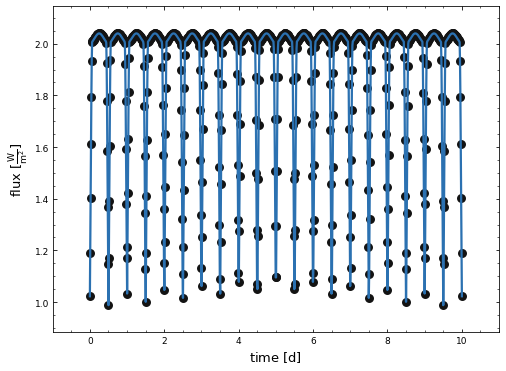

In [336]:
afig, mplfig = b.plot(show=True)

[2021-01-08 10:57:34,355] [INFO] [parameters:_kwargs_fill_dimension:4260]: skipping residuals for dataset
[2021-01-08 10:57:34,386] [INFO] [parameters:plot:5500]: calling autofig.plot(y=<data ((1000,) unit=W / m2)>, c=k, x=<data ((1000,) unit=d)>, xlabel=time, xqualifier=times, ylabel=flux residuals, yqualifier=residuals, linestyle=none, marker=+, z=0, i=<data ((1000,) unit=d)>, iqualifier=times, label=lc01)
[2021-01-08 10:57:34,389] [INFO] [parameters:_show_or_save:5630]: calling autofig.draw(i=None, draw_sidebars=False, draw_title=False, tight_layout=False, save=False, show=True)


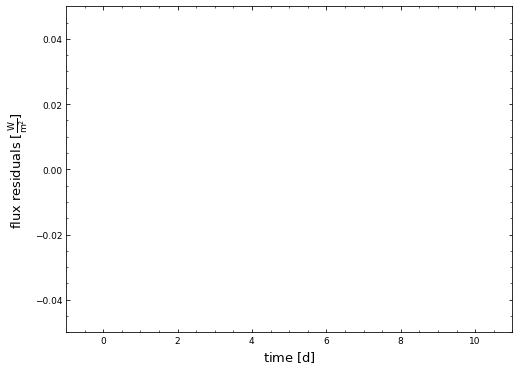

In [337]:
afig, mplfig = b.plot(y='residuals',c='k', show=True)

In [338]:
print(b.get_parameter(qualifier='solver_times', dataset='lc01'))

Parameter: solver_times@lc01@dataset
                       Qualifier: solver_times
                     Description: times to use within run_solver.  All options will properly account for masking from mask_times.  To see how this is parsed, see b.parse_solver_times.  auto: use compute_times if provided and shorter than times, otherwise use times.  compute_times: use compute_times if provided.  times: use times array.
                           Value: auto
                         Choices: auto, compute_times, times
                  Constrained by: 
                      Constrains: None
                      Related to: None



[2021-01-08 11:07:05,509] [INFO] [bundle:parse_solver_times:11282]: solver_times=times (dataset=lc01): using dataset times


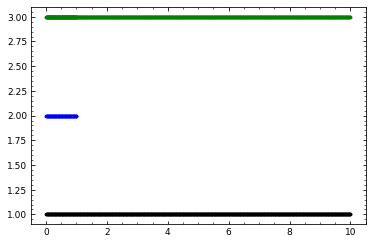

In [354]:
b.set_value('solver_times', 'times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', False)
b.set_value('dperdt', 0.0)

dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(dataset_times, np.ones_like(dataset_times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

In [361]:
b.add_compute('ellc', compute='ellc01',overwrite=True)
b.set_value_all('ld_mode', 'lookup')
b.add_solver('optimizer.nelder_mead', compute='ellc01', fit_parameters=['teff'], solver='nm_solver',overwrite=True)

[2021-01-08 11:15:03,977] [INFO] [bundle:add_compute:9462]: adding ellc 'ellc01' compute to bundle
[2021-01-08 11:15:04,540] [INFO] [bundle:add_solver:10803]: adding nelder_mead 'nm_solver' solver to bundle
[2021-01-08 11:15:04,709] [WARNING] [bundle:_run_checks_warning_error:2867]: no valid parameters in fit_parameters  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


<ParameterSet: 12 parameters | qualifiers: xatol, initial_values, expose_lnprobabilities, comments, priors_combine, maxiter, maxfev, priors, fit_parameters, compute, adaptive, fatol>

[2021-01-08 11:17:12,112] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-08 11:17:12,233] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-08 11:17:12,250] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:17:12,252] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-08 11:17:12,267] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:17:12,269] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-08 11:17:12,281] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000'

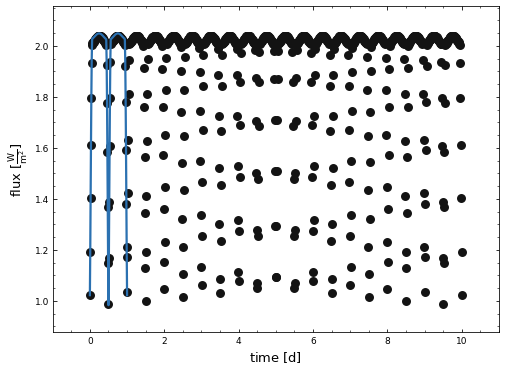

In [367]:
b.run_compute('phoebe01')
_ = b.plot(show=True)

[2021-01-08 11:18:48,527] [INFO] [bundle:parse_solver_times:11278]: solver_times=times (dataset=lc01): using masked dataset times


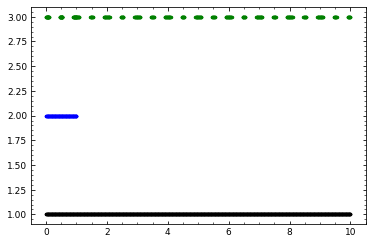

In [370]:
b.set_value('solver_times', 'times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', True)
b.set_value('mask_phases', [(-0.1, 0.1), (0.45,0.55)])
b.set_value('dperdt', 0.0)

dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(dataset_times, np.ones_like(dataset_times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

In [381]:
b.flip_constraint('compute_times', solve_for='compute_phases')
b.set_value('compute_times', phoebe.linspace(0,5,501))

print(b.run_checks_solver())

[2021-01-08 11:29:12,149] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_times@constraint' to solve for 'compute_phases'


Run Checks Report: PASS



In [377]:
b.run_compute('phoebe01')
_ = b.plot(show=True)

[2021-01-08 11:25:36,592] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-08 11:25:36,719] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-08 11:25:36,728] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:25:36,731] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-08 11:25:36,745] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:25:36,747] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-08 11:25:36,753] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000'

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1000

[2021-01-08 11:29:22,868] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@constraint' to solve for 'compute_times'
[2021-01-08 11:29:23,671] [INFO] [bundle:parse_solver_times:11272]: solver_times=auto (dataset=lc01): using user-provided compute_times (len: 101) instead of times (len: 1500)


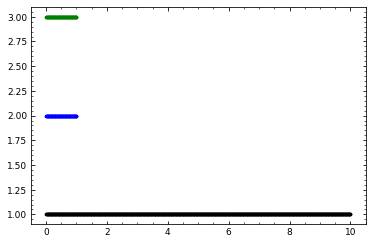

In [382]:
b.set_value('solver_times', 'auto')
b.flip_constraint('compute_phases', solve_for='compute_times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', False)
b.set_value('dperdt', 0.0)

dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(dataset_times, np.ones_like(dataset_times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

[2021-01-08 11:30:10,034] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-08 11:30:10,190] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-08 11:30:10,200] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:30:10,202] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-08 11:30:10,216] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:30:10,218] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-08 11:30:10,231] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000'

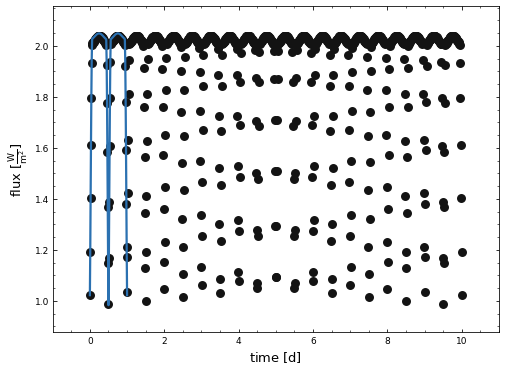

In [385]:
b.run_compute('phoebe01')
_ = b.plot(show=True)

[2021-01-08 11:32:26,070] [INFO] [bundle:parse_solver_times:11262]: solver_times=auto (dataset=lc01): using dataset times (len: 1100) instead of compute_times (len: 2001)


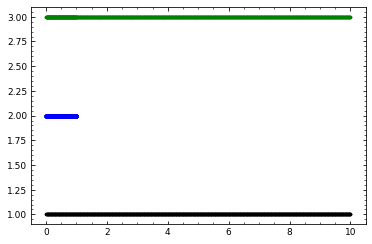

In [388]:
b.set_value('solver_times', 'auto')
b.set_value('compute_phases', phoebe.linspace(0,1,2001))
b.set_value('mask_enabled', False)
b.set_value('dperdt', 0.0)

dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(dataset_times, np.ones_like(dataset_times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

[2021-01-08 11:33:27,065] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-08 11:33:27,196] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-08 11:33:27,206] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:33:27,207] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-08 11:33:27,215] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 11:33:27,217] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-08 11:33:27,226] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000'

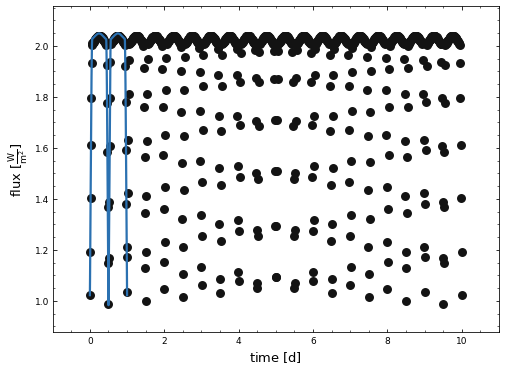

In [391]:
b.run_compute('phoebe01')
_ = b.plot(show=True)

In [393]:
b.add_dataset('mesh')
print(b.get_dataset(kind='mesh'))

[2021-01-08 18:04:09,607] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.mesh') since auto_add_figure@setting=True


ParameterSet: 6 parameters
     compute_times@mesh01@dataset: [] d
C   compute_phases@mesh01@dataset: []
         phases_t0@mesh01@dataset: t0_supconj
     include_times@mesh01@dataset: []
       coordinates@mesh01@dataset: ['xyz', 'uvw']
           columns@mesh01@dataset: []


In [416]:
print(b.get_parameter(qualifier='compute_times',kind='mesh'))
print('--------------------------')
print(b.get_parameter(qualifier='compute_phases',kind='mesh',context='dataset'))
print('--------------------------')
print(b.get_parameter(qualifier='phases_t0',kind='mesh'))
print('--------------------------')
print(b.get_parameter(qualifier='coordinates'))

Parameter: compute_times@mesh01@dataset
                       Qualifier: compute_times
                     Description: Times to use during run_compute.
                           Value: [0.] d
                  Constrained by: 
                      Constrains: compute_phases@mesh01@dataset
                      Related to: phases_period@mesh01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@mesh01@dataset, dpdt@binary@component, phases_t0@mesh01@dataset, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component, compute_phases@mesh01@dataset

--------------------------
Parameter: compute_phases@mesh01@dataset
                       Qualifier: compute_phases
                     Description: Phases associated with compute_times.
                           Value: [0.]
                  Constrained by: compute_times@mesh01@dataset, phases_period@mesh01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@mesh01

In [408]:
b.remove_compute(compute='ellc01')

<ParameterSet: 30 parameters | datasets: lc01, _default>

In [409]:
print(b.get_compute())

ParameterSet: 19 parameters
     sample_from@phoebe01@compute: []
        comments@phoebe01@compute: 
   dynamics_method@phoebe01@co...: keplerian
            ltte@phoebe01@compute: False
    irrad_method@phoebe01@compute: horvat
   boosting_method@phoebe01@co...: none
   eclipse_method@phoebe01@com...: native
   horizon_method@phoebe01@com...: boolean
   mesh_method@primary@phoebe0...: marching
   mesh_method@secondary@phoeb...: marching
   ntriangles@primary@phoebe01...: 1500
   ntriangles@secondary@phoebe...: 1500
   distortion_method@primary@p...: roche
   distortion_method@secondary...: roche
     atm@primary@phoebe01@compute: ck2004
   atm@secondary@phoebe01@compute: ck2004
    enabled@lc01@phoebe01@compute: True
      fti_method@phoebe01@compute: none
   enabled@mesh01@phoebe01@com...: True


In [412]:
print(b.get_parameter(qualifier='mesh_method', component='primary'))

Parameter: mesh_method@primary@phoebe01@compute
                       Qualifier: mesh_method
                     Description: Which method to use for discretizing the surface
                           Value: marching
                         Choices: marching
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: hierarchy.is_meshable:true



In [432]:
b.set_value('compute_times@mesh01', [0])
b.set_value('columns', value='*')
print(b.get_value('columns',expand=True))

['volume', 'xs', 'ys', 'zs', 'vxs', 'vys', 'vzs', 'nxs', 'nys', 'nzs', 'us', 'vs', 'ws', 'vus', 'vvs', 'vws', 'nus', 'nvs', 'nws', 'areas', 'loggs', 'teffs', 'rprojs', 'mus', 'visibilities', 'visible_centroids', 'rs', 'intensities@lc01', 'normal_intensities@lc01', 'abs_intensities@lc01', 'abs_normal_intensities@lc01', 'boost_factors@lc01', 'ldint@lc01', 'pblum_ext@lc01', 'abs_pblum_ext@lc01', 'ptfarea@lc01']


In [433]:
b.run_compute()

[2021-01-08 18:36:18,022] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-08 18:36:18,176] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-08 18:36:18,188] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 18:36:18,191] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-08 18:36:18,205] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-08 18:36:18,206] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-08 18:36:18,217] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000'

<ParameterSet: 85 parameters | kinds: lc, mesh>

In [431]:
print(b.filter(context='model').twigs)

['times@lc01@phoebe01@latest@lc@model', 'fluxes@lc01@phoebe01@latest@lc@model', 'times@primary@mesh01@phoebe01@latest@mesh@model', '00.000000@uvw_elements@primary@mesh01@phoebe01@latest@mesh@model', '00.000000@uvw_normals@primary@mesh01@phoebe01@latest@mesh@model', '00.000000@xyz_elements@primary@mesh01@phoebe01@latest@mesh@model', '00.000000@xyz_normals@primary@mesh01@phoebe01@latest@mesh@model', '00.000000@xs@primary@mesh01@phoebe01@latest@mesh@model', 'times@secondary@mesh01@phoebe01@latest@mesh@model', '00.000000@uvw_elements@secondary@mesh01@phoebe01@latest@mesh@model', '00.000000@uvw_normals@secondary@mesh01@phoebe01@latest@mesh@model', '00.000000@xyz_elements@secondary@mesh01@phoebe01@latest@mesh@model', '00.000000@xyz_normals@secondary@mesh01@phoebe01@latest@mesh@model', '00.000000@xs@secondary@mesh01@phoebe01@latest@mesh@model', 'comments@phoebe01@latest@model']


In [437]:
print(b.get_parameter('times',component='primary',kind='mesh',context='model'))

Parameter: times@primary@latest@model
                       Qualifier: times
                     Description: Model (synthetic) times
                           Value: [0.] d
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [439]:
print(b.get_parameter(qualifier='volume', 
                      component='primary', 
                      dataset='mesh01',
                      kind='mesh', 
                      context='model'))

Parameter: volume@primary@latest@model
                       Qualifier: volume
                     Description: Volume of the stellar surface
                           Value: 4.188790204786394 solRad3
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [444]:
print(b.get_parameter(qualifier='uvw_elements', 
                      component='primary', 
                      dataset='mesh01',
                      kind='mesh', 
                      context='model'))

Parameter: uvw_elements@primary@latest@model
                       Qualifier: uvw_elements
                     Description: Vertices of triangles in the plane-of-sky
                           Value: [[[ 1.62265482e-16  9.94317914e-01 -2.64999643e+00]
  [ 1.70774301e-16  9.85088750e-01 -2.78895598e+00]
  [-1.20321393e-01  9.84831802e-01 -2.71947831e+00]]

 [[ 1.62265482e-16  9.94317914e-01 -2.64999643e+00]
  [-1.20321393e-01  9.84831802e-01 -2.71947831e+00]
  [-1.20320268e-01  9.84579079e-01 -2.58054906e+00]]

 [[ 1.62265482e-16  9.94317914e-01 -2.64999643e+00]
  [-1.20320268e-01  9.84579079e-01 -2.58054906e+00]
  [ 2.08863018e-16  9.84587453e-01 -2.51107309e+00]]

 ...

 [[ 3.97322583e-01 -5.11346763e-01 -1.88153349e+00]
  [ 3.18975178e-01 -5.77524031e-01 -1.89419079e+00]
  [ 2.91609721e-01 -6.56940709e-01 -1.95122702e+00]]

 [[ 3.18906370e-01 -4.71582861e-01 -1.82128184e+00]
  [ 3.18975178e-01 -5.77524031e-01 -1.89419079e+00]
  [ 3.97322583e-01 -5.11346763e-01 -1.88153349e+00]]

 [

In [445]:
print(b.get_parameter(qualifier='xyz_elements', 
                      component='primary', 
                      dataset='mesh01',
                      kind='mesh', 
                      context='model'))

Parameter: xyz_elements@primary@latest@model
                       Qualifier: xyz_elements
                     Description: Vertices of triangles in Roche coordinates
                           Value: [[[ 6.74342000e-07  2.82168465e-50  1.87607154e-01]
  [-2.62181103e-02  2.79480223e-50  1.85865802e-01]
  [-1.31091147e-02 -2.27021496e-02  1.85817321e-01]]

 [[ 6.74342000e-07  2.82168465e-50  1.87607154e-01]
  [-1.31091147e-02 -2.27021496e-02  1.85817321e-01]
  [ 1.31039512e-02 -2.27019374e-02  1.85769637e-01]]

 [[ 6.74342000e-07  2.82168465e-50  1.87607154e-01]
  [ 1.31039512e-02 -2.27019374e-02  1.85769637e-01]
  [ 2.62126242e-02  1.03970068e-17  1.85771218e-01]]

 ...

 [[ 1.44993680e-01  7.49665252e-02 -9.64805213e-02]
  [ 1.42605511e-01  6.01839958e-02 -1.08966798e-01]
  [ 1.31843959e-01  5.50207022e-02 -1.23951077e-01]]

 [[ 1.56361917e-01  6.01710132e-02 -8.89778982e-02]
  [ 1.42605511e-01  6.01839958e-02 -1.08966798e-01]
  [ 1.44993680e-01  7.49665252e-02 -9.64805213e-02]]

 

In [450]:
print(b.get_parameter(qualifier='compute_phases', kind='lc',context='dataset'))
print(b.get_parameter(qualifier='phases_t0',kind='lc'))
print(b.get_parameter(qualifier='ld_mode', component='primary'))

Parameter: compute_phases@lc01@dataset
                       Qualifier: compute_phases
                     Description: Phases associated with compute_times.
                           Value: <linspace start=0.0 stop=1.0 num=2001 endpoint=True unit=>
                  Constrained by: 
                      Constrains: compute_times@lc01@dataset
                      Related to: compute_times@lc01@dataset, phases_period@lc01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@lc01@dataset, dpdt@binary@component, phases_t0@lc01@dataset, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component

Parameter: phases_t0@lc01@dataset
                       Qualifier: phases_t0
                     Description: t0 to use when converting between compute_times and compute_phases as well as when applying mask_phases
                           Value: t0_supconj
                         Choices: t0_supconj, t0_perpass, t0_ref
                  Constr

In [454]:
print(b.get_parameter(qualifier='ld_mode', dataset='lc01', component='primary'))

Parameter: ld_mode@primary@lc01@dataset
                       Qualifier: ld_mode
                     Description: Mode to use for limb-darkening
                           Value: lookup
                         Choices: interp, lookup, manual
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [455]:
print(b.filter(qualifier='ld*', dataset='lc01'))

ParameterSet: 8 parameters
     ld_mode@primary@lc01@dataset: lookup
   ld_mode@secondary@lc01@dataset: lookup
     ld_func@primary@lc01@dataset: logarithmic
   ld_func@secondary@lc01@dataset: logarithmic
   ld_coeffs_source@primary@lc...: auto
   ld_coeffs_source@secondary@...: auto
R      ldint@primary@latest@model: [0.79829997 0.79831328 0.79832572 ...
 0.79846672 0.7984655  0.79847791]
R    ldint@secondary@latest@model: [0.79967907 0.79969082 0.79970139 ...
 0.79976103 0.79975226 0.79975913]


In [456]:
print(b.get_parameter(qualifier='ld_coeffs_source', dataset='lc01', component='primary'))

Parameter: ld_coeffs_source@primary@lc01@dataset
                       Qualifier: ld_coeffs_source
                     Description: Source for limb darkening coefficients ('auto' to interpolate from the applicable table according to the 'atm' parameter, or the name of a specific atmosphere table)
                           Value: auto
                         Choices: auto, phoenix, ck2004
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: ld_mode:lookup



In [463]:
b['atm@primary'].choices
b['ld_func@primary']
b['atm@primary'] = 'ck2004'
print(b.run_checks())

Run Checks Report: PASS



In [470]:
print(phoebe.list_installed_passbands())
print(phoebe.list_passband_directories())
print(phoebe.list_online_passbands())

['Bolometric:900-40000', 'Johnson:V', 'Kepler:mean']
['/home/abiao/anaconda3/lib/python3.7/site-packages/phoebe/atmospheres/tables/passbands/', '/home/abiao/.phoebe/atmospheres/tables/passbands/']
['BRITE:blue', 'BRITE:red', 'Bolometric:900-40000', 'Cousins:I', 'Cousins:R', 'Gaia:BP', 'Gaia:G', 'Gaia:RP', 'Gaia:RVS', 'Hipparcos:Hp', 'Johnson:B', 'Johnson:I', 'Johnson:R', 'Johnson:U', 'Johnson:V', 'KELT:R', 'Kepler:mean', 'LSST:g', 'LSST:i', 'LSST:r', 'LSST:u', 'LSST:y3', 'LSST:z', 'PanStarrs:g', 'PanStarrs:i', 'PanStarrs:open', 'PanStarrs:r', 'PanStarrs:w', 'PanStarrs:y', 'PanStarrs:z', 'SDSS:g', 'SDSS:gprime', 'SDSS:i', 'SDSS:iprime', 'SDSS:r', 'SDSS:rprime', 'SDSS:u', 'SDSS:uprime', 'SDSS:z', 'SDSS:zprime', 'SWASP:default', 'SWASP:pre2004', 'Stromgren:b', 'Stromgren:u', 'Stromgren:v', 'Stromgren:y', 'TESS:T', 'Tycho:B', 'Tycho:V']


In [473]:
b['irrad_method'].choices
print(b.get_parameter(qualifier='pblum_mode', dataset='lc01'))

Parameter: pblum_mode@lc01@dataset
                       Qualifier: pblum_mode
                     Description: Mode for scaling passband luminosities
                           Value: component-coupled
                         Choices: decoupled, component-coupled, dataset-coupled, dataset-scaled, absolute
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [474]:
print(b.compute_pblums())

[2021-01-09 22:46:14,017] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 22:46:14,020] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-09 22:46:14,209] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 22:46:14,211] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-09 22:46:14,397] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-09 22:46:14,399] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs_bol=[0.70977533 0.28684818]
[2021-01-09 22:46:14,625] [INFO] [bundle:compute_l

{'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 13.06703366 W>}


In [476]:
print(b.filter(qualifier='pblum'))
print(b.get_parameter(qualifier='pblum_component'))

ParameterSet: 1 parameters
       pblum@primary@lc01@dataset: 12.566370614359172 W
Parameter: pblum_component@lc01@dataset
                       Qualifier: pblum_component
                     Description: Which component's pblum will be provided
                           Value: primary
                         Choices: primary, secondary
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: pblum_mode:component-coupled



In [477]:
b.run_compute()

[2021-01-09 22:55:15,024] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-09 22:55:15,212] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-09 22:55:15,226] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 22:55:15,227] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-09 22:55:15,241] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 22:55:15,245] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-09 22:55:15,253] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000'

<ParameterSet: 85 parameters | kinds: lc, mesh>

[2021-01-09 22:58:40,310] [INFO] [parameters:plot:5500]: calling autofig.plot(dataset=None, model=None, x=<data ((1000,) unit=d)>, xlabel=time, xqualifier=times, y=<data ((1000,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=<data ((1000,) unit=d)>, iqualifier=times, linestyle=none, label=lc01)
[2021-01-09 22:58:40,313] [INFO] [parameters:plot:5500]: calling autofig.plot(dataset=None, model=None, x=<data ((2001,) unit=d)>, xlabel=time, xqualifier=times, y=<data ((2001,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=<data ((2001,) unit=d)>, iqualifier=times, marker=none, label=lc01)
[2021-01-09 22:58:40,316] [INFO] [parameters:plot:5500]: calling autofig.mesh(dataset=None, model=None, itol=1e-06, equal_aspect=True, pad_aspect=True, ec=black, fc=white, exclude_back=True, x=<data ((1740, 3) unit=solRad)>, xlabel=u, xqualifier=us, y=<data ((1740, 3) unit=solRad)>, ylabel=v, yqualifier=vs, z=<data ((1740, 3) unit=solRad)>, znormals=<data ((1740,) unit=None)>, zlabel=w, zqual

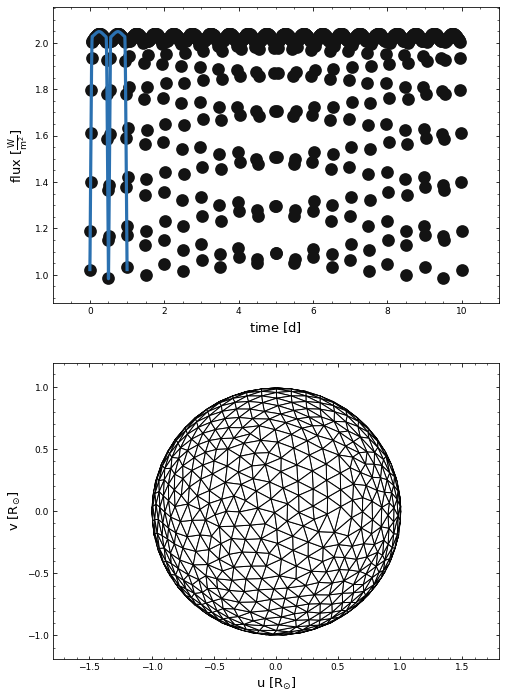

In [478]:
afig, mplfig = b.plot(show=True)

In [479]:
b.set_value('pblum_mode', 'dataset-scaled')

In [480]:
print(b.compute_pblums())

[2021-01-09 23:11:28,886] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 23:11:28,887] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-09 23:11:29,120] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 23:11:29,121] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-09 23:11:29,315] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-09 23:11:29,317] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs_bol=[0.70977533 0.28684818]
[2021-01-09 23:11:29,519] [INFO] [bundle:compute_l

{}


In [483]:
b.run_compute()

[2021-01-09 23:16:54,307] [WARNING] [bundle:_prepare_compute:9616]: overwriting model: latest
[2021-01-09 23:16:54,441] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-09 23:16:54,459] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 23:16:54,460] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-09 23:16:54,469] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 23:16:54,470] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-09 23:16:54,484] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000'

NameError: name 'param' is not defined

In [484]:
print(b.compute_pblums(model='latest'))

[2021-01-09 23:17:51,124] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='primary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 23:17:51,125] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.79071344 0.27633488]
[2021-01-09 23:17:51,341] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='lc01' component='secondary' passband='Johnson:V' from ld_coeffs_source='ck2004'
[2021-01-09 23:17:51,342] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs=[0.78822538 0.27905826]
[2021-01-09 23:17:51,563] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-09 23:17:51,566] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs_bol=[0.70977533 0.28684818]
[2021-01-09 23:17:51,741] [INFO] [bundle:compute_l

ValueError: 0 results found for twig: 'None', {'qualifier': 'flux_scale', 'dataset': 'lc01', 'model': 'latest', 'context': 'model', 'check_visible': False, 'check_default': False, 'check_advanced': False, 'check_single': False}

In [489]:
print(b['irrad_frac_refl_bol'])
print(b['irrad_frac_lost_bol'])

ParameterSet: 2 parameters
   irrad_frac_refl_bol@primary...: 0.6
   irrad_frac_refl_bol@seconda...: 0.6
ParameterSet: 4 parameters
C  irrad_frac_lost_bol@primary...: 0.4
C  irrad_frac_lost_bol@seconda...: 0.4
   irrad_frac_lost_bol@primary...: 1.000000 - {irrad_frac_refl_bol@primary@component}
   irrad_frac_lost_bol@seconda...: 1.000000 - {irrad_frac_refl_bol@secondary@component}


[2021-01-09 23:51:16,762] [INFO] [parameters:plot:5500]: calling autofig.plot(legend=True, dataset=None, model=None, x=<data ((1000,) unit=d)>, xlabel=time, xqualifier=times, y=<data ((1000,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=<data ((1000,) unit=d)>, iqualifier=times, linestyle=none, label=lc01)
[2021-01-09 23:51:16,763] [INFO] [parameters:_show_or_save:5630]: calling autofig.draw(i=None, draw_sidebars=False, draw_title=False, tight_layout=False, save=False, show=True)


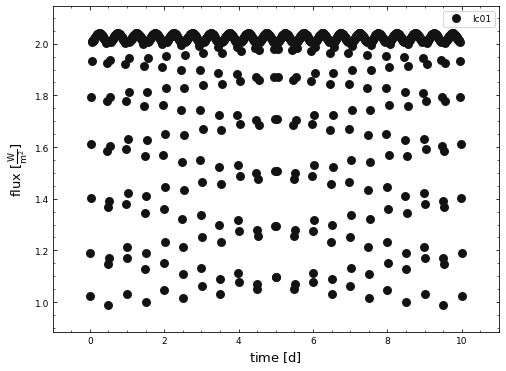

In [490]:
afig, mplfig = b.plot(show=True, legend=True)

In [493]:
print(b.filter(qualifier='period'))

ParameterSet: 5 parameters
C        period@primary@component: 1.0 d
C      period@secondary@component: 1.0 d
          period@binary@component: 1.0 d
        period@primary@constraint: {period@binary@component} / {syncpar@primary@component}
      period@secondary@constraint: {period@binary@component} / {syncpar@secondary@component}


[2021-01-10 00:12:24,845] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((1000,) unit=)>, dataset=None, model=None, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((1000,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=x, iqualifier=None, linestyle=none, label=lc01)
[2021-01-10 00:12:24,848] [INFO] [parameters:_show_or_save:5630]: calling autofig.draw(i=None, draw_sidebars=False, draw_title=False, tight_layout=False, save=False, show=True)


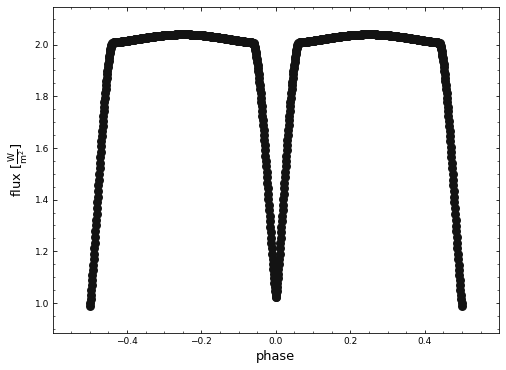

In [495]:
afig, mplfig = b.plot(x='phases', show=True)

In [562]:
b = phoebe.default_binary()
b.set_value('q', value=0.7)
b.set_value('incl', component='binary', value=87)
b.set_value('requiv', component='primary', value=0.8)
b.set_value('teff', component='secondary', value=6500)
b.set_value('syncpar', component='secondary', value=1.5)

anim_times = phoebe.arange(0.44, 0.56, 0.002)
b.add_dataset('rv', 
              times=phoebe.linspace(0,1,201), 
              dataset='dynamicalrvs')
b.set_value_all('rv_method', dataset='dynamicalrvs', value='dynamical')

b.add_dataset('rv', 
              times=phoebe.linspace(0,1,201), 
              dataset='numericalrvs')
b.set_value_all('rv_method', dataset='numericalrvs', value='flux-weighted')

b.add_dataset('mesh', 
              compute_times=anim_times, 
              coordinates='uvw', 
              columns=['rvs@numericalrvs'],
              dataset='mesh01')

b.add_dataset('lp', 
              compute_times=anim_times, 
              component=['primary', 'secondary'], 
              wavelengths=phoebe.linspace(549.5,550.5,101), 
              profile_rest=550)

b.flip_constraints_all('compute_phases',solve_for='compute_times')

[2021-01-10 01:47:39,883] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.rv') since auto_add_figure@setting=True
[2021-01-10 01:47:41,671] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.mesh') since auto_add_figure@setting=True
[2021-01-10 01:47:42,901] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.lp') since auto_add_figure@setting=True
[2021-01-10 01:47:43,560] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@dynamicalrvs@constraint' to solve for 'compute_times'
[2021-01-10 01:47:44,036] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@numericalrvs@constraint' to solve for 'compute_times'
[2021-01-10 01:47:44,502] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@mesh01@constraint' to solve for 'compute_times'
[2021-01-10 01:47:45,035] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@constraint' to solve for 'compute_times'


In [569]:
b.set_value_all('compute_phases',phoebe.linspace(0,1,100))
b.set_value('compute_phases',[0.25],kind='mesh')

In [572]:
print(b.filter('compute_phases'))

ParameterSet: 4 parameters
   compute_phases@dynamicalrvs...: [0.         0.01010101 0.02020202 ...
 0.97979798 0.98989899 1.        ]
   compute_phases@numericalrvs...: [0.         0.01010101 0.02020202 ...
 0.97979798 0.98989899 1.        ]
    compute_phases@mesh01@dataset: [0.25]
      compute_phases@lp01@dataset: [0.         0.01010101 0.02020202 ...
 0.97979798 0.98989899 1.        ]


In [573]:
np.seterr(all='ignore')
b.run_compute(irrad_method='none')

[2021-01-10 01:50:52,515] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-10 01:50:53,094] [INFO] [bundle:run_compute:10159]: run_compute: calling phoebe backend to create 'latest' model
100%|██████████| 101/101 [00:17<00:00,  5.80it/s]


<ParameterSet: 219 parameters | kinds: rv, mesh, lp>

[2021-01-10 01:53:02,407] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((100,) unit=)>, c=#22B77F, ls=dotted, dataset=None, model=None, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((100,) unit=km / s)>, ylabel=rv, yqualifier=rvs, z=0, i=x, iqualifier=None, marker=none, label=primary@dynamicalrvs)
[2021-01-10 01:53:02,409] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((100,) unit=)>, c=magenta, ls=dotted, dataset=None, model=None, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((100,) unit=km / s)>, ylabel=rv, yqualifier=rvs, z=0, i=x, iqualifier=None, marker=none, label=secondary@dynamicalrvs)
[2021-01-10 01:53:02,411] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((100,) unit=)>, c=#22B77F, ls=solid, dataset=None, model=None, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((100,) unit=km / s)>, ylabel=rv, yqualifier=rvs, z=0, i=x, iqualifier=None, marker=none, label=primary@numericalrvs)
[2021-01-10 01:53:02,412] [

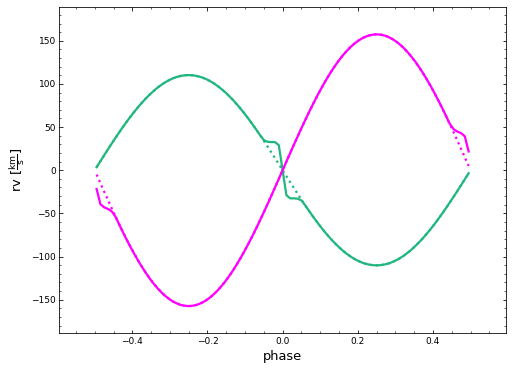

In [577]:
colors = {'primary': 'green', 'secondary': 'magenta'}
afig, mplfig = b.plot(x='phases',kind='rv',
                      c=colors, 
                      ls={'numericalrvs': 'solid', 'dynamicalrvs': 'dotted'},
                      show=True,model='latest')

In [634]:

b = phoebe.default_binary()
b.add_dataset('lc', times=phoebe.linspace(0,1,101))
b.set_value('incl@binary@orbit@component',80)
b.set_value('teff',5900,component='secondary')
b.run_compute(irrad_method='none', model='no_spot')

[2021-01-10 02:43:00,841] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.lc') since auto_add_figure@setting=True
[2021-01-10 02:43:02,209] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-10 02:43:02,451] [INFO] [bundle:run_compute:10159]: run_compute: calling phoebe backend to create 'no_spot' model
100%|██████████| 101/101 [00:12<00:00,  8.00it/s]


<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

[2021-01-10 02:46:52,980] [INFO] [bundle:_prepare_compute:9618]: overwriting model: with_spot
[2021-01-10 02:46:53,112] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-10 02:46:53,365] [INFO] [bundle:run_compute:10159]: run_compute: calling phoebe backend to create 'with_spot' model
100%|██████████| 101/101 [00:12<00:00,  7.95it/s]
[2021-01-10 02:47:06,279] [INFO] [parameters:plot:5500]: calling autofig.plot(legend=True, dataset=None, model=None, x=<data ((101,) unit=d)>, xlabel=time, xqualifier=times, y=<data ((101,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=<data ((101,) unit=d)>, iqualifier=times, marker=none, label=lc01@no_spot)
[2021-01-10 02:47:06,280] [INFO] [parameters:plot:5500]: calling autofig.plot(legend=True, dataset=None, model=None, x=<data ((101,) unit=d)>, xlabel=time, xqualifier=times, y=<data ((101,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=<data ((101,) unit=d)>, iqualifier=times, marker=no

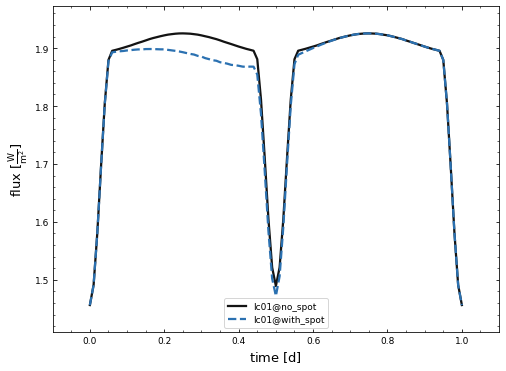

In [640]:
b.add_feature('spot', component='secondary', feature='spot01', relteff=0.9, radius=20, colat=45, long=60,overwrite=True)
b.run_compute(irrad_method='none', model='with_spot',overwrite=True)
afig, mplfig = b.plot(show=True, legend=True)

In [642]:
dirname='./KIC8098300'
lclist=np.loadtxt(dirname+'/lcdata.list',dtype=str)
rvfile1=dirname+'/KIC8098300_RV1.dat'
rvfile2=dirname+'/KIC8098300_RV2.dat'

RVs_pri=np.loadtxt(rvfile1)
RVs_sec=np.loadtxt(rvfile2)

lcdata=[]
for lcv in lclist:
    lc_i=np.loadtxt(dirname+'/'+lcv)
    lcdata.append(lc_i)
    
logger = phoebe.logger()
b = phoebe.default_binary()

# Datasets

In [644]:
i=0
tbase=2400000
b.add_dataset('lc',compute_phases=phoebe.linspace(0,1,201),
              times=tbase+lcdata[i][:,0],
              fluxes=lcdata[i][:,2],
              sigmas=lcdata[i][:,3],
              dataset='lc01',overwrite=True)
b.add_dataset('rv',compute_phases=phoebe.linspace(0,1,201),
              times={'primary':RVs_pri[:,0],'secondary':RVs_sec[:,0]},
              rvs={'primary':RVs_pri[:,1],'secondary':RVs_sec[:,1]},
              sigmas={'primary':RVs_pri[:,2],'secondary':RVs_sec[:,2]},
              dataset='rv01',overwrite=True)
b.add_dataset('mesh',compute_phases=[0,0.25,0.5,0.75,1],
              columns=['visibilities', 'intensities@lc01', 'rvs@rv01'],dataset='mesh01',overwrite=True)

[2021-01-10 03:40:13,792] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.lc') since auto_add_figure@setting=True
[2021-01-10 03:40:13,925] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@constraint' to solve for 'compute_times'
[2021-01-10 03:40:14,690] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.rv') since auto_add_figure@setting=True
[2021-01-10 03:40:14,886] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@constraint' to solve for 'compute_times'
[2021-01-10 03:40:15,708] [INFO] [bundle:add_dataset:5924]: calling add_figure(kind='dataset.mesh') since auto_add_figure@setting=True
[2021-01-10 03:40:16,031] [INFO] [bundle:flip_constraint:6715]: flipping constraint 'compute_phases@constraint' to solve for 'compute_times'


<ParameterSet: 85 parameters | contexts: figure, dataset, constraint, compute>

In [744]:
1/(1.068577662020849/1000)

935.823417933744

# System Parameters

In [186]:
mu_sun = 1.32712440018e20             # = G M_sun [m3 s^-2], Wiki Standard_gravitational_parameter
R_sun = 695700000                     # [m] Wiki Sun

P =  4.3059177                        # [day] Orbital period 
Tconj = 2454956.737583                # [day] Time of conjunction
e= 0.0052151                          # Eccentricity
w= 129.976342                        # [degree] 
q= 0.812

incl =  86.65                       # [degree] Inclination of orbit

Teff1=6500                          # [k] Temprature of primary
Teff2=6000                          # [k] Temprature of secondary

sini = np.sin(np.deg2rad(incl))     # sin(incl)
mass1 = 1.35/sini**3                 # [M_sun] Mass of primary
mass2 = 1.09/sini**3                 # [M_sun] Mass of secondary

fill1= 0.3                           # Filling factor of primary
fill2= 0.3                           # Filling factor of secondary
sma1= 6.7162635/sini                    # [R_sun]
sma2= 8.2680425/sini                    # [R_sun]
sma= 14.984306/sini                     # [R_sun]

Rp = fill1*sma1                             # [R_sun] (Albrecht et al. 2009)
Rs = fill2*sma2                             # [R_sun] (Albrecht et al. 2009) 
   
vp_sini = 109                         # [km/s] (Albrecht et al. 2009)
vs_sini = 117                         # [km/s] (Albrecht et al. 2009)
vp = vp_sini*86400/sini               # [km/s]
vs = vs_sini*86400/sini               # [km/s]

Pp = 2*np.pi*Rp*R_sun/1000/vp
Ps = 2*np.pi*Rs*R_sun/1000/vs

Fp = P/Pp
Fs = P/Ps


b['passband@lc']='Kepler:mean'
b.set_value('latex_repr', component='binary', value='orb')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')

b.set_value('period@binary', P)      
b.set_value('t0_supconj@binary',Tconj)
b.set_value('ecc', e)   
b.set_value('per0@binary', w) 
b.set_value('vgamma@system', gamma)
b.set_value('q', q)
b.set_value('incl@binary', incl)    
b.set_value('sma@binary', sma)      
b.set_value('columns', value='*')

# b.set_value('syncpar@primary', Fp)    # calculated
# b.set_value('syncpar@secondary', Fs)  # calculated

b.set_value('requiv@primary', Rp)      # !!! requiv 
b.set_value('requiv@secondary', Rs)    # !!! requiv 

b.set_value('teff@primary', Teff1)    # Wiki DI_Herculis
b.set_value('teff@secondary', Teff2)  # Wiki DI_Herculis
    
# b.set_value('gravb_bol@primary', 1.)
# b.set_value('gravb_bol@secondary', 1.)


# # beta = 72 deg (Albrecht et al. 2009)
# dOmega_p = 72
# di_p = 62  - incl
# b.set_value('pitch@primary', di_p) # di
# b.set_value('yaw@primary', dOmega_p) # dOmega

# # beta = - 84 deg (Albrecht et al. 2009)
# dOmega_s = -84
# di_s = 100 - incl
# b.set_value('pitch@secondary', di_s) # di
# b.set_value('yaw@secondary', dOmega_s) # dOmega
  
# b.set_value_all('atm','extern_planckint')
# b.set_value_all('irrad_method', 'none')

[2021-01-06 13:31:20,582] [ERROR] [bundle:run_constraint:6881]: Constraint 't0_perpass@binary@orbit@constraint' raised the following error while setting the value of 't0_perpass@binary@orbit@component'.  Original error: 0 results found for twig: 'None', {'context': 'constraint', 'uniqueid': 'CnjQgHAfNikluHHFNdDxdecTdmpSHj', 'check_visible': False, 'check_default': True, 'check_advanced': False, 'check_single': False}
[2021-01-06 13:31:20,654] [ERROR] [bundle:run_constraint:6881]: Constraint 't0_ref@binary@orbit@constraint' raised the following error while setting the value of 't0_ref@binary@orbit@component'.  Original error: 0 results found for twig: 'None', {'context': 'constraint', 'uniqueid': 'CnjQgHAfNikluHHFNdDxdecTdmpSHj', 'check_visible': False, 'check_default': True, 'check_advanced': False, 'check_single': False}
[2021-01-06 13:31:22,929] [ERROR] [bundle:run_constraint:6881]: Constraint 't0_perpass@binary@orbit@constraint' raised the following error while setting the value of 

In [190]:
b.filter(context='constraint')

<ParameterSet: 31 parameters | kinds: lc, rv, mesh, extinction, star, orbit>

In [189]:
b.run_compute()

[2021-01-06 13:32:03,962] [INFO] [bundle:run_compute:10145]: run_compute: computing necessary ld_coeffs, pblums, l3s
[2021-01-06 13:32:03,975] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-06 13:32:03,976] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs_bol=[0.7119593  0.28179969]
[2021-01-06 13:32:03,990] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='secondary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-06 13:32:03,992] [INFO] [bundle:compute_ld_coeffs:8784]: interpolated logarithmic ld_coeffs_bol=[0.70998386 0.2791576 ]
[2021-01-06 13:32:04,018] [INFO] [bundle:compute_ld_coeffs:8770]: logarithmic ld_coeffs lookup for dataset='None' component='primary' passband='Bolometric:900-40000' from ld_coeffs_source='ck2004'
[2021-01-06 13:32:04,021] [INFO]

<ParameterSet: 21 parameters | kinds: lc, rv, mesh>

[2021-01-06 14:00:52,790] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((6295,) unit=)>, dataset=None, model=None, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((6295,) unit=W / m2)>, yerror=<data ((6295,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=x, iqualifier=None, linestyle=none, label=lc01)
[2021-01-06 14:00:52,792] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((49,) unit=)>, dataset=None, model=None, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((49,) unit=km / s)>, yerror=<data ((49,) unit=km / s)>, ylabel=rv, yqualifier=rvs, z=0, i=x, iqualifier=None, linestyle=none, label=secondary@rv01)
[2021-01-06 14:00:52,795] [INFO] [parameters:plot:5500]: calling autofig.plot(x=<data ((6295,) unit=)>, dataset=None, model=None, xlabel=phase, xqualifier=phases, linebreak=x-, y=<data ((6295,) unit=W / m2)>, ylabel=flux, yqualifier=fluxes, z=0, i=x, iqualifier=None, marker=none, label=lc01)
[2021-01-06 14:00:52,796] [INFO] [paramete

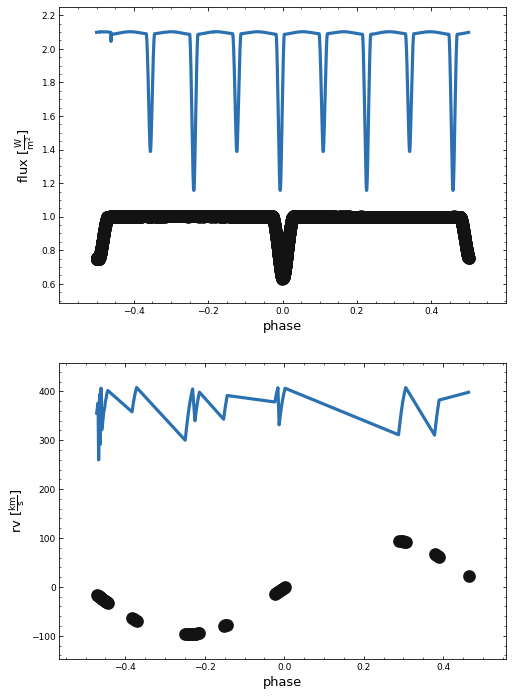

In [202]:
afig, mplfig = b.plot(x='phases',show=True)

[2021-01-06 14:02:09,299] [INFO] [parameters:plot:5500]: calling autofig.mesh(fc=<data ((1714,) unit=W / m3)>, ec=None, dataset=None, model=None, itol=1e-06, equal_aspect=True, pad_aspect=True, exclude_back=True, x=<data ((1714, 3) unit=solRad)>, xlabel=u, xqualifier=us, y=<data ((1714, 3) unit=solRad)>, ylabel=v, yqualifier=vs, z=<data ((1714, 3) unit=solRad)>, znormals=<data ((1714,) unit=None)>, zlabel=w, zqualifier=ws, fclabel=intensities, fcqualifier=intensities, i=<data (() unit=d)>, iqualifier=<data (() unit=d)>, marker=none, label=primary@mesh01)
[2021-01-06 14:02:09,301] [INFO] [parameters:plot:5500]: calling autofig.mesh(fc=<data ((1724,) unit=W / m3)>, ec=None, dataset=None, model=None, itol=1e-06, equal_aspect=True, pad_aspect=True, exclude_back=True, x=<data ((1724, 3) unit=solRad)>, xlabel=u, xqualifier=us, y=<data ((1724, 3) unit=solRad)>, ylabel=v, yqualifier=vs, z=<data ((1724, 3) unit=solRad)>, znormals=<data ((1724,) unit=None)>, zlabel=w, zqualifier=ws, fclabel=inte

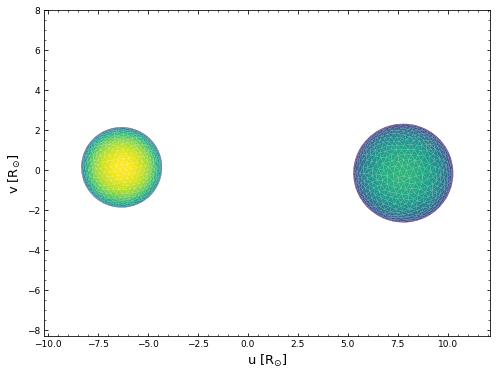

In [203]:
afig, mplfig = b.filter(kind='mesh').plot(fc='intensities', ec='None', show=True)

In [205]:
b['mesh@dataset']

<ParameterSet: 6 parameters | qualifiers: compute_phases, phases_t0, coordinates, columns, include_times, compute_times>